# Household Pulse Data Analysis

This analysis examines Long Covid (L.C.) prevalence across U.S. states and the District of Columbia, based on data from the U.S. Centers for Disease Control and Prevention (CDC) as of February 2024. We will explore potential predictors of L.C. rates and investigate statistical relationships between these factors. The dataset was curated by Julia Moore Vogel, and this analysis was conducted by Ashley Yaner. As advised by Julia Vogel, Baysian Variable selection, a statistical method used to identify the most relevant predictors or variables in a dataset, will be used to understand the most prevelant factors contributing to the rates of COVID per state.

# Imports

In [ ]:
import sys
print(f"Python executable path: {sys.executable}") 

import pandas as pd
# Set options for displaying all columns and rows in dataframe for later inspection
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

# Check pymc version for environmental package consistancy
import pymc as pm
print(pm.__version__)

In [1]:
# Imports from custom code
from utils.prepare_data import *
from utils.math import *
from utils.stats import *
from utils.plots import *
from utils.data_exploration import *

from model.model_bvs import *
from model.inspect_results_bvs import *
from model.inspect_results_hyperparam_optimization import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---
# Configs
---

Path to the household pulse data csv

In [2]:
houshold_pulse_path = "data/LC_household_pulse_v11.csv"

---
# Load Data
---

Import the houshold pulse data using pandas dataframe. 

In [3]:
df = load_data(houshold_pulse_path)

## Inspect Raw Data

Inspect household pulse data dataframe. What does it contain?

In [4]:
df.head(10)

State  Sept 24 Value  Sept 24 Low CI  Sept 24 High CI  \
0               Alabama            7.0             4.8              9.6   
1                Alaska            NaN             NaN              NaN   
2               Arizona            5.2             3.7              7.1   
3              Arkansas            6.7             4.3              9.9   
4            California            3.8             2.8              5.0   
5              Colorado            7.6             5.1             10.7   
6           Connecticut            7.5             4.6             11.5   
7              Delaware            NaN             NaN              NaN   
8  District of Columbia            NaN             NaN              NaN   
9               Florida            5.9             4.1              8.0   

   Urban  Rural  Conservative  Moderate  Liberal  Political Don't know  ...  \
0   57.7   42.3          50.0      29.0     12.0                   8.0  ...   
1   64.9   35.1          34.0      37.0     23.0                   6.0  ...   
2   89.3   10.7          39.0      31.0     23.0                   7.0  ...   
3   55.5   44.5          42.0      38.0     14.0                   6.0  ...   
4   94.2    5.8          31.0      34.0     29.0                   6.0  ...   
5   86.0   14.0          33.0      34.0     28.0                   5.0  ...   
6   86.3   13.7          33.0      36.0     25.0                   6.0  ...   
7   82.6   17.4          26.0      40.0     25.0                   9.0  ...   
8  100.0    0.0          15.0      39.0     36.0                  10.0  ...   
9   91.5    8.5          37.0      31.0     24.0                   8.0  ...   

   4/1/2024  4/29/2024  5/27/2024  6/24/2024  7/22/2024  8/19/2024  9/16/2024  \
0       7.4        8.3        8.6        5.0        5.5        7.6        7.0   
1       8.2        5.7        6.8        6.7        5.4        8.0        NaN   
2       6.4        5.4        5.9        6.9        4.9        7.4        5.2   
3       6.1        5.3        6.6        6.6        8.5        7.6        6.7   
4       7.2        4.7        5.3        4.1        6.2        4.5        3.8   
5       9.4        6.1        5.3        6.7        5.7        5.4        7.6   
6       7.7        4.6        5.8        5.5        6.3        4.6        7.5   
7       7.3        5.3        4.3        6.7        NaN        4.2        NaN   
8       4.4        3.2        3.0        2.3        2.6        3.1        NaN   
9       6.4        4.8        5.5        5.3        4.2        4.3        5.9   

     Avg  std_error  count  
0  7.462       0.26     26  
1  7.016       0.33     25  
2  6.762       0.24     26  
3  7.292       0.28     26  
4  5.742       0.23     26  
5  6.600       0.24     26  
6  6.235       0.22     26  
7  5.858       0.28     24  
8  3.527       0.19     22  
9  5.527       0.22     26  

[10 rows x 57 columns]

Print out summary stats for each column

In [5]:
df.describe()

Sept 24 Value  Sept 24 Low CI  Sept 24 High CI       Urban      Rural  \
count      46.000000       46.000000        46.000000   51.000000  51.000000   
mean        5.667391        3.795652         8.104348   72.974510  27.025490   
std         1.458775        1.057871         2.127070   15.167213  15.167213   
min         2.600000        1.600000         4.100000   35.100000   0.000000   
25%         4.700000        3.025000         6.700000   63.900000  13.950000   
50%         5.900000        3.900000         7.900000   73.000000  27.000000   
75%         6.600000        4.450000         9.600000   86.050000  36.100000   
max        10.400000        6.700000        15.100000  100.000000  64.900000   

       Conservative   Moderate    Liberal  Political Don't know  \
count     51.000000  51.000000  51.000000             51.000000   
mean      36.921569  33.392157  23.352941              6.274510   
std        7.260422   3.092432   5.610075              1.686161   
min       15.000000  27.000000  12.000000              3.000000   
25%       32.500000  31.000000  20.000000              5.000000   
50%       39.000000  33.000000  23.000000              6.000000   
75%       42.000000  35.500000  27.500000              7.500000   
max       50.000000  42.000000  36.000000             10.000000   

       Political sum  ...   4/1/2024  4/29/2024  5/27/2024  6/24/2024  \
count      51.000000  ...  51.000000  52.000000  52.000000  52.000000   
mean       99.941176  ...   7.052941   5.803846   5.996154   5.701923   
std         0.506429  ...   1.388575   1.465413   1.302179   1.423678   
min        99.000000  ...   3.600000   3.200000   3.000000   2.300000   
25%       100.000000  ...   6.400000   4.675000   5.275000   4.775000   
50%       100.000000  ...   7.200000   5.450000   6.000000   5.500000   
75%       100.000000  ...   7.850000   6.800000   6.875000   6.700000   
max       101.000000  ...  10.000000   9.000000   8.600000  10.300000   

       7/22/2024  8/19/2024  9/16/2024        Avg  std_error      count  
count  51.000000  50.000000  46.000000  52.000000  52.000000  52.000000  
mean    5.825490   5.902000   5.667391   6.348192   0.262885  25.673077  
std     1.321339   1.747709   1.458775   0.857020   0.067194   0.809773  
min     2.600000   3.100000   2.600000   3.527000   0.140000  22.000000  
25%     5.200000   4.625000   4.700000   5.851250   0.220000  26.000000  
50%     5.800000   5.700000   5.900000   6.276000   0.250000  26.000000  
75%     6.500000   7.050000   6.600000   6.899000   0.302500  26.000000  
max     8.800000  10.800000  10.400000   8.354000   0.500000  26.000000  

[8 rows x 56 columns]

---
# Data Preparation
---

## Remove specific columns

Remove the following columnar data from the Household Pulse dataframe:
1. Political sum because it is nearly 99% or 100% most of the time, therefore the values provide little to no information about the target variable.
2. Political Don't Know, as it represents a lack of information, a mix of information, or even a refusal to provide it. From a purely mathematical perspective, it doesn't contribute direct, quantifiable information about political ideology. It could be that undeclared, conservatives, liberals, moderates, and missing data all exist in the don't know category, which renders it a non-trustworthy data point. Given this, this category can be considered an outlier or missing data that doesn't fit the core focus of the study.
3. Sept value, Low CI, and High CI, since the Avg LC Rate is the target variable being considered.
4. Statistical values such as count and std_error, since those are not predictor variables. 

In [6]:
# df['Conservative'] + df['Moderate'] + df['Liberal'] + df["Political Don't know"] 

Columns to remove from the dataframe

In [7]:
cols_to_remove = [
    'Political sum',
    "Political Don't know",
    'std_error',
    'count',
    'Sept 24 Value',
    'Sept 24 Low CI',
    'Sept 24 High CI'
]

Remove the defined columns from the dataframe

In [8]:
df_cols_removed = remove_columns(df, cols_to_remove) 

Inspect the dataframe to ensure that the specified columns have been removed properly

In [9]:
# df_cols_removed.head(10)
df_cols_removed.columns

Index(['State', 'Urban', 'Rural', 'Conservative', 'Moderate', 'Liberal',
       'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'NHPI',
       'Hispanic', 'Multiple', 'Percent of total pop with at least one dose',
       'Percent of pop with an updated (bivalent) booster dose',
       'Percent of 5+ pop with a completed primary series',
       'Percent of 12+ pop with at least one dose',
       'Percent of 18+ pop with a completed primary series',
       'Percent of 65+ pop with a completed primary series', 'Paid sick leave',
       'Medicaid expansion', 'Eviction moratoria duration', '7/11/2022',
       '8/8/2022', '9/26/2022', '10/17/2022', '11/14/2022', '12/19/2022',
       '1/16/2023', '2/13/2023', '3/13/2023', '4/10/2023', '5/8/2023',
       '6/19/2023', '7/10/2023', '8/7/2023', '9/4/2023', '10/2/2023',
       '10/30/2023', '2/5/2024', '3/4/2024', '4/1/2024', '4/29/2024',
       '5/27/2024', '6/24/2024', '7/22/2024', '8/19/2024', '9/16/2024', 'Avg'],
      dtype='object'

## Set States as Index

Set the US States as the index of the dataframe

In [10]:
df_states = set_states_as_idx(df_cols_removed)

Inspect the dataframe to make sure the index has been properly set

In [11]:
df_states.head(10)

Urban  Rural  Conservative  Moderate  Liberal  \
State                                                                 
Alabama                57.7   42.3          50.0      29.0     12.0   
Alaska                 64.9   35.1          34.0      37.0     23.0   
Arizona                89.3   10.7          39.0      31.0     23.0   
Arkansas               55.5   44.5          42.0      38.0     14.0   
California             94.2    5.8          31.0      34.0     29.0   
Colorado               86.0   14.0          33.0      34.0     28.0   
Connecticut            86.3   13.7          33.0      36.0     25.0   
Delaware               82.6   17.4          26.0      40.0     25.0   
District of Columbia  100.0    0.0          15.0      39.0     36.0   
Florida                91.5    8.5          37.0      31.0     24.0   

                      Below Poverty Line     White     Black     AI_AN  \
State                                                                    
Alabama                             16.5  0.647117  0.264309  0.005532   
Alaska                              11.4  0.587953  0.032379  0.148749   
Arizona                             12.6  0.529302  0.047562  0.037277   
Arkansas                            16.8  0.709676  0.153314  0.007915   
California                          12.1  0.347300  0.055794  0.004067   
Colorado                             9.2  0.664714  0.041292  0.006301   
Connecticut                          9.9  0.638607  0.107293  0.002250   
Delaware                             8.7  0.599941  0.224680  0.003000   
District of Columbia                13.3  0.375333  0.433571  0.002090   
Florida                             12.7  0.523389  0.154157  0.002540   

                         Asian  ...  2/5/2024  3/4/2024  4/1/2024  4/29/2024  \
State                           ...                                            
Alabama               0.015477  ...       7.9       8.3       7.4        8.3   
Alaska                0.065232  ...       9.2       7.7       8.2        5.7   
Arizona               0.036369  ...       6.3       6.4       6.4        5.4   
Arkansas              0.017788  ...       8.0       6.5       6.1        5.3   
California            0.155872  ...       6.8       7.2       7.2        4.7   
Colorado              0.035518  ...       6.4       6.0       9.4        6.1   
Connecticut           0.050398  ...       6.3       6.4       7.7        4.6   
Delaware              0.042835  ...       4.9       5.2       7.3        5.3   
District of Columbia  0.045114  ...       4.5       4.1       4.4        3.2   
Florida               0.030022  ...       6.3       6.7       6.4        4.8   

                      5/27/2024  6/24/2024  7/22/2024  8/19/2024  9/16/2024  \
State                                                                         
Alabama                     8.6        5.0        5.5        7.6        7.0   
Alaska                      6.8        6.7        5.4        8.0        NaN   
Arizona                     5.9        6.9        4.9        7.4        5.2   
Arkansas                    6.6        6.6        8.5        7.6        6.7   
California                  5.3        4.1        6.2        4.5        3.8   
Colorado                    5.3        6.7        5.7        5.4        7.6   
Connecticut                 5.8        5.5        6.3        4.6        7.5   
Delaware                    4.3        6.7        NaN        4.2        NaN   
District of Columbia        3.0        2.3        2.6        3.1        NaN   
Florida                     5.5        5.3        4.2        4.3        5.9   

                        Avg  
State                        
Alabama               7.462  
Alaska                7.016  
Arizona               6.762  
Arkansas              7.292  
California            5.742  
Colorado              6.600  
Connecticut           6.235  
Delaware              5.858  
District of Columbia  3.527  
Florida               5.527  

[10 rows 

# Ensure correct date format in column headers
If the dates are in various versions of mm/dd/yyyy format, convert all of them to a single consistent to mm/dd/yyyy format

In [12]:
col_name_patterns = [
    r"(\d{2})/(\d{2})/(\d{4})",  # mm/dd/yyyy
    r"(\d)/(\d{2})/(\d{4})",  # m/dd/yyyy
    r"(\d)/(\d)/(\d{4})",  # m/d/yyyy
    r"(\d{2})/(\d)/(\d{4})"  # mm/d/yyyy
]

In [13]:
df_states = convert_dates_to_same_format(df_states, col_name_patterns)

('7', '11', '2022')
('8', '8', '2022')
('9', '26', '2022')
('10', '17', '2022')
('11', '14', '2022')
('12', '19', '2022')
('1', '16', '2023')
('2', '13', '2023')
('3', '13', '2023')
('4', '10', '2023')
('5', '8', '2023')
('6', '19', '2023')
('7', '10', '2023')
('8', '7', '2023')
('9', '4', '2023')
('10', '2', '2023')
('10', '30', '2023')
('2', '5', '2024')
('3', '4', '2024')
('4', '1', '2024')
('4', '29', '2024')
('5', '27', '2024')
('6', '24', '2024')
('7', '22', '2024')
('8', '19', '2024')
('9', '16', '2024')


In [14]:
df_states.head(10)

Urban  Rural  Conservative  Moderate  Liberal  \
State                                                                 
Alabama                57.7   42.3          50.0      29.0     12.0   
Alaska                 64.9   35.1          34.0      37.0     23.0   
Arizona                89.3   10.7          39.0      31.0     23.0   
Arkansas               55.5   44.5          42.0      38.0     14.0   
California             94.2    5.8          31.0      34.0     29.0   
Colorado               86.0   14.0          33.0      34.0     28.0   
Connecticut            86.3   13.7          33.0      36.0     25.0   
Delaware               82.6   17.4          26.0      40.0     25.0   
District of Columbia  100.0    0.0          15.0      39.0     36.0   
Florida                91.5    8.5          37.0      31.0     24.0   

                      Below Poverty Line     White     Black     AI_AN  \
State                                                                    
Alabama                             16.5  0.647117  0.264309  0.005532   
Alaska                              11.4  0.587953  0.032379  0.148749   
Arizona                             12.6  0.529302  0.047562  0.037277   
Arkansas                            16.8  0.709676  0.153314  0.007915   
California                          12.1  0.347300  0.055794  0.004067   
Colorado                             9.2  0.664714  0.041292  0.006301   
Connecticut                          9.9  0.638607  0.107293  0.002250   
Delaware                             8.7  0.599941  0.224680  0.003000   
District of Columbia                13.3  0.375333  0.433571  0.002090   
Florida                             12.7  0.523389  0.154157  0.002540   

                         Asian  ...  02/05/2024  03/04/2024  04/01/2024  \
State                           ...                                       
Alabama               0.015477  ...         7.9         8.3         7.4   
Alaska                0.065232  ...         9.2         7.7         8.2   
Arizona               0.036369  ...         6.3         6.4         6.4   
Arkansas              0.017788  ...         8.0         6.5         6.1   
California            0.155872  ...         6.8         7.2         7.2   
Colorado              0.035518  ...         6.4         6.0         9.4   
Connecticut           0.050398  ...         6.3         6.4         7.7   
Delaware              0.042835  ...         4.9         5.2         7.3   
District of Columbia  0.045114  ...         4.5         4.1         4.4   
Florida               0.030022  ...         6.3         6.7         6.4   

                      04/29/2024  05/27/2024  06/24/2024  07/22/2024  \
State                                                                  
Alabama                      8.3         8.6         5.0         5.5   
Alaska                       5.7         6.8         6.7         5.4   
Arizona                      5.4         5.9         6.9         4.9   
Arkansas                     5.3         6.6         6.6         8.5   
California                   4.7         5.3         4.1         6.2   
Colorado                     6.1         5.3         6.7         5.7   
Connecticut                  4.6         5.8         5.5         6.3   
Delaware                     5.3         4.3         6.7         NaN   
District of Columbia         3.2         3.0         2.3         2.6   
Florida                      4.8         5.5         5.3         4.2   

                      08/19/2024  09/16/2024    Avg  
State                                                
Alabama                      7.6         7.0  7.462  
Alaska                       8.0         NaN  7.016  
Arizona                      7.4         5.2  6.762  
Arkansas                     7.6         6.7  7.292  
California                   4.5         3.8  5.742  
Colorado                     5.4         7.6  6.600  
Connecticut                  4.6         7.5  6.235  
Delaware                    

---
# Feature Extraction: Target Variable
---

## Extract Avg Long COVID rates for target variable
Separate long covid rate target variables from the predictor variables.

The Target variables exist in both discrete date columns as well as an Avg Column in the dataframe.
Set Long COVID Rate column header regex patterns for extraction from dataframe

In [15]:
col_name_patterns = [
    r"\d{2}/\d{2}/\d{4}", # mm/dd/yyyy Rate
    r"Avg"  # Avg LC Rate
]

Extract the target data from the dataframe

In [16]:
lc_rates = extract_lc_rates(df_states, col_name_patterns) 

Inspect the target dataframe, lc_rates, contains the desired long covid rate columns.
Should contain both discrete dates and Avg columns.

In [17]:
lc_rates.head(10)

07/11/2022  08/08/2022  09/26/2022  10/17/2022  \
State                                                                  
Alabama                      9.0        11.2         7.6         8.0   
Alaska                       8.7         7.9         8.1         8.8   
Arizona                      9.6        10.1         6.2         7.9   
Arkansas                     8.9         7.2         9.1        10.5   
California                   7.0         8.7         6.3         7.7   
Colorado                     7.7         9.3         7.8         8.0   
Connecticut                  7.7         7.7         6.5         5.0   
Delaware                     3.8         5.1         8.3         5.9   
District of Columbia         3.5         6.1         NaN         3.2   
Florida                      7.2         9.1         6.9         4.8   

                      11/14/2022  12/19/2022  01/16/2023  02/13/2023  \
State                                                                  
Alabama                      9.0         6.8         7.3         5.7   
Alaska                       8.1         5.5         4.9         5.4   
Arizona                      7.3         6.1         5.9         6.9   
Arkansas                     9.1         6.8         8.0         6.4   
California                   6.8         5.8         5.3         5.8   
Colorado                     6.1         6.6         5.4         7.8   
Connecticut                  7.5         5.2         7.5         5.9   
Delaware                     8.2         5.3         8.4         7.3   
District of Columbia         3.4         4.1         3.8         3.8   
Florida                      6.3         4.5         5.1         4.6   

                      03/13/2023  04/10/2023  ...  02/05/2024  03/04/2024  \
State                                         ...                           
Alabama                      7.6         7.3  ...         7.9         8.3   
Alaska                       4.9         5.3  ...         9.2         7.7   
Arizona                      7.6         7.0  ...         6.3         6.4   
Arkansas                     6.2         8.9  ...         8.0         6.5   
California                   5.5         5.4  ...         6.8         7.2   
Colorado                     6.1         6.1  ...         6.4         6.0   
Connecticut                  6.7         8.0  ...         6.3         6.4   
Delaware                     6.3         5.9  ...         4.9         5.2   
District of Columbia         3.2         4.0  ...         4.5         4.1   
Florida                      5.8         4.6  ...         6.3         6.7   

                      04/01/2024  04/29/2024  05/27/2024  06/24/2024  \
State                                                                  
Alabama                      7.4         8.3         8.6         5.0   
Alaska                       8.2         5.7         6.8         6.7   
Arizona                      6.4         5.4         5.9         6.9   
Arkansas                     6.1         5.3         6.6         6.6   
California                   7.2         4.7         5.3         4.1   
Colorado                     9.4         6.1         5.3         6.7   
Connecticut                  7.7         4.6         5.8         5.5   
Delaware                     7.3         5.3         4.3         6.7   
District of Columbia         4.4         3.2         3.0         2.3   
Florida                      6.4         4.8         5.5         5.3   

                      07/22/2024  08/19/2024  09/16/2024    Avg  
State                                                            
Alabama                      5.5         7.6         7.0  7.462  
Alaska                       5.4         8.0         NaN  7.016  
Arizona                      4.9         7.4         5.2  6.762  
Arkansas                     8.5         7.6         6.7  7.292  
California                   6.2         4.5         3.8  5.742  
Colorado                     5.7        

## Inspect Long COVID Rates

### Long COVID Rate Data Preparation for Inspection
First, convert matrix to vector by flattening the dataframe for qq plotting.

In [18]:
lc_rates_flat = matrix_to_vector(lc_rates)

print(f"lc rates num of state rows: {lc_rates.shape[0]}")
print(f"lc rates num of rate columns: {lc_rates.shape[1]}")
print(f"lc rates total num of data points: {len(lc_rates_flat)}")
print(f"lc rates min: {lc_rates_flat.min()}, max: {lc_rates_flat.max()}")

lc rates num of state rows: 51
lc rates num of rate columns: 27
lc rates total num of data points: 1377
lc rates min: 2.0, max: 16.5


### Normalize Long COVID Rates for Subsequent Plots
Standardization, or converting data to z-scores, is a common preprocessing step in many machine learning algorithms, including Bayesian variable selection, for the following reasons: 
1. Scale Invariance:
    - Standardizing the data ensures that all features are on a comparable scale, preventing features with larger magnitudes from dominating the model.
2. Regularization:
     - Prevent overfitting.
     - Standardizing the data can help regularization techniques work more effectively by ensuring that all features have a similar impact on the model.
3. Prior Distribution Choice:
    - When using prior distributions for Bayesian modeling, standardizing the data can make it easier to choose appropriate priors.
4. Interpretability:
    - Standardized coefficients can be more interpretable than unstandardized coefficients.
    - A standardized coefficient represents the change in the target variable for a one standard deviation increase in the predictor variable, which can provide a clearer understanding of the feature's importance.

#### Compute Z-Scores
1. For array data for the purpose of Q-Q plotting
2. For dataframa for the purpose of dendrogram plotting

In [19]:
# flattened dataframe data (numpy array, vector data)
lc_rates_flat_z_scores = compute_zscore_np(lc_rates_flat)

In [20]:
# dataframe data (matrix data)
lc_rates_zscore = compute_zscore_df(lc_rates)

Inspect zscore results

In [21]:
lc_rates_zscore.head(10)

07/11/2022  08/08/2022    09/26/2022  10/17/2022  \
State                                                                    
Alabama                 0.668492    2.113911  1.451508e-02    0.471193   
Alaska                  0.508566    0.254661  2.685290e-01    0.904182   
Arizona                 0.988345    1.494161 -6.967239e-01    0.417070   
Arkansas                0.615184   -0.139725  7.765568e-01    1.824282   
California             -0.397684    0.705388 -6.459211e-01    0.308823   
Colorado               -0.024522    1.043434  1.161206e-01    0.471193   
Connecticut            -0.024522    0.141979 -5.443155e-01   -1.152513   
Delaware               -2.103565   -1.322885  3.701346e-01   -0.665401   
District of Columbia   -2.263492   -0.759476  9.063045e-17   -2.126737   
Florida                -0.291066    0.930752 -3.411044e-01   -1.260760   

                      11/14/2022  12/19/2022  01/16/2023  02/13/2023  \
State                                                                  
Alabama                 1.611858    0.999512    0.727689   -0.296009   
Alaska                  0.861510   -0.415919   -0.946543   -0.498194   
Arizona                 0.194535    0.237357   -0.248946    0.512731   
Arkansas                1.695229    0.999512    1.216007    0.175756   
California             -0.222325   -0.089281   -0.667504   -0.228614   
Colorado               -0.805929    0.781753   -0.597745    1.119286   
Connecticut             0.361278   -0.742557    0.867209   -0.161219   
Delaware                0.944882   -0.633678    1.495046    0.782311   
District of Columbia   -3.056971   -1.940229   -1.713899   -1.576514   
Florida                -0.639185   -1.504712   -0.807024   -1.037354   

                      03/13/2023  04/10/2023  ...  02/05/2024  03/04/2024  \
State                                         ...                           
Alabama                 0.684017    0.645814  ...    0.588441    1.212185   
Alaska                 -0.904333   -0.818030  ...    1.406338    0.764204   
Arizona                 0.684017    0.426237  ...   -0.418200   -0.206423   
Arkansas               -0.139572    1.816889  ...    0.651357   -0.131759   
California             -0.551366   -0.744838  ...   -0.103625    0.390886   
Colorado               -0.198400   -0.232493  ...   -0.355285   -0.505077   
Connecticut             0.154567    1.158159  ...   -0.418200   -0.206423   
Delaware               -0.080744   -0.378877  ...   -1.299012   -1.102386   
District of Columbia   -1.904405   -1.769529  ...   -1.550673   -1.923685   
Florida                -0.374883   -1.330376  ...   -0.418200    0.017568   

                      04/01/2024  04/29/2024  05/27/2024  06/24/2024  \
State                                                                  
Alabama                 0.245276    1.681910    1.979963   -0.494052   
Alaska                  0.815687   -0.076933    0.611284    0.689216   
Arizona                -0.467736   -0.279876   -0.073056    0.828425   
Arkansas               -0.681640   -0.347524    0.459208    0.619612   
California              0.102674   -0.753411   -0.529282   -1.120489   
Colorado                1.671302    0.193658   -0.529282    0.689216   
Connecticut             0.459180   -0.821058   -0.149094   -0.146032   
Delaware                0.173975   -0.347524   -1.289660    0.689216   
District of Columbia   -1.893762   -1.768128   -2.278150   -2.373361   
Florida                -0.467736   -0.685763   -0.377207   -0.285240   

                        07/22/2024  08/19/2024    09/16/2024       Avg  
State                                                                   
Alabama              -2.488890e-01    0.957474  8.984184e-01  1.282167  
Alaska               -3.238556e-01    1.184123  6.908054e-17  0.766425  
Arizona              -6.986885e-01    0.844150 -3.225865e-01  0.472707  
Arkansas              2.000108e+00    0.957474  6.949176e-01  1.085584  
California            2.758770e-01   -0.

Check zscore results for any NaN, Infinite, or Zero values

In [23]:
check_df_for_nan_null_inf_zero(lc_rates_zscore)

Is NaN: 07/11/2022    False
08/08/2022    False
09/26/2022    False
10/17/2022    False
11/14/2022    False
12/19/2022    False
01/16/2023    False
02/13/2023    False
03/13/2023    False
04/10/2023    False
05/08/2023    False
06/19/2023    False
07/10/2023    False
08/07/2023    False
09/04/2023    False
10/02/2023    False
10/30/2023    False
02/05/2024    False
03/04/2024    False
04/01/2024    False
04/29/2024    False
05/27/2024    False
06/24/2024    False
07/22/2024    False
08/19/2024    False
09/16/2024    False
Avg           False
dtype: bool

Is Null: 07/11/2022    False
08/08/2022    False
09/26/2022    False
10/17/2022    False
11/14/2022    False
12/19/2022    False
01/16/2023    False
02/13/2023    False
03/13/2023    False
04/10/2023    False
05/08/2023    False
06/19/2023    False
07/10/2023    False
08/07/2023    False
09/04/2023    False
10/02/2023    False
10/30/2023    False
02/05/2024    False
03/04/2024    False
04/01/2024    False
04/29/2024    False
05/27/2024

### Inspect Long COVID Rates: Q-Q Plot

theoretical_quantiles min: -3.1806387074175153, max: 3.1806387074174944
data min: -2.7728982055990428, max: 6.444366619130087
len(data): 1360


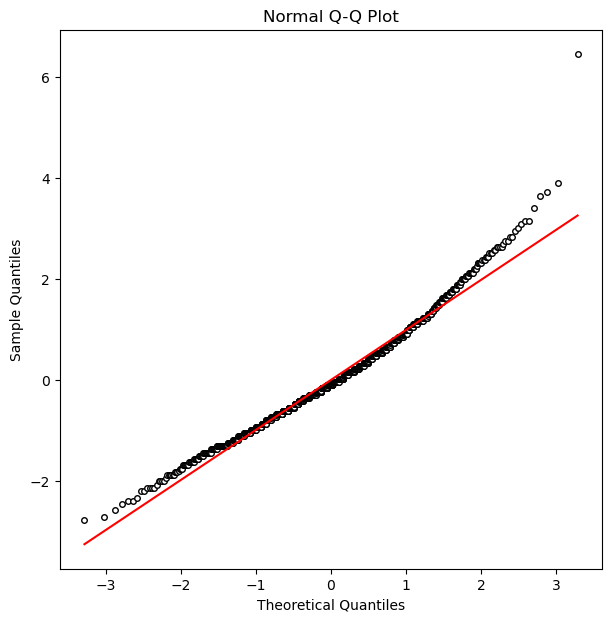

In [24]:
create_qq_plot(lc_rates_flat_z_scores)

### Inspect Long COVID Rates: Dendrogram

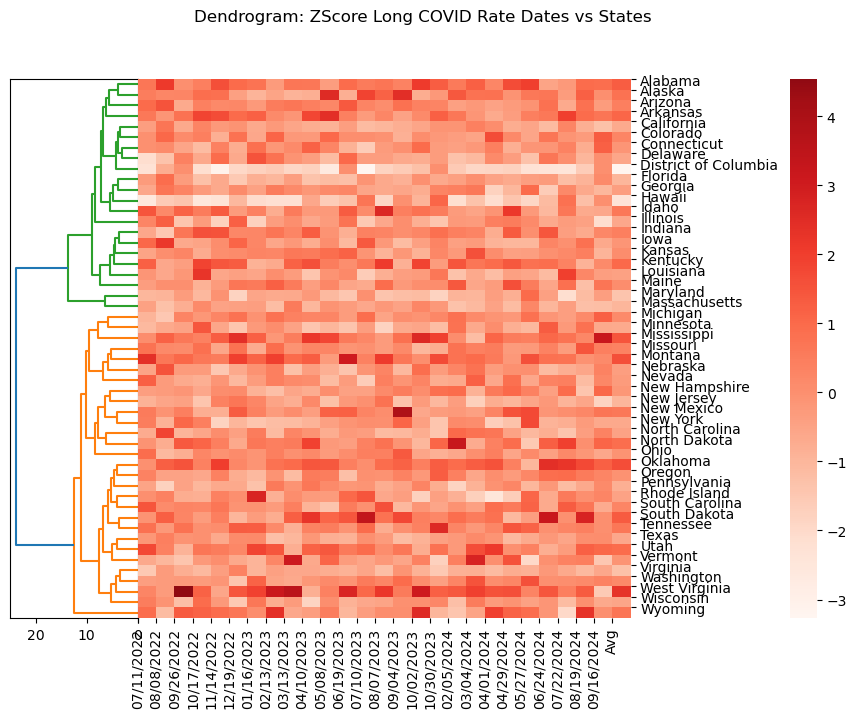

In [25]:
dendrogram(lc_rates_zscore)

---
# Feature Extraction: Predictor Variables
---

Isolate Avg column, which is the Avg Long COVID Rate target variable

In [26]:
list_of_cols_to_remove = ['Avg']  

Extract predictor variables.
- "pattern_date" is the regex pattern for the discrete time Long COVID target values in mm/dd/yyyy format.

In [27]:
df_variables = get_variables_df(
    df_states,
    list_of_cols_to_remove,
    pattern_date="\d{2}/\d{2}/\d{4}"
)

#### Inspect the predictor variable dataframe

In [28]:
# Statistics
df_variables.describe()

Urban      Rural  Conservative   Moderate    Liberal  \
count   51.000000  51.000000     51.000000  51.000000  51.000000   
mean    72.974510  27.025490     36.921569  33.392157  23.352941   
std     15.167213  15.167213      7.260422   3.092432   5.610075   
min     35.100000   0.000000     15.000000  27.000000  12.000000   
25%     63.900000  13.950000     32.500000  31.000000  20.000000   
50%     73.000000  27.000000     39.000000  33.000000  23.000000   
75%     86.050000  36.100000     42.000000  35.500000  27.500000   
max    100.000000  64.900000     50.000000  42.000000  36.000000   

       Below Poverty Line      White      Black      AI_AN      Asian  ...  \
count           51.000000  51.000000  51.000000  51.000000  51.000000  ...   
mean            12.313725   0.665471   0.112706   0.015072   0.046352  ...   
std              2.721692   0.162677   0.103861   0.028291   0.053442  ...   
min              6.800000   0.212881   0.005526   0.001459   0.008937  ...   
25%             10.450000   0.569132   0.035174   0.002341   0.018988  ...   
50%             12.000000   0.695530   0.075402   0.004396   0.031290  ...   
75%             13.350000   0.780268   0.148758   0.009580   0.052204  ...   
max             19.100000   0.921946   0.433571   0.148749   0.358978  ...   

        Multiple  Percent of total pop with at least one dose  \
count  51.000000                                    51.000000   
mean    0.048628                                    79.566667   
std     0.036306                                    10.916715   
min     0.021177                                    61.800000   
25%     0.031388                                    69.750000   
50%     0.039490                                    78.400000   
75%     0.056124                                    90.650000   
max     0.271867                                    95.000000   

       Percent of pop with an updated (bivalent) booster dose  \
count                                          51.000000        
mean                                           18.103922        
std                                             6.578904        
min                                             6.800000        
25%                                            12.850000        
50%                                            17.100000        
75%                                            22.400000        
max                                            34.300000        

       Percent of 5+ pop with a completed primary series  \
count                                          51.000000   
mean                                           72.605882   
std                                            10.008125   
min                                            56.600000   
25%                                            63.450000   
50%                                            71.200000   
75%                                            79.400000   
max                                            95.000000   

       Percent of 12+ pop with at least one dose  \
count                                  51.000000   
mean                                   86.343137   
std                                     8.369451   
min                                    70.900000   
25%                                    78.500000   
50%                                    86.900000   
75%                                    95.000000   
max                                    95.000000   

       Percent of 18+ pop with a completed primary series  \
count                                          51.000000    
mean                                           78.203922    
std                                             8.945054    
min                                            63.300000    
25%                                            69.750000    
50%                                            77.700000    
75%                                            84.650000    
max                       

In [29]:
# Number of columns
len(df_variables.columns)

22

In [30]:
# Column names
df_variables.columns

Index(['Urban', 'Rural', 'Conservative', 'Moderate', 'Liberal',
       'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'NHPI',
       'Hispanic', 'Multiple', 'Percent of total pop with at least one dose',
       'Percent of pop with an updated (bivalent) booster dose',
       'Percent of 5+ pop with a completed primary series',
       'Percent of 12+ pop with at least one dose',
       'Percent of 18+ pop with a completed primary series',
       'Percent of 65+ pop with a completed primary series', 'Paid sick leave',
       'Medicaid expansion', 'Eviction moratoria duration'],
      dtype='object')

#### Check to see if any Nans, zeros, inf data points

In [31]:
check_df_for_nan_null_inf_zero(df_variables)

Is NaN: Urban                                                     False
Rural                                                     False
Conservative                                              False
Moderate                                                  False
Liberal                                                   False
Below Poverty Line                                        False
White                                                     False
Black                                                     False
AI_AN                                                     False
Asian                                                     False
NHPI                                                      False
Hispanic                                                  False
Multiple                                                  False
Percent of total pop with at least one dose               False
Percent of pop with an updated (bivalent) booster dose    False
Percent of 5+ pop with a complet

## Visualize Predictor Variables vs Target Variable

Histograms of each predictor variable

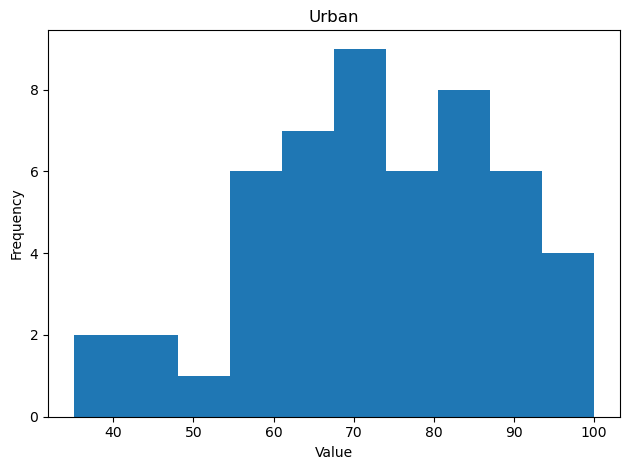

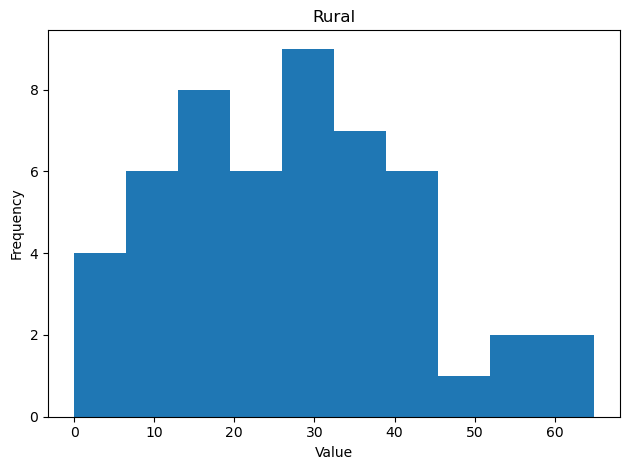

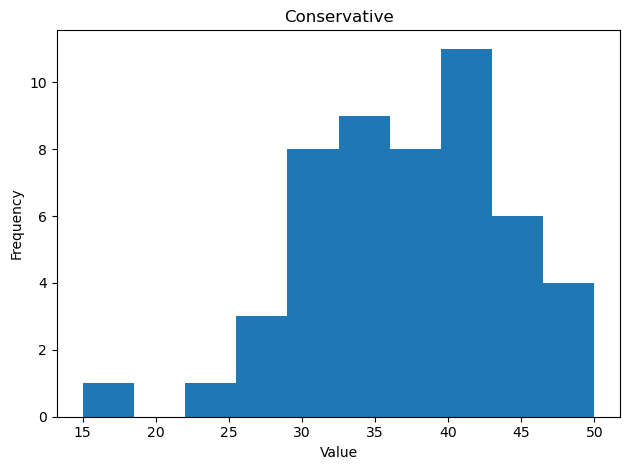

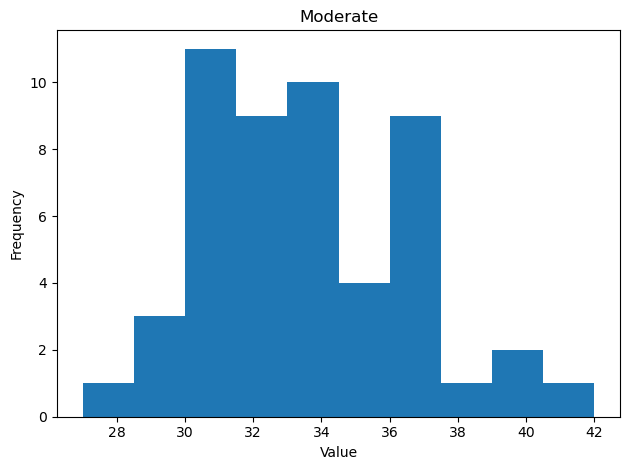

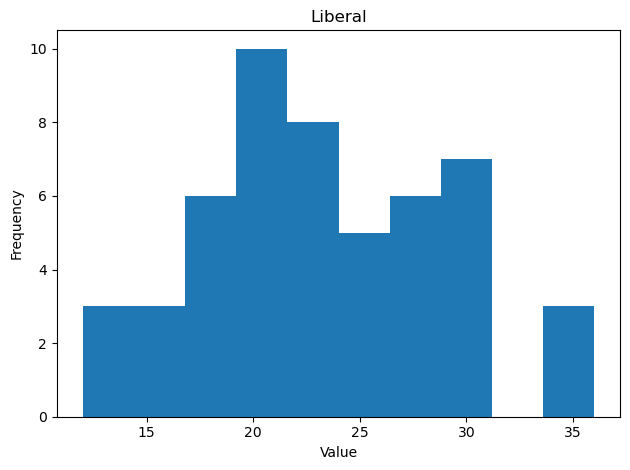

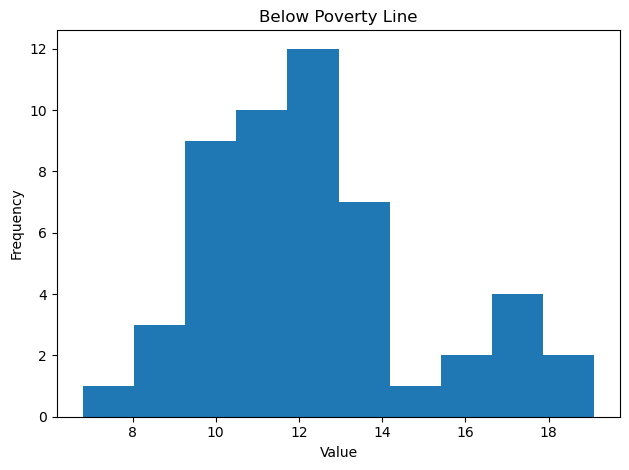

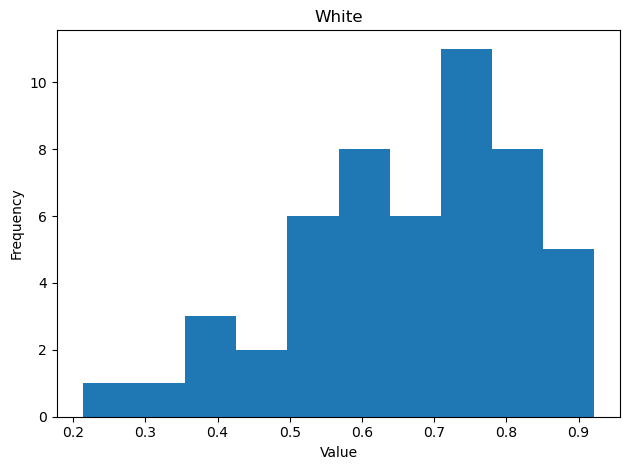

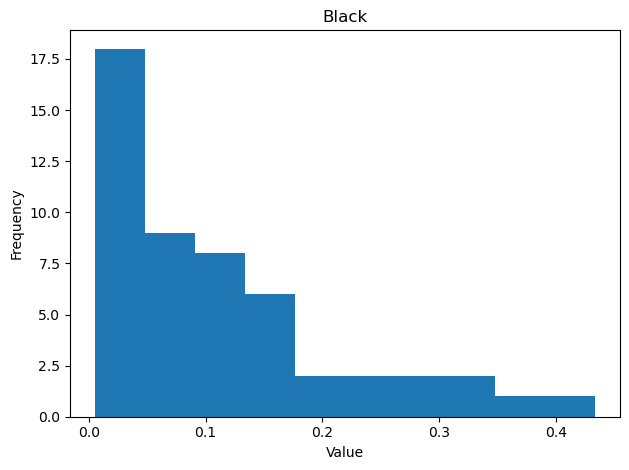

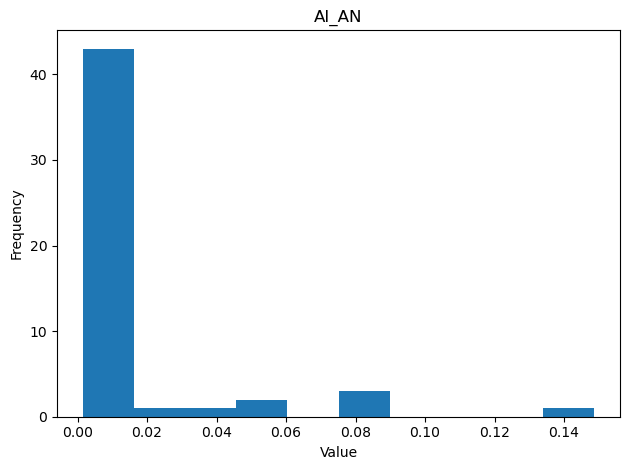

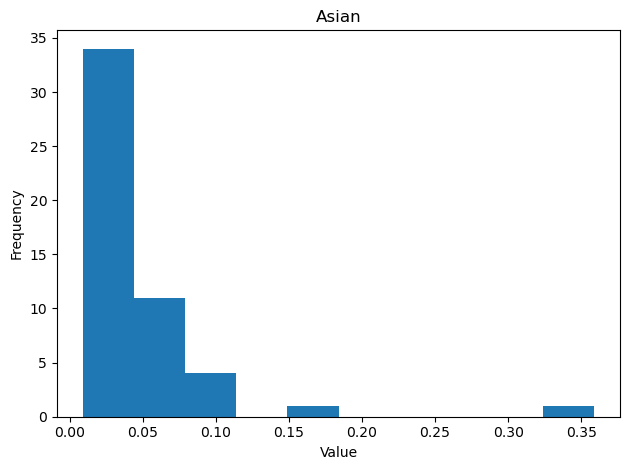

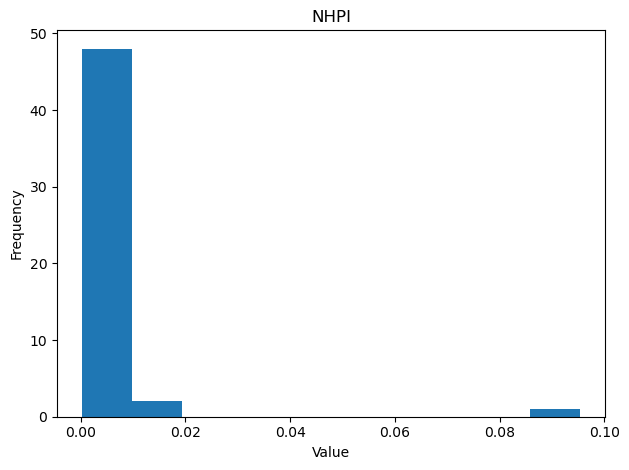

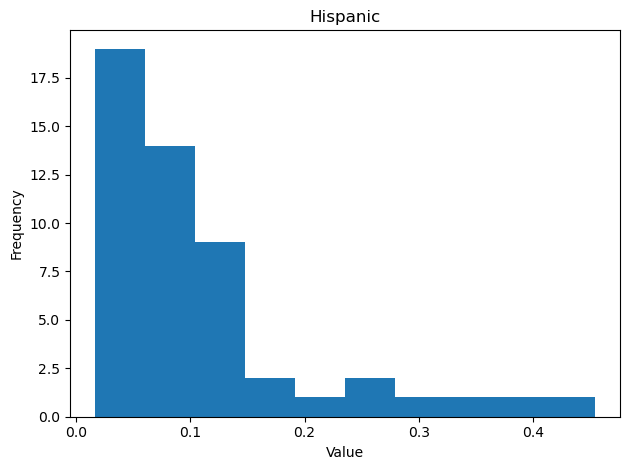

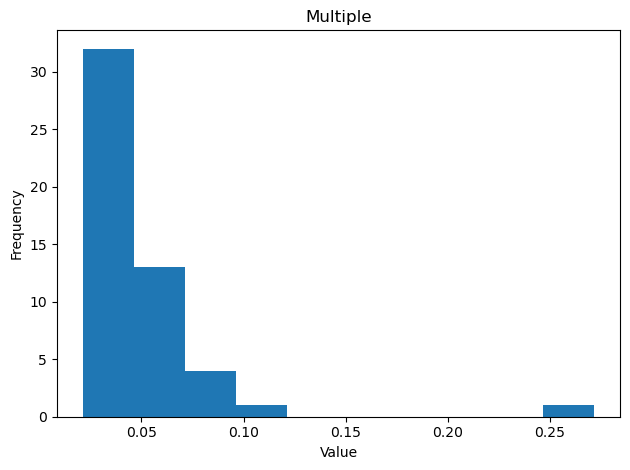

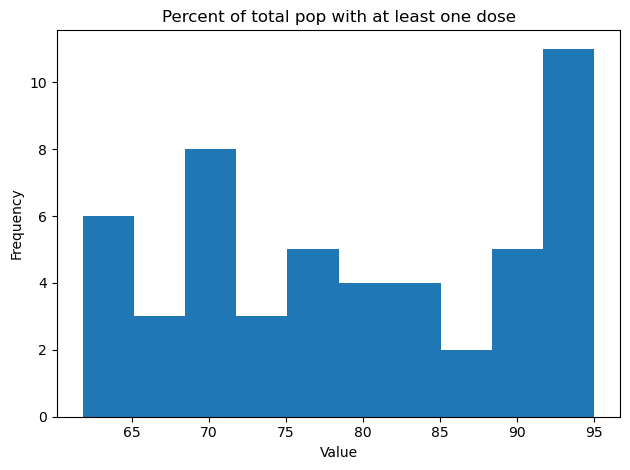

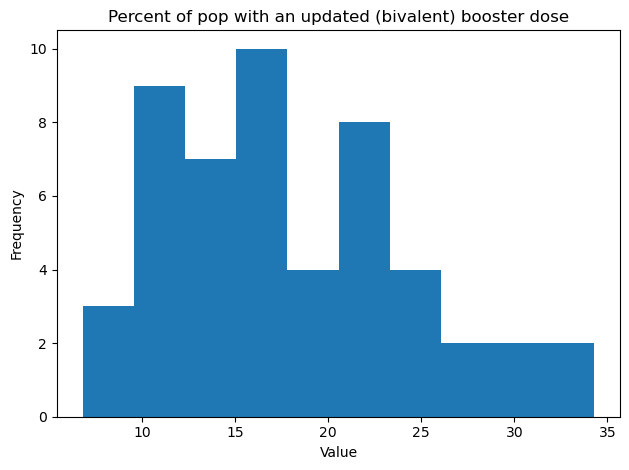

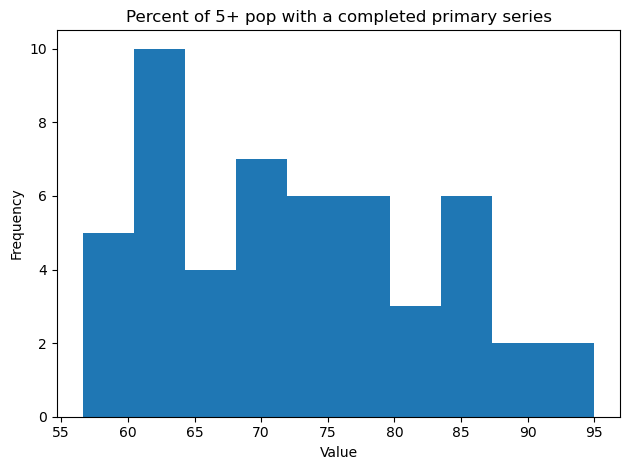

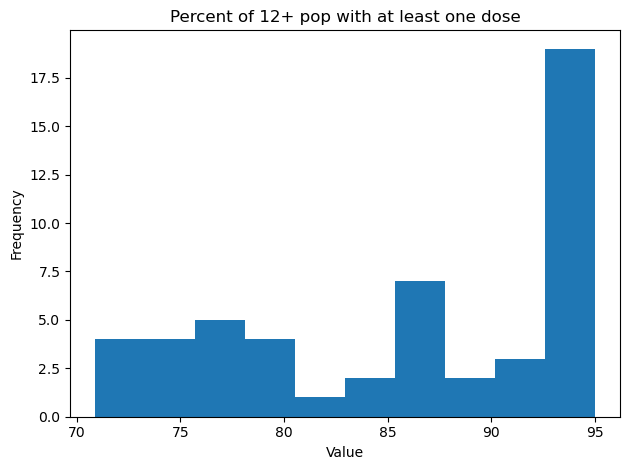

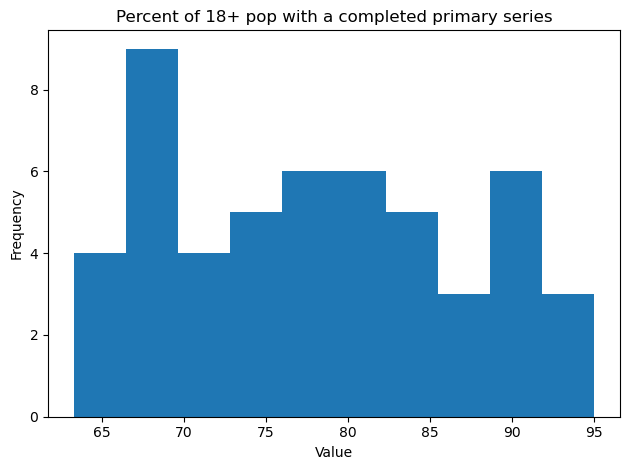

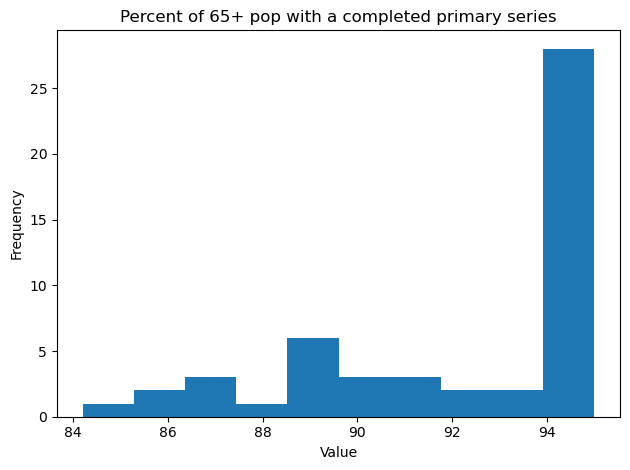

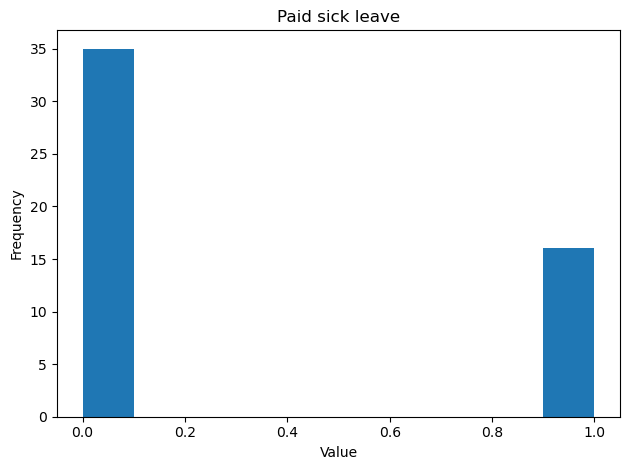

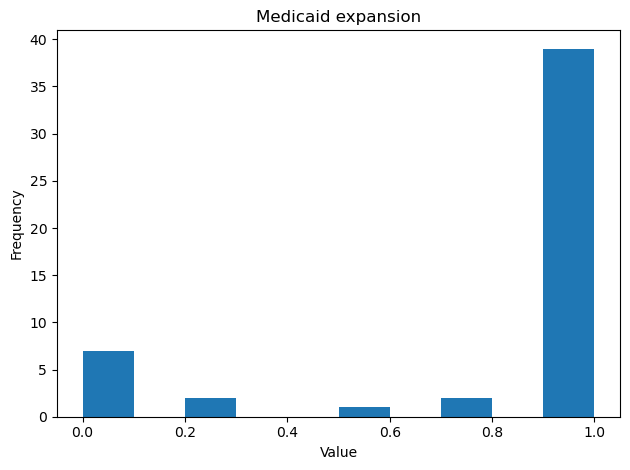

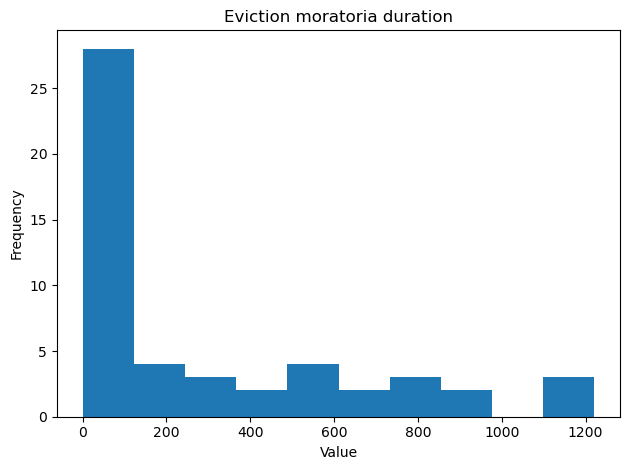

In [32]:
plot_hist(df_variables)

Scatter plots of predictor variables vs Avg Long COVID Rate

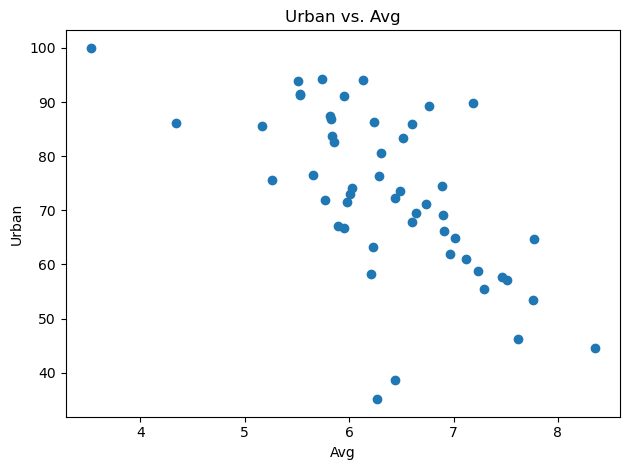

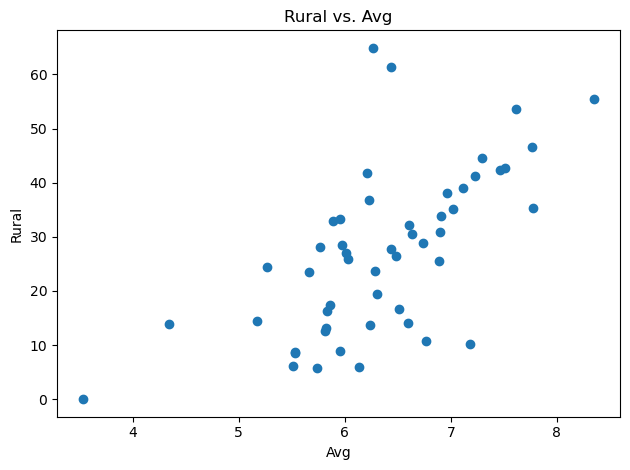

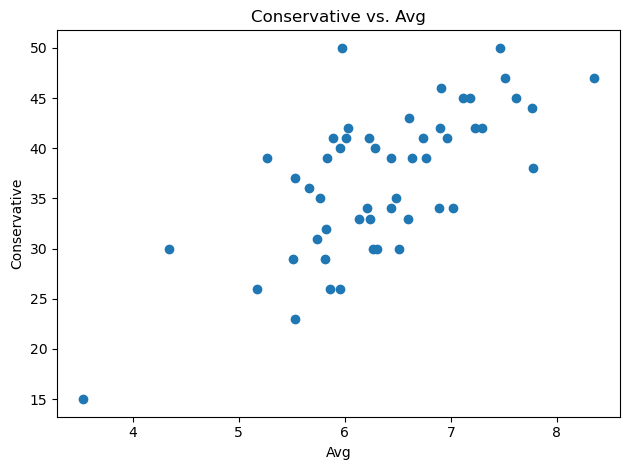

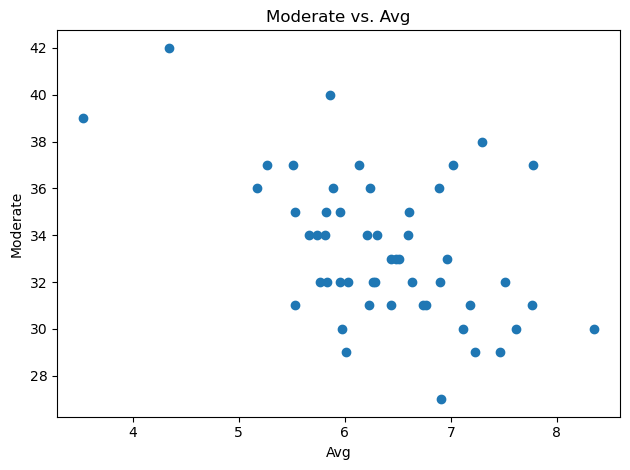

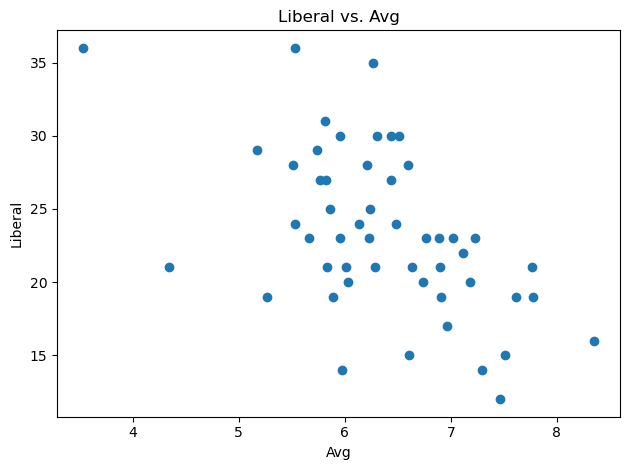

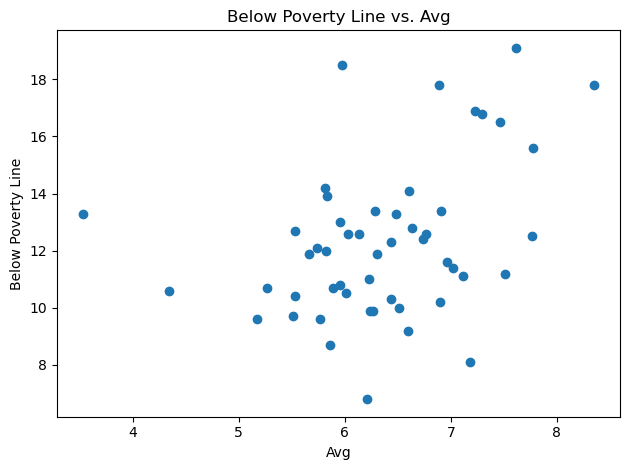

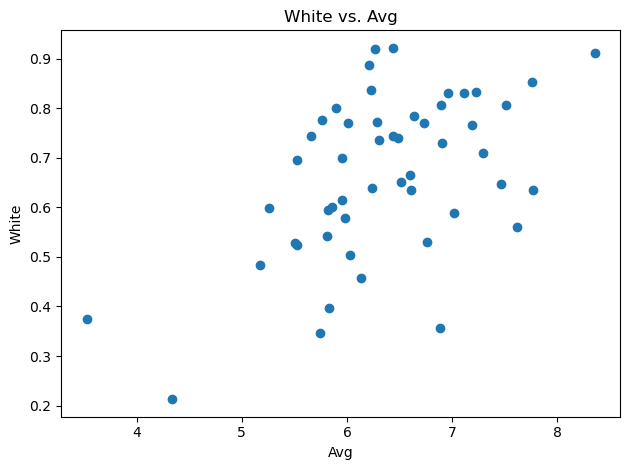

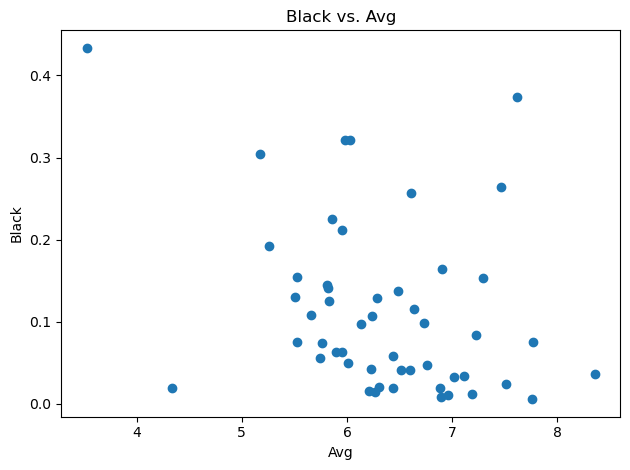

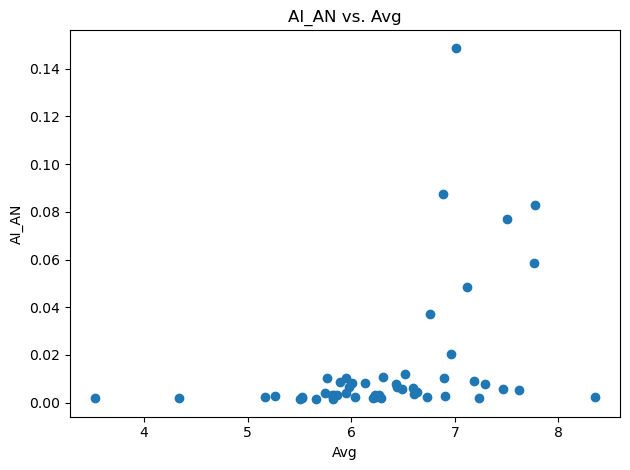

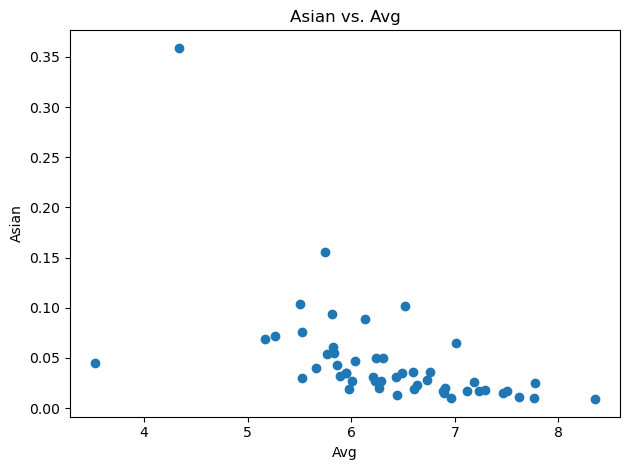

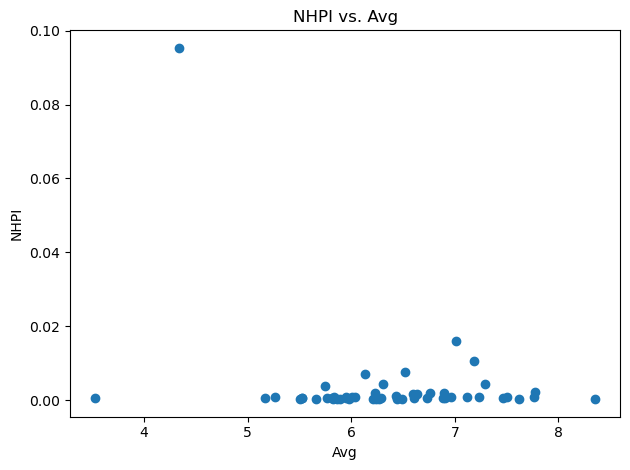

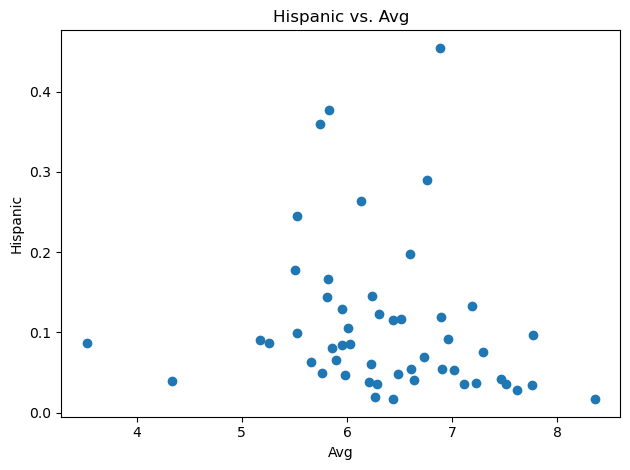

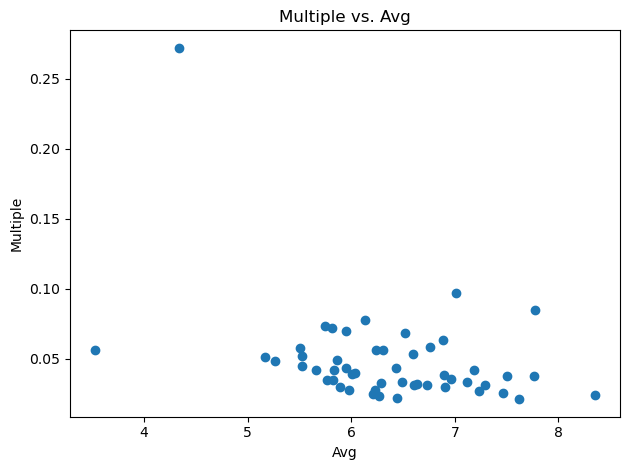

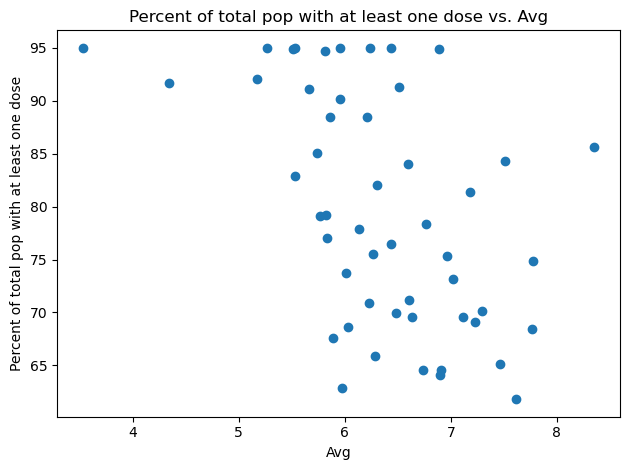

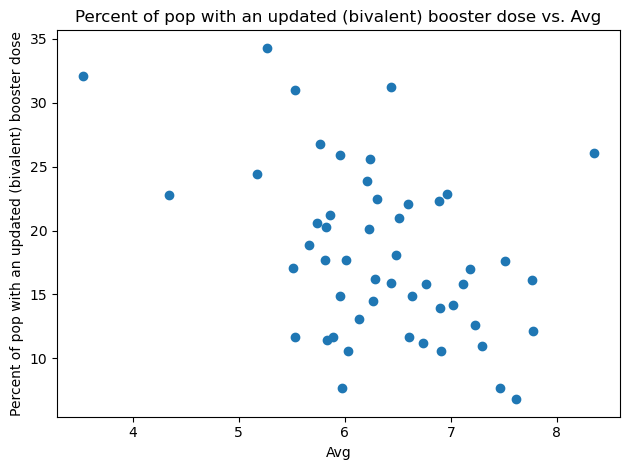

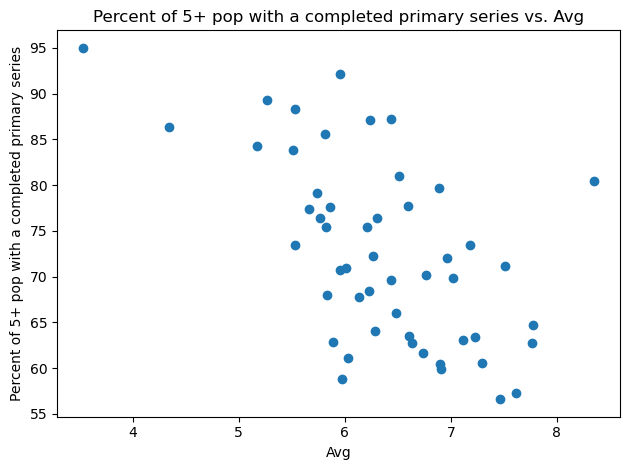

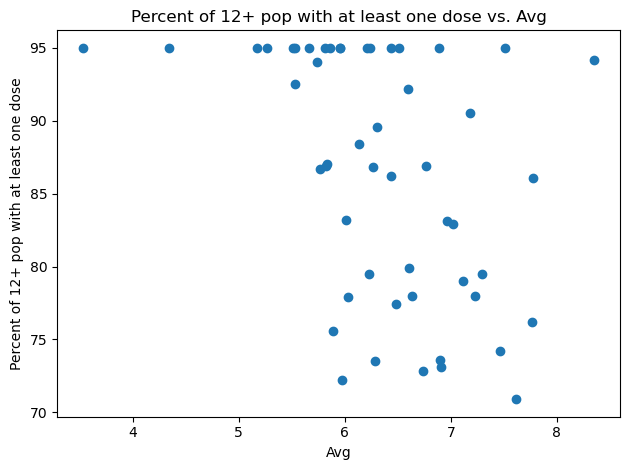

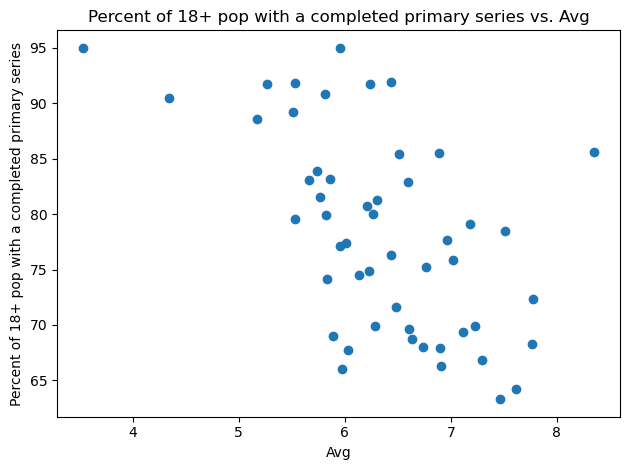

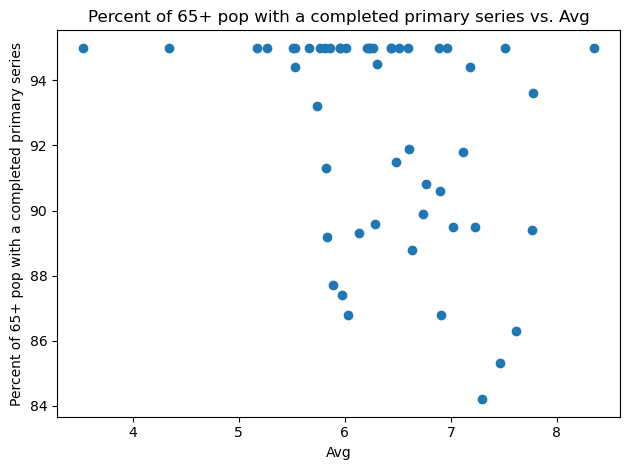

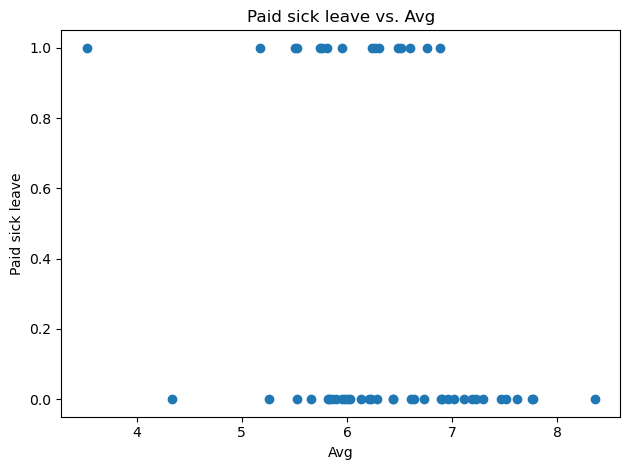

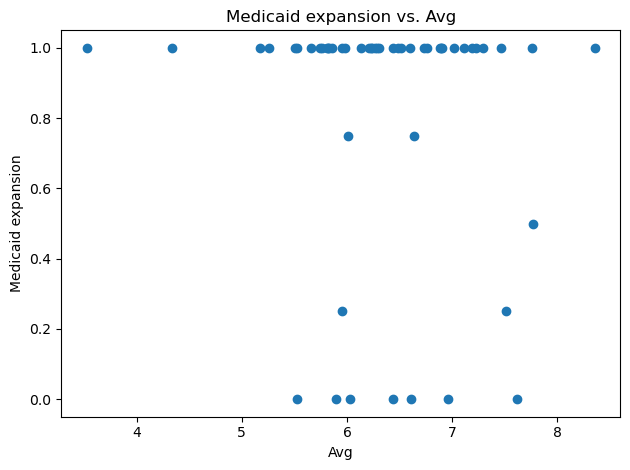

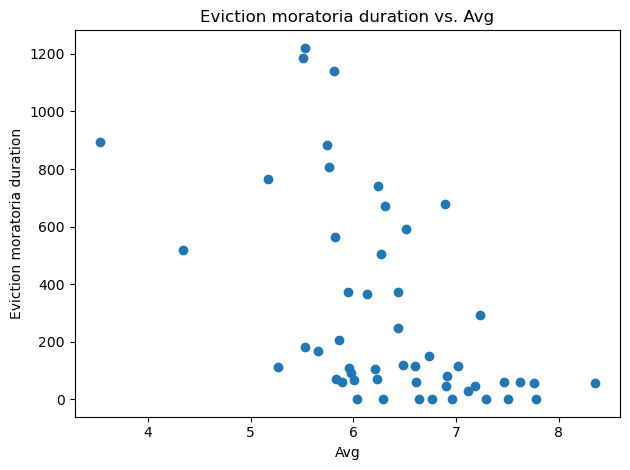

In [33]:
plot_scatter(
    df_target=lc_rates,
    df_variables=df_variables,
    col_target='Avg'
)

## Investigate correlations between predictor variables
- Are there any multicollinearities?

Correlation matrix of all variables vs eachother

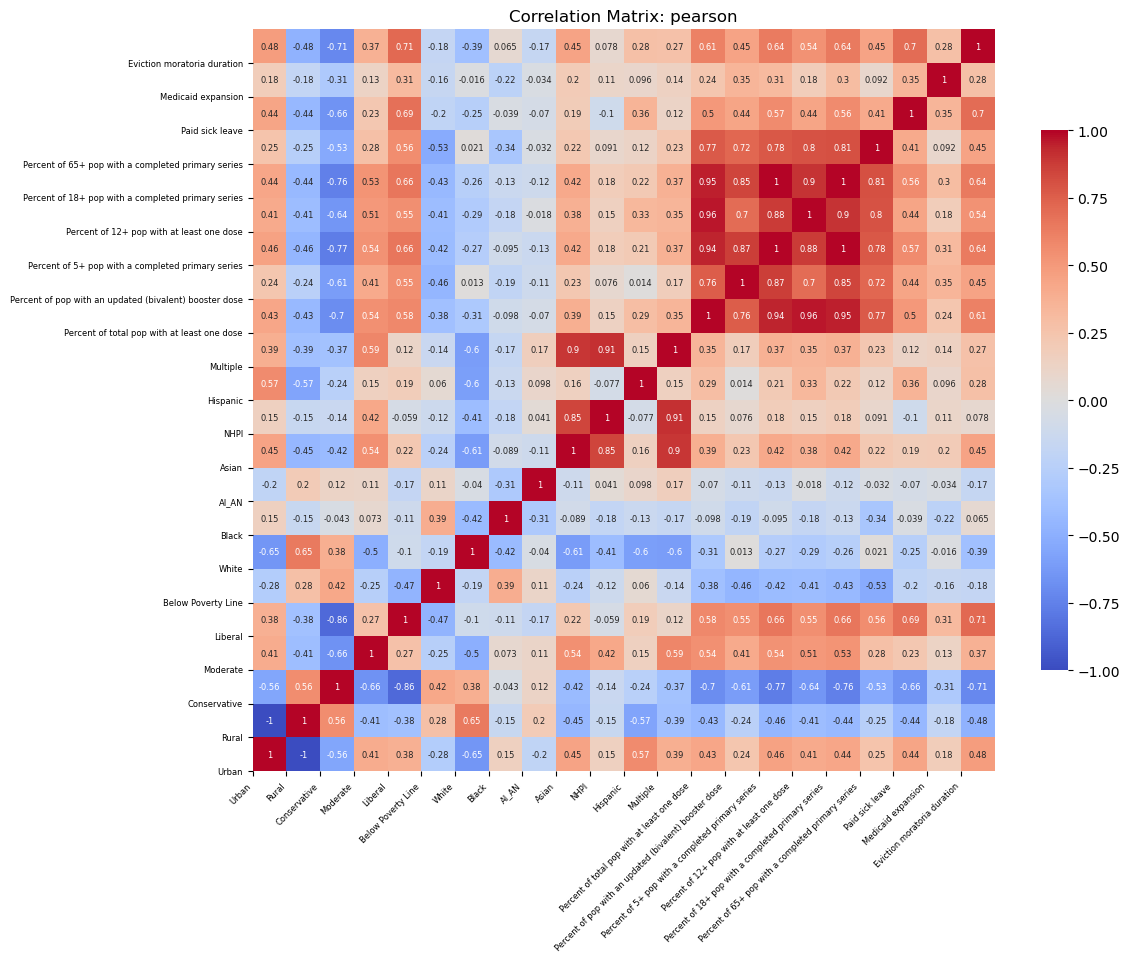

In [34]:
plot_correlation_matrix(
    df_variables,
    method='pearson', 
    plot_title="Correlation Matrix",
    corr_label_size=6,
    axis_label_size=6,
    fig_size=(12, 12),
    save_image=False,
    image_path="results/data_exploration/v11_correlation_matrix_pearson.png"
)

Calculate the correlations between all of the variables and sort by strongest correlation value.

In [35]:
df_variable_correlations = calc_variable_correlations(df_variables)

In [36]:
df_variable_correlations.head(25)

Variable 1  \
0                                                    Urban   
1        Percent of 5+ pop with a completed primary series   
2              Percent of total pop with at least one dose   
3              Percent of total pop with at least one dose   
4              Percent of total pop with at least one dose   
5                                                     NHPI   
6                Percent of 12+ pop with at least one dose   
7                                                    Asian   
8        Percent of 5+ pop with a completed primary series   
9   Percent of pop with an updated (bivalent) booster dose   
10                                            Conservative   
11  Percent of pop with an updated (bivalent) booster dose   
12                                                   Asian   
13      Percent of 18+ pop with a completed primary series   
14               Percent of 12+ pop with at least one dose   
15       Percent of 5+ pop with a completed primary series   
16             Percent of total pop with at least one dose   
17                                            Conservative   
18             Percent of total pop with at least one dose   
19                                            Conservative   
20  Percent of pop with an updated (bivalent) booster dose   
21                                            Conservative   
22                                                 Liberal   
23                                         Paid sick leave   
24  Percent of pop with an updated (bivalent) booster dose   

                                                Variable 2  Correlation  
0                                                    Rural    -1.000000  
1       Percent of 18+ pop with a completed primary series     0.995641  
2                Percent of 12+ pop with at least one dose     0.963621  
3       Percent of 18+ pop with a completed primary series     0.948288  
4        Percent of 5+ pop with a completed primary series     0.938736  
5                                                 Multiple     0.912195  
6       Percent of 18+ pop with a completed primary series     0.898557  
7                                                 Multiple     0.898128  
8                Percent of 12+ pop with at least one dose     0.878239  
9        Percent of 5+ pop with a completed primary series     0.868636  
10                                                 Liberal    -0.863012  
11      Percent of 18+ pop with a completed primary series     0.849729  
12                                                    NHPI     0.849508  
13      Percent of 65+ pop with a completed primary series     0.805731  
14      Percent of 65+ pop with a completed primary series     0.801447  
15      Percent of 65+ pop with a completed primary series     0.775835  
16      Percent of 65+ pop with a completed primary series     0.773371  
17       Percent of 5+ pop with a completed primary series    -0.768691  
18  Percent of pop with an updated (bivalent) booster dose     0.763978  
19      Percent of 18+ pop with a completed primary series    -0.756791  
20      Percent of 65+ pop with a completed primary series     0.723275  
21                             Eviction moratoria duration    -0.714458  
22                             Eviction moratoria duration     0.711927  
23                             Eviction moratoria duration     0.700542  
24               Percent of 12+ pop with at least one dose     0.695735

## Pair down variables given multicollinearities

Types of correlations considered: 

- Pearson Correlation:
    - Primarily measures the strength of a linear relationship between two variables.   
- Spearman Correlation:
    - Measures the strength of a monotonic relationship between two variables.
    - As one variable increases, the other variable either consistently increases or consistently decreases.   
    - This can include non-linear trends like curves or S-shapes.

Chose pearson for simplicity, and given the correlation matrix, chose a threshold of 0.65 for removal. 

The removal of variables was based on both the strength of multicollinearity as well as the strength of the collinear variable's correlation to the target variable.

In [37]:
removed_variables_list, df_variables_cleaned = calc_variable_correlations_with_removal_lc_rates(
    df=df_variables, 
    target_var=pd.Series(lc_rates['Avg']),
    method='pearson',
    threshold = 0.65
)

corr_var_target["Urban"]: -0.6276044523367557
corr_var_target["Rural"]: 0.6276044523367558
corr_var_target["Liberal"]: -0.5358645203463257
corr_var_target["Conservative"]: 0.6867807840225538


Inspect which predictor variables were removed from the predictor variables dataframe

In [38]:
removed_variables_list

['Eviction moratoria duration',
 'Percent of total pop with at least one dose',
 'Percent of 5+ pop with a completed primary series',
 'Paid sick leave',
 'Urban',
 'NHPI',
 'Percent of 65+ pop with a completed primary series',
 'Moderate',
 'Percent of pop with an updated (bivalent) booster dose',
 'Percent of 18+ pop with a completed primary series',
 'Percent of 12+ pop with at least one dose',
 'Multiple',
 'Liberal']

Inspect which predictor variables remain after the thresholding was applied

In [39]:
for col in df_variables_cleaned.columns:
    print(col) 

Rural
Conservative
Below Poverty Line
White
Black
AI_AN
Asian
Hispanic
Medicaid expansion


### Incorporate Prior Knowledge to reintroduce significant predictor variables

Based off of prior knowledge, we know that race should not be excluded from the analysis, so those variables are added back into the predictor variable dataframe.

In [40]:
# Which predictor variables were removed and need to be reintroduced?
prior_knowledge_cols = [
    'NHPI',
    'Multiple'
]

# Select the specified columns from df_variables
df_var_subset = df_variables[prior_knowledge_cols]

# Concatenate df_variables_cleaned and df_variables along the columns (axis=1)
df_variables_final = pd.concat([df_variables_cleaned, df_var_subset], axis=1)

Inspect the final predictor variable dataframe columns

In [41]:
for col in df_variables_final.columns:
    print(col) 

Rural
Conservative
Below Poverty Line
White
Black
AI_AN
Asian
Hispanic
Medicaid expansion
NHPI
Multiple


---
# Bayesian Variable Selection: Hyperparameter Optimization
---

## Variable Sensitivity Analysis - Hyperparameter Tuning using Optuna

Optuna hyperparameter optimization samplers: https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
Optuna AutoSampler: https://medium.com/optuna/autosampler-automatic-selection-of-optimization-algorithms-in-optuna-1443875fd8f9

"AutoSampler automatically selects a sampler from those implemented in Optuna, depending on the situation... AutoSampler is equipped with sampler selection rules designed to achieve the following two points and automatically and dynamically selects suitable samplers during optimization.

Automatically selects a sampler that can appropriately handle problems with different settings by considering the number of evaluations, search space, constraints, and the number of objectives...

Automatically selects a sampler that empirically achieves equivalent or better search results than always using Optuna’s default sampler."

### Optuna Search Space

1. alpha_sigma and beta_sigma (Gamma Distribution Parameters for sigma)

- alpha_sigma:
    - Typical Range:
        - 1.0 to 5.0 (or even higher, depending on the expected noise level)
    - Rationale:
        - alpha_sigma controls the "shape" of the Gamma distribution for sigma.
        - Higher values tend to concentrate the distribution towards lower values of sigma, implying less noise in the data.
        - Lower values allow for a wider range of possible noise levels.

- beta_sigma:
    - Typical Range:
        - 0.1 to 1.0 (or higher)
    - Rationale:
        - beta_sigma controls the "scale" of the Gamma distribution for sigma.
        - Higher values allow for larger standard deviations (more noise) in the data.
        - Lower values restrict the possible noise levels to a smaller range.

2. sigma (Noise Standard Deviation)
    - Typical Range:
        - 0.1 to 5.0 (or wider depending on the expected noise scale in your data)
    - Rationale:
        - sigma directly influences the model's assumption about the noise in the data.
        - A narrower range can be used if you expect the noise level to be relatively low.
        - A wider range is necessary if you expect significant noise in the data.

3. prob_of_success (Prior Probability of Feature Inclusion)
    - Typical Range:
        - 0.01 to 0.5 (or even lower depending on the expected sparsity of the model)
    - Rationale:
        - prob_of_success controls the prior probability of each feature being included in the model.
        - Lower values (e.g., 0.01-0.1) encourage sparsity, meaning the model will tend to select fewer features.
        - Higher values (e.g., 0.3-0.5) allow for more features to be included in the model.
        - Important Considerations:

- Data-Driven Approach:
    - These ranges are just general guidelines. The optimal ranges for your specific problem will depend on the characteristics of your data (e.g., noise level, number of features, sparsity).
- Prior Knowledge:
    - If you have any prior knowledge about the expected noise level or the sparsity of the true model, you can use that information to - inform your initial range choices.
- Exploratory Analysis:
    - Start with a reasonable initial range for each hyperparameter. Then, use techniques like Optuna's automatic hyperparameter tuning to explore the search space more effectively and find the best combination of hyperparameters for your specific problem.

Select the Optuna hyperparameter search space values for the optimization trials.

In [111]:
model_params_optuna = {
    "mu": 0, # Typical value 0
    "draws": 5000, # Defaults to 2000 in pm
    "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
    'alpha_sigma_start': 1.0,  # shape of the Gamma distribution for the STD of the noise
    'alpha_sigma_stop': 5.0,
    'alpha_sigma_step': 0.25,
    'beta_sigma_start': 0.1,  # scale of the Gamma distribution for the STD of the noise
    'beta_sigma_stop': 1.0,
    'beta_sigma_step': 0.1,
    'sigma_start': 1.0,  # STD of prior
    'sigma_stop': 5.0,
    'sigma_step': 0.25,
    'prob_of_success_start': 0.1,  # sparsity of model. lower value = the model selects fewer variables.
    'prob_of_success_stop': 0.5,
    'prob_of_success_step': 0.1, 
    "scale_predictors": True,
    "scale_function": "z-score",  # Function for scaling predictor variables
    "predictors_to_scale": [  # Predictor variables to scale
       "Rural",
       "Conservative",
       "Below Poverty Line",
       "White",
       "Black",
       "AI_AN",
       "NPHI",
       "Multiple"
       "Asian",
       "Hispanic",
       "Medicaid expansion",
    ],
    "cores": 4, # Number of CPUs
}

### Optuna Hyperparameter Optimization: Auto Sampler

In [112]:
best_params_AUTO_optuna = run_optuna_hyperparameter_optimization(
    df_variables=df_variables_final, 
    df_target=lc_rates['Avg'],
    model_params=model_params_optuna,
    n_trials=100,
    sampler_type="AUTO_SAMPLER",
    study_name="LC_hyperparam_optim_culled_vars_AUTO_5000draws" # Unique id of hyperparameters study.
)

[I 2025-01-27 16:35:07,256] A new study created in RDB with name: no-name-d6277bac-0f7c-4189-949a-58c285642065


A new study created in RDB with name: no-name-d6277bac-0f7c-4189-949a-58c285642065


  0%|          | 0/100 [00:00<?, ?it/s]

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 0 finished with value: -3.289916851354174 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 2.25, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.289916851354174.
[I 2025-01-27 16:35:55,053] Trial 0 finished with value: -3.289916851354174 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 2.25, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.289916851354174.


C:\Users\ashle\AppData\Local\optunahub\cache\api.github.com\optuna\optunahub-registry\main\package\samplers/auto_sampler\_sampler.py:173: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  return GPSampler(seed=seed)
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 1 finished with value: -3.3081473488746793 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.4, 'sigma': 4.0, 'prob_of_success': 0.5}. Best is trial 1 with value: -3.3081473488746793.
[I 2025-01-27 16:36:41,571] Trial 1 finished with value: -3.3081473488746793 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.4, 'sigma': 4.0, 'prob_of_success': 0.5}. Best is trial 1 with value: -3.3081473488746793.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 2 finished with value: -3.3118417860397975 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.7000000000000001, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 2 with value: -3.3118417860397975.
[I 2025-01-27 16:37:24,934] Trial 2 finished with value: -3.3118417860397975 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.7000000000000001, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 2 with value: -3.3118417860397975.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 3 finished with value: -3.308567321609536 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.5, 'sigma': 4.25, 'prob_of_success': 0.5}. Best is trial 2 with value: -3.3118417860397975.
[I 2025-01-27 16:38:13,887] Trial 3 finished with value: -3.308567321609536 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.5, 'sigma': 4.25, 'prob_of_success': 0.5}. Best is trial 2 with value: -3.3118417860397975.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 4 finished with value: -3.292804617834547 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.9, 'sigma': 2.25, 'prob_of_success': 0.2}. Best is trial 2 with value: -3.3118417860397975.
[I 2025-01-27 16:38:57,212] Trial 4 finished with value: -3.292804617834547 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.9, 'sigma': 2.25, 'prob_of_success': 0.2}. Best is trial 2 with value: -3.3118417860397975.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 5 finished with value: -3.312901416779831 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 5 with value: -3.312901416779831.
[I 2025-01-27 16:39:45,678] Trial 5 finished with value: -3.312901416779831 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 5 with value: -3.312901416779831.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 6 finished with value: -3.2987676121072695 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.4, 'sigma': 1.0, 'prob_of_success': 0.30000000000000004}. Best is trial 5 with value: -3.312901416779831.
[I 2025-01-27 16:40:22,702] Trial 6 finished with value: -3.2987676121072695 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.4, 'sigma': 1.0, 'prob_of_success': 0.30000000000000004}. Best is trial 5 with value: -3.312901416779831.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 7 finished with value: -3.3062045223523717 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.312901416779831.
[I 2025-01-27 16:41:03,928] Trial 7 finished with value: -3.3062045223523717 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.312901416779831.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 8 finished with value: -3.294348758362732 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4.0, 'prob_of_success': 0.30000000000000004}. Best is trial 5 with value: -3.312901416779831.
[I 2025-01-27 16:41:51,035] Trial 8 finished with value: -3.294348758362732 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4.0, 'prob_of_success': 0.30000000000000004}. Best is trial 5 with value: -3.312901416779831.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 9 finished with value: -3.289207467440465 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.9, 'sigma': 1.75, 'prob_of_success': 0.1}. Best is trial 5 with value: -3.312901416779831.
[I 2025-01-27 16:42:24,907] Trial 9 finished with value: -3.289207467440465 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.9, 'sigma': 1.75, 'prob_of_success': 0.1}. Best is trial 5 with value: -3.312901416779831.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 10 finished with value: -3.3054044572202796 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.2, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 5 with value: -3.312901416779831.
[I 2025-01-27 16:43:04,405] Trial 10 finished with value: -3.3054044572202796 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.2, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 5 with value: -3.312901416779831.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 11 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3196023568922186.
[I 2025-01-27 16:43:58,054] Trial 11 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3196023568922186.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 12 finished with value: -3.3192133309927434 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3196023568922186.
[I 2025-01-27 16:44:51,069] Trial 12 finished with value: -3.3192133309927434 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3196023568922186.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 13 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:45:43,194] Trial 13 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 14 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:46:36,234] Trial 14 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 15 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:47:29,437] Trial 15 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 16 finished with value: -3.3123826025551657 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:48:23,108] Trial 16 finished with value: -3.3123826025551657 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 17 finished with value: -3.304761454698495 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:48:56,558] Trial 17 finished with value: -3.304761454698495 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 18 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:49:41,208] Trial 18 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 19 finished with value: -3.287188001839612 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:50:13,815] Trial 19 finished with value: -3.287188001839612 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 20 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:51:05,002] Trial 20 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 21 finished with value: -3.3180114304461594 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:51:52,137] Trial 21 finished with value: -3.3180114304461594 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 22 finished with value: -3.3102050123667275 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:52:47,616] Trial 22 finished with value: -3.3102050123667275 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 23 finished with value: -3.3041836934485778 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:53:46,605] Trial 23 finished with value: -3.3041836934485778 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 24 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:54:37,623] Trial 24 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 25 finished with value: -3.305699192171354 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:55:25,287] Trial 25 finished with value: -3.305699192171354 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 26 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:56:17,065] Trial 26 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 27 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:57:09,412] Trial 27 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 28 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:58:01,976] Trial 28 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 29 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:58:53,912] Trial 29 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 30 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 16:59:45,561] Trial 30 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 31 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:00:37,178] Trial 31 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 32 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:01:29,152] Trial 32 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 33 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:02:20,568] Trial 33 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 34 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:03:12,170] Trial 34 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 35 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:04:04,842] Trial 35 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 36 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:04:55,920] Trial 36 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 37 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:05:47,796] Trial 37 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 38 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:06:39,678] Trial 38 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 39 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:07:32,436] Trial 39 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 40 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:08:23,382] Trial 40 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 41 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:09:14,313] Trial 41 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 42 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:10:06,336] Trial 42 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 43 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:10:58,995] Trial 43 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 44 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:11:50,568] Trial 44 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 45 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:12:43,281] Trial 45 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 46 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:13:35,871] Trial 46 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 47 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:14:26,186] Trial 47 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 48 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:15:17,114] Trial 48 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 49 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:16:09,073] Trial 49 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 50 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:16:59,926] Trial 50 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 51 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:17:52,226] Trial 51 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 52 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:18:43,641] Trial 52 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 53 finished with value: -3.3161356245069973 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.75, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:19:38,062] Trial 53 finished with value: -3.3161356245069973 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.75, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 54 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:20:29,546] Trial 54 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 55 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:21:21,560] Trial 55 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 56 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:22:12,797] Trial 56 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 57 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:23:04,889] Trial 57 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 58 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:23:56,647] Trial 58 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 59 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:24:47,012] Trial 59 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 60 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:25:38,612] Trial 60 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 61 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:26:30,691] Trial 61 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 62 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:27:22,461] Trial 62 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 63 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:28:15,738] Trial 63 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 64 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:29:06,527] Trial 64 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 65 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:29:59,332] Trial 65 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 66 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:30:50,860] Trial 66 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 67 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:31:42,844] Trial 67 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 68 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:32:34,702] Trial 68 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 69 finished with value: -3.3110379975012934 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:33:26,766] Trial 69 finished with value: -3.3110379975012934 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 70 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:34:17,431] Trial 70 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 71 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:35:09,386] Trial 71 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 72 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:36:02,056] Trial 72 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 73 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:36:55,047] Trial 73 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 74 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:37:46,546] Trial 74 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 75 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:38:37,600] Trial 75 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 76 finished with value: -3.3110296091557863 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:39:21,960] Trial 76 finished with value: -3.3110296091557863 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 77 finished with value: -3.3101035025432117 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:40:07,039] Trial 77 finished with value: -3.3101035025432117 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 78 finished with value: -3.2893374532197424 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:40:37,704] Trial 78 finished with value: -3.2893374532197424 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 79 finished with value: -3.308737992383608 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:41:21,513] Trial 79 finished with value: -3.308737992383608 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 80 finished with value: -3.305096371301037 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:42:11,087] Trial 80 finished with value: -3.305096371301037 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 81 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:43:02,505] Trial 81 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 82 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:43:55,302] Trial 82 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 83 finished with value: -3.2908790073155494 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 5.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:44:37,126] Trial 83 finished with value: -3.2908790073155494 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 5.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 84 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:45:28,133] Trial 84 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 85 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:46:18,450] Trial 85 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 86 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:47:08,825] Trial 86 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 87 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:48:00,828] Trial 87 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 88 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:48:52,291] Trial 88 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 89 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:49:44,467] Trial 89 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 90 finished with value: -3.2889436533085408 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:50:29,512] Trial 90 finished with value: -3.2889436533085408 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 91 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:51:20,958] Trial 91 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 92 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:52:11,747] Trial 92 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 93 finished with value: -3.303470121015019 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:52:59,226] Trial 93 finished with value: -3.303470121015019 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 94 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:53:51,105] Trial 94 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 95 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:54:42,409] Trial 95 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 96 finished with value: -3.292579095877321 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:55:22,974] Trial 96 finished with value: -3.292579095877321 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.1}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 97 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:56:14,756] Trial 97 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 98 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:57:05,834] Trial 98 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 99 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.
[I 2025-01-27 17:57:57,618] Trial 99 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 13 with value: -3.319827168001364.


### Optuna Hyperparameter Optimization: TPE Sampler

In [123]:
best_params_TPE_optuna = run_optuna_hyperparameter_optimization(
    df_variables=df_variables_final, 
    df_target=lc_rates['Avg'],
    model_params=model_params_optuna,
    n_trials=100,
    sampler_type="TPE",
    study_name="LC_hyperparam_optim_culled_vars_TPE_5000draws" # Unique id of hyperparameters study.
)

A new study created in RDB with name: no-name-58d2cc4e-f591-4c09-8661-458c77939e6c


[I 2025-01-27 21:04:08,516] A new study created in RDB with name: no-name-58d2cc4e-f591-4c09-8661-458c77939e6c


A new study created in RDB with name: no-name-58d2cc4e-f591-4c09-8661-458c77939e6c


  0%|          | 0/100 [00:00<?, ?it/s]

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 0 finished with value: -3.28769751083229 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.5, 'sigma': 4.25, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.28769751083229.
Trial 0 finished with value: -3.28769751083229 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.5, 'sigma': 4.25, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.28769751083229.
[I 2025-01-27 21:04:47,615] Trial 0 finished with value: -3.28769751083229 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.5, 'sigma': 4.25, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.28769751083229.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 1 finished with value: -3.289601172431038 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.4, 'sigma': 2.75, 'prob_of_success': 0.1}. Best is trial 1 with value: -3.289601172431038.
Trial 1 finished with value: -3.289601172431038 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.4, 'sigma': 2.75, 'prob_of_success': 0.1}. Best is trial 1 with value: -3.289601172431038.
[I 2025-01-27 21:05:22,406] Trial 1 finished with value: -3.289601172431038 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.4, 'sigma': 2.75, 'prob_of_success': 0.1}. Best is trial 1 with value: -3.289601172431038.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 2 finished with value: -3.299183933152215 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.2, 'sigma': 1.75, 'prob_of_success': 0.30000000000000004}. Best is trial 2 with value: -3.299183933152215.
Trial 2 finished with value: -3.299183933152215 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.2, 'sigma': 1.75, 'prob_of_success': 0.30000000000000004}. Best is trial 2 with value: -3.299183933152215.
[I 2025-01-27 21:06:08,210] Trial 2 finished with value: -3.299183933152215 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.2, 'sigma': 1.75, 'prob_of_success': 0.30000000000000004}. Best is trial 2 with value: -3.299183933152215.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 3 finished with value: -3.309878695806123 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 1.0, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.309878695806123.
Trial 3 finished with value: -3.309878695806123 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 1.0, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:07:14,411] Trial 3 finished with value: -3.309878695806123 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 1.0, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 4 finished with value: -3.291097184138742 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 1.0, 'sigma': 3.0, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.
Trial 4 finished with value: -3.291097184138742 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 1.0, 'sigma': 3.0, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:07:57,746] Trial 4 finished with value: -3.291097184138742 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 1.0, 'sigma': 3.0, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 5 finished with value: -3.298421200244257 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.30000000000000004}. Best is trial 3 with value: -3.309878695806123.
Trial 5 finished with value: -3.298421200244257 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.30000000000000004}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:08:40,878] Trial 5 finished with value: -3.298421200244257 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.30000000000000004}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 6 finished with value: -3.2933763661210156 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.7000000000000001, 'sigma': 1.25, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.
Trial 6 finished with value: -3.2933763661210156 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.7000000000000001, 'sigma': 1.25, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:09:22,157] Trial 6 finished with value: -3.2933763661210156 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.7000000000000001, 'sigma': 1.25, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 7 finished with value: -3.293922414735948 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.
Trial 7 finished with value: -3.293922414735948 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:09:59,263] Trial 7 finished with value: -3.293922414735948 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 8 finished with value: -3.2939278314950093 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.9, 'sigma': 4.0, 'prob_of_success': 0.30000000000000004}. Best is trial 3 with value: -3.309878695806123.
Trial 8 finished with value: -3.2939278314950093 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.9, 'sigma': 4.0, 'prob_of_success': 0.30000000000000004}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:10:47,661] Trial 8 finished with value: -3.2939278314950093 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.9, 'sigma': 4.0, 'prob_of_success': 0.30000000000000004}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 9 finished with value: -3.306623597643947 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 3 with value: -3.309878695806123.
Trial 9 finished with value: -3.306623597643947 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:11:31,368] Trial 9 finished with value: -3.306623597643947 and parameters: {'alpha_sigma': 1.75, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 10 finished with value: -3.3042842925100158 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.7000000000000001, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.309878695806123.
Trial 10 finished with value: -3.3042842925100158 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.7000000000000001, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.309878695806123.
[I 2025-01-27 21:12:23,877] Trial 10 finished with value: -3.3042842925100158 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.7000000000000001, 'sigma': 5.0, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.309878695806123.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 11 finished with value: -3.3135472998981883 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 11 finished with value: -3.3135472998981883 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:13:10,794] Trial 11 finished with value: -3.3135472998981883 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 12 finished with value: -3.3108283586324276 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 12 finished with value: -3.3108283586324276 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:14:06,938] Trial 12 finished with value: -3.3108283586324276 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 13 finished with value: -3.304199837848204 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
Trial 13 finished with value: -3.304199837848204 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:14:57,515] Trial 13 finished with value: -3.304199837848204 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 14 finished with value: -3.3078731177731124 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.6, 'sigma': 3.75, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 14 finished with value: -3.3078731177731124 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.6, 'sigma': 3.75, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:15:52,367] Trial 14 finished with value: -3.3078731177731124 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.6, 'sigma': 3.75, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 15 finished with value: -3.3007331257617523 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.8, 'sigma': 1.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
Trial 15 finished with value: -3.3007331257617523 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.8, 'sigma': 1.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:16:32,902] Trial 15 finished with value: -3.3007331257617523 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.8, 'sigma': 1.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 16 finished with value: -3.308759759425792 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.5, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 16 finished with value: -3.308759759425792 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.5, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:17:33,293] Trial 16 finished with value: -3.308759759425792 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.5, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 17 finished with value: -3.305608760553243 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.4, 'sigma': 2.25, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
Trial 17 finished with value: -3.305608760553243 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.4, 'sigma': 2.25, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:18:16,380] Trial 17 finished with value: -3.305608760553243 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.4, 'sigma': 2.25, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 18 finished with value: -3.3093922784650243 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.6, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 18 finished with value: -3.3093922784650243 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.6, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:19:00,241] Trial 18 finished with value: -3.3093922784650243 and parameters: {'alpha_sigma': 2.25, 'beta_sigma': 0.6, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 19 finished with value: -3.304292194157496 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
Trial 19 finished with value: -3.304292194157496 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:19:49,266] Trial 19 finished with value: -3.304292194157496 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 20 finished with value: -3.3096001504507644 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 20 finished with value: -3.3096001504507644 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:20:48,227] Trial 20 finished with value: -3.3096001504507644 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 21 finished with value: -3.3083894707472847 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 1.0, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 21 finished with value: -3.3083894707472847 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 1.0, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:21:50,538] Trial 21 finished with value: -3.3083894707472847 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 1.0, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 22 finished with value: -3.3104240710000803 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.9, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 22 finished with value: -3.3104240710000803 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.9, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:22:49,970] Trial 22 finished with value: -3.3104240710000803 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.9, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 23 finished with value: -3.30423997412604 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 1.75, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
Trial 23 finished with value: -3.30423997412604 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 1.75, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:23:42,234] Trial 23 finished with value: -3.30423997412604 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 1.75, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 24 finished with value: -3.31016246373994 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.9, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 24 finished with value: -3.31016246373994 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.9, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:24:36,450] Trial 24 finished with value: -3.31016246373994 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.9, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 25 finished with value: -3.3040904974781697 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.9, 'sigma': 1.75, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
Trial 25 finished with value: -3.3040904974781697 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.9, 'sigma': 1.75, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:25:27,183] Trial 25 finished with value: -3.3040904974781697 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.9, 'sigma': 1.75, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 26 finished with value: -3.310158319830336 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.6, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 26 finished with value: -3.310158319830336 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.6, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:26:15,277] Trial 26 finished with value: -3.310158319830336 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.6, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 27 finished with value: -3.3032452283829232 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.8, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
Trial 27 finished with value: -3.3032452283829232 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.8, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:27:12,336] Trial 27 finished with value: -3.3032452283829232 and parameters: {'alpha_sigma': 1.25, 'beta_sigma': 0.8, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 28 finished with value: -3.3111861134540987 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.4, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 28 finished with value: -3.3111861134540987 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.4, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:27:57,147] Trial 28 finished with value: -3.3111861134540987 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.4, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 29 finished with value: -3.28930073624995 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.4, 'sigma': 1.0, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.3135472998981883.
Trial 29 finished with value: -3.28930073624995 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.4, 'sigma': 1.0, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:28:30,947] Trial 29 finished with value: -3.28930073624995 and parameters: {'alpha_sigma': 2.75, 'beta_sigma': 0.4, 'sigma': 1.0, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 30 finished with value: -3.3128047975426544 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 30 finished with value: -3.3128047975426544 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:29:14,091] Trial 30 finished with value: -3.3128047975426544 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 31 finished with value: -3.3108808996319063 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 31 finished with value: -3.3108808996319063 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:29:57,848] Trial 31 finished with value: -3.3108808996319063 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 32 finished with value: -3.3107901942135887 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
Trial 32 finished with value: -3.3107901942135887 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.
[I 2025-01-27 21:30:41,537] Trial 32 finished with value: -3.3107901942135887 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.3135472998981883.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 33 finished with value: -3.314224476020558 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 33 finished with value: -3.314224476020558 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:31:25,345] Trial 33 finished with value: -3.314224476020558 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Trial 34 finished with value: -3.309018780858204 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 1.5, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.
Trial 34 finished with value: -3.309018780858204 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 1.5, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:32:12,710] Trial 34 finished with value: -3.309018780858204 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 1.5, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 35 finished with value: -3.312721495452322 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 35 finished with value: -3.312721495452322 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:32:56,431] Trial 35 finished with value: -3.312721495452322 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 36 finished with value: -3.3015193438237667 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.2, 'sigma': 1.75, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.314224476020558.
Trial 36 finished with value: -3.3015193438237667 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.2, 'sigma': 1.75, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:33:40,397] Trial 36 finished with value: -3.3015193438237667 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.2, 'sigma': 1.75, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 37 finished with value: -3.309561942848641 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 37 finished with value: -3.309561942848641 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:34:31,458] Trial 37 finished with value: -3.309561942848641 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 38 finished with value: -3.306445397397027 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.
Trial 38 finished with value: -3.306445397397027 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:35:14,733] Trial 38 finished with value: -3.306445397397027 and parameters: {'alpha_sigma': 3.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Trial 39 finished with value: -3.2934112567792804 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.5, 'sigma': 1.75, 'prob_of_success': 0.2}. Best is trial 33 with value: -3.314224476020558.
Trial 39 finished with value: -3.2934112567792804 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.5, 'sigma': 1.75, 'prob_of_success': 0.2}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:35:54,497] Trial 39 finished with value: -3.2934112567792804 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.5, 'sigma': 1.75, 'prob_of_success': 0.2}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 40 finished with value: -3.2907915025670573 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.314224476020558.
Trial 40 finished with value: -3.2907915025670573 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:36:32,934] Trial 40 finished with value: -3.2907915025670573 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 41 finished with value: -3.3110218601943737 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.4, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 41 finished with value: -3.3110218601943737 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.4, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:37:16,883] Trial 41 finished with value: -3.3110218601943737 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.4, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 42 finished with value: -3.3105968655231086 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 42 finished with value: -3.3105968655231086 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:37:59,458] Trial 42 finished with value: -3.3105968655231086 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 43 finished with value: -3.305733731363544 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.4, 'sigma': 4.75, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 43 finished with value: -3.305733731363544 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.4, 'sigma': 4.75, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:38:50,463] Trial 43 finished with value: -3.305733731363544 and parameters: {'alpha_sigma': 3.25, 'beta_sigma': 0.4, 'sigma': 4.75, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 44 finished with value: -3.31409829665247 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 44 finished with value: -3.31409829665247 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:39:33,798] Trial 44 finished with value: -3.31409829665247 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.30000000000000004, 'sigma': 1.5, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 45 finished with value: -3.312968969166941 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
Trial 45 finished with value: -3.312968969166941 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:40:27,149] Trial 45 finished with value: -3.312968969166941 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 1.25, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 46 finished with value: -3.3012068560251477 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.314224476020558.
Trial 46 finished with value: -3.3012068560251477 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:41:20,777] Trial 46 finished with value: -3.3012068560251477 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.0, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 47 finished with value: -3.3070679180487796 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 1.25, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.
Trial 47 finished with value: -3.3070679180487796 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 1.25, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.
[I 2025-01-27 21:42:08,688] Trial 47 finished with value: -3.3070679180487796 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 1.25, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.314224476020558.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 48 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 48 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:43:07,377] Trial 48 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 49 finished with value: -3.3192133309927434 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 49 finished with value: -3.3192133309927434 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:44:07,904] Trial 49 finished with value: -3.3192133309927434 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 50 finished with value: -3.3099813146452592 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.
Trial 50 finished with value: -3.3099813146452592 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:44:55,121] Trial 50 finished with value: -3.3099813146452592 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 51 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 51 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:45:56,071] Trial 51 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 52 finished with value: -3.3188644746417952 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 52 finished with value: -3.3188644746417952 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:46:55,523] Trial 52 finished with value: -3.3188644746417952 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Trial 53 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 53 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:47:54,419] Trial 53 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 54 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 54 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:48:54,970] Trial 54 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 55 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 55 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:49:55,026] Trial 55 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 56 finished with value: -3.3170866919662485 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 56 finished with value: -3.3170866919662485 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:50:54,199] Trial 56 finished with value: -3.3170866919662485 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 57 finished with value: -3.317610902139635 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 57 finished with value: -3.317610902139635 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:51:49,947] Trial 57 finished with value: -3.317610902139635 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 58 finished with value: -3.316346706695929 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 58 finished with value: -3.316346706695929 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:52:50,909] Trial 58 finished with value: -3.316346706695929 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 59 finished with value: -3.3062670871699393 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.2, 'sigma': 3.0, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.
Trial 59 finished with value: -3.3062670871699393 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.2, 'sigma': 3.0, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:53:41,510] Trial 59 finished with value: -3.3062670871699393 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.2, 'sigma': 3.0, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 60 finished with value: -3.316348176975469 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 60 finished with value: -3.316348176975469 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:54:44,057] Trial 60 finished with value: -3.316348176975469 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 61 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 61 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:55:44,772] Trial 61 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 62 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 62 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:56:44,622] Trial 62 finished with value: -3.3187737768388867 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.75, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 63 finished with value: -3.318165617702537 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 63 finished with value: -3.318165617702537 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:57:45,727] Trial 63 finished with value: -3.318165617702537 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 64 finished with value: -3.3176365320543075 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 64 finished with value: -3.3176365320543075 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:58:35,940] Trial 64 finished with value: -3.3176365320543075 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 65 finished with value: -3.296651352901784 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.2}. Best is trial 48 with value: -3.31938823614359.
Trial 65 finished with value: -3.296651352901784 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.2}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 21:59:28,462] Trial 65 finished with value: -3.296651352901784 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.2}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 66 finished with value: -3.3075049617003813 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.2, 'sigma': 2.75, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.
Trial 66 finished with value: -3.3075049617003813 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.2, 'sigma': 2.75, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:00:19,254] Trial 66 finished with value: -3.3075049617003813 and parameters: {'alpha_sigma': 4.25, 'beta_sigma': 0.2, 'sigma': 2.75, 'prob_of_success': 0.4}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 67 finished with value: -3.3191896992950167 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 67 finished with value: -3.3191896992950167 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:01:20,669] Trial 67 finished with value: -3.3191896992950167 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 68 finished with value: -3.318097389391704 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 68 finished with value: -3.318097389391704 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:02:21,773] Trial 68 finished with value: -3.318097389391704 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 3.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 69 finished with value: -3.316348176975469 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 69 finished with value: -3.316348176975469 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:03:23,528] Trial 69 finished with value: -3.316348176975469 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 3.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 70 finished with value: -3.317393951762879 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 70 finished with value: -3.317393951762879 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:04:18,699] Trial 70 finished with value: -3.317393951762879 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 3.0, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 71 finished with value: -3.3188982641406852 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 71 finished with value: -3.3188982641406852 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:05:16,225] Trial 71 finished with value: -3.3188982641406852 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 72 finished with value: -3.319140091515081 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 72 finished with value: -3.319140091515081 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:06:17,533] Trial 72 finished with value: -3.319140091515081 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 73 finished with value: -3.317652166265949 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
Trial 73 finished with value: -3.317652166265949 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.
[I 2025-01-27 22:07:07,056] Trial 73 finished with value: -3.317652166265949 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 48 with value: -3.31938823614359.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 74 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 74 with value: -3.3196023568922186.
Trial 74 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 74 with value: -3.3196023568922186.
[I 2025-01-27 22:08:06,961] Trial 74 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 74 with value: -3.3196023568922186.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 75 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 74 with value: -3.3196023568922186.
Trial 75 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 74 with value: -3.3196023568922186.
[I 2025-01-27 22:09:07,381] Trial 75 finished with value: -3.3196023568922186 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 74 with value: -3.3196023568922186.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 76 finished with value: -3.3097524664513456 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 74 with value: -3.3196023568922186.
Trial 76 finished with value: -3.3097524664513456 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 74 with value: -3.3196023568922186.
[I 2025-01-27 22:09:57,079] Trial 76 finished with value: -3.3097524664513456 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.4}. Best is trial 74 with value: -3.3196023568922186.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 77 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 77 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:10:55,886] Trial 77 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 78 finished with value: -3.3180627988342857 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 78 finished with value: -3.3180627988342857 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:11:51,290] Trial 78 finished with value: -3.3180627988342857 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 79 finished with value: -3.311651171784495 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.4}. Best is trial 77 with value: -3.319827168001364.
Trial 79 finished with value: -3.311651171784495 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.4}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:12:49,000] Trial 79 finished with value: -3.311651171784495 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.4}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 80 finished with value: -3.317481887092918 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 80 finished with value: -3.317481887092918 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:13:38,463] Trial 80 finished with value: -3.317481887092918 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 81 finished with value: -3.3192531498729005 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 81 finished with value: -3.3192531498729005 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:14:36,915] Trial 81 finished with value: -3.3192531498729005 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 82 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 82 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:15:36,204] Trial 82 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 83 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 83 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:16:34,018] Trial 83 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 84 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 84 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:17:32,037] Trial 84 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 85 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 85 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:18:22,721] Trial 85 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 86 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 86 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:19:21,946] Trial 86 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 87 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 87 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:20:21,308] Trial 87 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 88 finished with value: -3.3179225723477828 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 88 finished with value: -3.3179225723477828 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:21:08,711] Trial 88 finished with value: -3.3179225723477828 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 89 finished with value: -3.3183657158087367 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 89 finished with value: -3.3183657158087367 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:22:00,894] Trial 89 finished with value: -3.3183657158087367 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 90 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 90 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:22:59,511] Trial 90 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 91 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 91 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:23:57,670] Trial 91 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 92 finished with value: -3.3183657158087367 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 92 finished with value: -3.3183657158087367 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:24:52,085] Trial 92 finished with value: -3.3183657158087367 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 93 finished with value: -3.319128713745026 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 93 finished with value: -3.319128713745026 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:25:45,932] Trial 93 finished with value: -3.319128713745026 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 94 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 94 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:26:35,091] Trial 94 finished with value: -3.318147585529309 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 95 finished with value: -3.3176103559178456 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 95 finished with value: -3.3176103559178456 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:27:27,120] Trial 95 finished with value: -3.3176103559178456 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.1, 'sigma': 1.75, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 96 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 96 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:28:26,072] Trial 96 finished with value: -3.319827168001364 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 97 finished with value: -3.317652166265949 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 97 finished with value: -3.317652166265949 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:29:14,703] Trial 97 finished with value: -3.317652166265949 and parameters: {'alpha_sigma': 4.75, 'beta_sigma': 0.2, 'sigma': 2.25, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 98 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 98 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:30:14,997] Trial 98 finished with value: -3.31938823614359 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 2.0, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Trial 99 finished with value: -3.314938001914466 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
Trial 99 finished with value: -3.314938001914466 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.
[I 2025-01-27 22:31:07,295] Trial 99 finished with value: -3.314938001914466 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.1, 'sigma': 2.5, 'prob_of_success': 0.5}. Best is trial 77 with value: -3.319827168001364.


### Inspect Optuna Hyperparameter Trial Results (SQL DB)
It is important to ensure that the optimizations converge on the same or very similar results for a more robust model.

In [70]:
db_optuna_auto = "LC_hyperparam_optim_culled_vars_AUTO_5000draws.db"
show_all_database_objects(db_optuna_auto)


Object: studies
Type: table
study_id	study_name
1	no-name-d6277bac-0f7c-4189-949a-58c285642065
2	no-name-8ce13d2f-8352-4adc-bab8-aac16af77165

Object: ix_studies_study_name
Type: index
Index Information:
(0, 1, 'study_name')

Object: version_info
Type: table
version_info_id	schema_version	library_version
1	12	4.2.0

Object: study_directions
Type: table
study_direction_id	direction	study_id	objective
1	MINIMIZE	1	0
2	MINIMIZE	2	0

Object: sqlite_autoindex_study_directions_1
Type: index
Index Information:
(0, 2, 'study_id')
(1, 3, 'objective')

Object: study_user_attributes
Type: table
study_user_attribute_id	study_id	key	value_json

Object: sqlite_autoindex_study_user_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: study_system_attributes
Type: table
study_system_attribute_id	study_id	key	value_json

Object: sqlite_autoindex_study_system_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: trials
Type: table
trial_i

In [125]:
db_optuna_tpe = "LC_hyperparam_optim_culled_vars_TPE_5000draws.db"
show_all_database_objects(db_optuna_tpe)


Object: studies
Type: table
study_id	study_name
1	no-name-58d2cc4e-f591-4c09-8661-458c77939e6c

Object: ix_studies_study_name
Type: index
Index Information:
(0, 1, 'study_name')

Object: version_info
Type: table
version_info_id	schema_version	library_version
1	12	4.2.0

Object: study_directions
Type: table
study_direction_id	direction	study_id	objective
1	MINIMIZE	1	0

Object: sqlite_autoindex_study_directions_1
Type: index
Index Information:
(0, 2, 'study_id')
(1, 3, 'objective')

Object: study_user_attributes
Type: table
study_user_attribute_id	study_id	key	value_json

Object: sqlite_autoindex_study_user_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: study_system_attributes
Type: table
study_system_attribute_id	study_id	key	value_json

Object: sqlite_autoindex_study_system_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: trials
Type: table
trial_id	number	study_id	state	datetime_start	datetime_complete
1	0	1

### Extract the Optimal Hyperparameters from Optuna Results
- To exctract the optimal hyperparameters, find the optimized objective function and it's associated hyperparameters.

In [71]:
find_best_trial_and_params(db_optuna_auto)

alpha_sigma
beta_sigma
prob_of_success
sigma
The best trial was:
Trial ID: 14
Value objective: -3.319827168001364
Best Params: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'prob_of_success': 0.5, 'sigma': 2.25}


In [127]:
find_best_trial_and_params(db_optuna_tpe)

alpha_sigma
beta_sigma
prob_of_success
sigma
The best trial was:
Trial ID: 78
Value objective: -3.319827168001364
Best Params: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'prob_of_success': 0.5, 'sigma': 2.25}


---
# Bayesian Variable Selection: Using Optimized Hyperparameters
---

Once the Optuna trials have optimized the model hyperparameters, run the BVS model using the best hyperparameters extracted from Optuna trials

In [128]:
# List the model parameters used for BVS
model_params_auto = {
    "experiment_name":"BVS_v11_optuna_AUTO_trial78_5000draws",  # Name of the files for saving
    "alpha_sigma": 5.0, # Typical values 1 - 5
    "beta_sigma": 0.1, # Typical values 0.1 - 1
    "mu": 0, # Typical value 0
    "prob_of_success": 0.5, # Typical values 0.1 - 0.5
    "sigma": 2.25, # Typical values 1 - 5
    "draws": 5000, # Defaults to 2000 in pm. 5000 maybe?
    "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
    "scale_predictors": True,  # Scale the predictor values
    "scale_function": "z-score",  # Type of predictor scaling function
    "predictors_to_scale": [  # List the predictor variables to scale
       "Rural",
       "Conservative",
       "Below Poverty Line",
       "White",
       "Black",
       "AI_AN",
       "NPHI",
       "Multiple"
       "Asian",
       "Hispanic",
       "Medicaid expansion",
    ],
    "save_bvs_model": False,  # The model results are saved as csv, which is sufficient
    "cores": 4, # Number of CPUs
}

# Run BVS
best_trace_auto = bayesian_variable_selection_multiple(
    df_variables_final,
    pd.DataFrame(lc_rates['Avg']),
    model_params_auto
)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

BVS starting
scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Saving trace
Trace saved
BVS complete


In [129]:
# model_params_tpe = {
#     "experiment_name":"LC_household_pulse_v11_db_optuna_params_tpe_trial102_24_jan_2025",
#     "alpha_sigma": 5, # Typical values 1 - 5
#     "beta_sigma": 0.1, # Typical values 0.1 - 1
#     "mu": 0, # Typical value 0
#     "sigma": 5, # Typical values 1 - 5
#     "prob_of_success": 0.5, # Typical values 0.1 - 0.5
#     "draws": 5000, # Defaults to 2000 in pm-
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "predictors_to_scale": [
#        "Rural",
#        "Conservative",
#        "Below Poverty Line",
#        "White",
#        "Black",
#        "AI_AN",
#        "NPHI",
#        "Multiple"
#        "Asian",
#        "Hispanic",
#        "Medicaid expansion",
#     ],
#     "cores": 4, # Number of CPUs
# }

# best_trace_tpe = bayesian_variable_selection_multiple(
#     df_variables_final,
#     pd.DataFrame(lc_rates['Avg']),
#     model_params_tpe
# )

---
# Model Evaluation and Results
---

### How to asses performance of inference: 

- r_hat
    - It should be close to 1 for well-converged chains. This suggests that the chains have converged and are mixing well, meaning they are exploring the parameter space in a similar manner.
    - Values significantly greater than 1 indicate potential problems with the sampling process. This indicates that the chains might not have converged or are mixing poorly. 
- Effective sample size: 
    - A measure of the number of independent samples in the posterior distribution.
    - A low ESS can indicate autocorrelation or poor mixing.
    - A high ESS suggests that the posterior samples are relatively independent.
- Trace plots
    - Visualize the MCMC traces of the parameters.
    - Look for convergence, mixing, and autocorrelation.
    - The chains should appear to mix well and not exhibit systematic patterns.
- Posterior distributions
    - They should be well-behaved and not show extreme skewness or multimodality.
    - Check for unimodality and reasonable ranges for the parameters.
    - Extreme values or multiple peaks might indicate issues.
- WAIC or LOO
    - Compare the fit of the model to the data.
    - A lower WAIC or LOO value generally indicates a better fit.
- Inclusion Probabilities
    - High probabilities suggest the variable is likely important.
- Highest Density Interval
    - Highest Density:
        - HDIs are intervals that contain the highest density of probability mass from the posterior distribution.
    - Credible Interval:
        - They represent a range of values that the parameter is likely to fall within with a specified probability (e.g., 95%).
    - Symmetric or Asymmetric:
        - HDIs can be symmetric or asymmetric, depending on the shape of the posterior distribution. 
        - A narrower HDI indicates less uncertainty about the parameter's value.
        - An asymmetric HDI suggests that the posterior distribution is skewed.
    -  Skewed HDIs
        - Nonlinear relationships:
            - The relationship between the variables in the model might be nonlinear, leading to a skewed posterior.
            - The skewness towards the negative values might indicate a potential nonlinear relationship or an informative prior that pulls the posterior towards the negative side.
        - Prior choice:
            - The choice of prior distribution can influence the shape of the posterior.
        - Data characteristics:
            - Outliers or other data characteristics can skew the posterior distribution.


### How to improve inference performance when it is subpar

- Increase the number of samples:
    - This can help improve convergence and reduce autocorrelation.
- Adjust the sampling algorithm:
    - Try different samplers (e.g., NUTS, HMC) or tune the parameters of your current sampler.
- Reparameterize your model:
    - Rethinking the parameterization of your model can sometimes improve mixing and convergence.
- Consider alternative priors:
    - Experiment with different prior distributions to see if they improve the sampling behavior.
- r_hat not close to 1 could be due to: 
    - Insufficient number of samples: Increasing the number of samples might improve convergence.
    - Poor initialization: The starting values for the chains might be too far from the target distribution.
    - Model complexity: Complex models can be more challenging to sample from.
    - Sampling algorithm issues: The MCMC algorithm might not be suitable for your model. xperiment with different MCMC algorithms like NUTS, HMC, or Metropolis-Hastings to see if they improve convergence.

### Set inference data variables for consistant plotting
Inspect the inference data produced by the multiple Optuna hyperparameter optimization experiments which used different sampling methods. 

In [42]:
# Extract inference data
# inference_results_auto = best_trace_auto[0]
# inference_results_tpe = best_trace_tpe[0]

In [131]:
inference_variables = df_variables_final.columns
inference_states = lc_rates.index

print("Variable numerical index vs variable name:")
for i in range(len(inference_variables)):
    print(f"{i}: {inference_variables[i]}")

Variable numerical index vs variable name:
0: Rural
1: Conservative
2: Below Poverty Line
3: White
4: Black
5: AI_AN
6: Asian
7: Hispanic
8: Medicaid expansion
9: NHPI
10: Multiple


### Inspect Inference Object from arviz.InferenceData
Arviz saves the inference results in an InferenceData object

In [132]:
inference_results_auto

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [133]:
# inference_results_tpe

### Extract posterior, sample stats, observed data to dataframes

In [73]:
posterior_avg_df_auto, sample_stats_avg_df_auto, observed_data_avg_df_auto = extract_inference_results(
    inference_results_auto
)

# posterior_avg_df_tpe, sample_stats_avg_df_tpe, observed_data_avg_df_tpe = extract_inference_results(inference_results_tpe)


Inspect inference results dataframes

In [137]:
# posterior_avg_df.head(10)

In [138]:
# sample_stats_avg_df.head(10)

In [139]:
# observed_data_avg_df.head(10)

#### If desired, load in saved data from dataframe
For example, if your notebook was closed, the data saved in memory will no longer be available. Use this workflow to load in the saved data from the csvs in order to proceed with the subsequent workflows.

In [43]:
inf_data_csv = "D:/ScrippsResearch/HouseholdPulse/data/Final_Results_Feb_2025/BVS_BVS_v11_optuna_AUTO_trial78_5000draws_posterior_Avg_01-28-2025_12-15-47.csv"
inf_data_csv_reformat = "D:/ScrippsResearch/HouseholdPulse/data/Final_Results_Feb_2025/BVS_BVS_v11_optuna_AUTO_trial78_5000draws_posterior_Avg_01-28-2025_12-15-47_TEST.csv"

inf_data_df = pd.read_csv(inf_data_csv)
inf_data_df.columns

Index(['chain', 'draw', '('posterior', 'beta[0]', 0)',
       '('posterior', 'beta[10]', 10)', '('posterior', 'beta[1]', 1)',
       '('posterior', 'beta[2]', 2)', '('posterior', 'beta[3]', 3)',
       '('posterior', 'beta[4]', 4)', '('posterior', 'beta[5]', 5)',
       '('posterior', 'beta[6]', 6)',
       ...
       '('log_likelihood', 'likelihood[4]', 4)',
       '('log_likelihood', 'likelihood[50]', 50)',
       '('log_likelihood', 'likelihood[5]', 5)',
       '('log_likelihood', 'likelihood[6]', 6)',
       '('log_likelihood', 'likelihood[7]', 7)',
       '('log_likelihood', 'likelihood[8]', 8)',
       '('log_likelihood', 'likelihood[9]', 9)',
       '('sample_stats', 'accept_rate')', '('sample_stats', 'beta')',
       '('sample_stats', 'log_marginal_likelihood')'],
      dtype='object', length=141)

### Sumary stats
Inspect the summary statistics produced by the multiple Optuna hyperparameter optimization experiments which used different sampling methods.

In [45]:
summary_df_auto = az.summary(inference_results_auto, round_to=4)
summary_df_auto.head(10)

In [141]:
# Grab summary statistics
# summary_df_tpe = az.summary(inference_results_tpe, round_to=4)
# summary_df_tpe.head(10)

## Diagnostics: R_hat and HDI

- What is r_hat?
    - It is a diagnostic statistic used in Bayesian analysis to assess the convergence of Markov Chain Monte Carlo (MCMC) sampling
    - It is calculated by comparing the variance of the posterior distribution across multiple chains to the within-chain variance.
    - It provides a quantitative measure of how well the MCMC sampler has explored the parameter space.
    
- What is HDI?
    - HDI stands for Highest Density Interval.
    - It's a Bayesian credible interval that provides a probabilistic range of plausible values for a parameter.
    
- How to improve: 
    - Tune: Increase the tune parameter to allow the sampler more time to adapt and find a good starting point.
    - Draws: Increase the draws parameter to collect more samples from the posterior distribution.
    - NUTS: If you're using NUTS, experiment with different target_accept and max_treedepth values to fine-tune its behavior.
    - Alternative Samplers: Consider using other samplers like Metropolis-Hastings or Hamiltonian Monte Carlo if NUTS is struggling.
    
- Notes: 
    - "Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters."
        - From: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
    - r_hat should be close to 1
    - A narrower HDI indicates less uncertainty about the parameter's value.

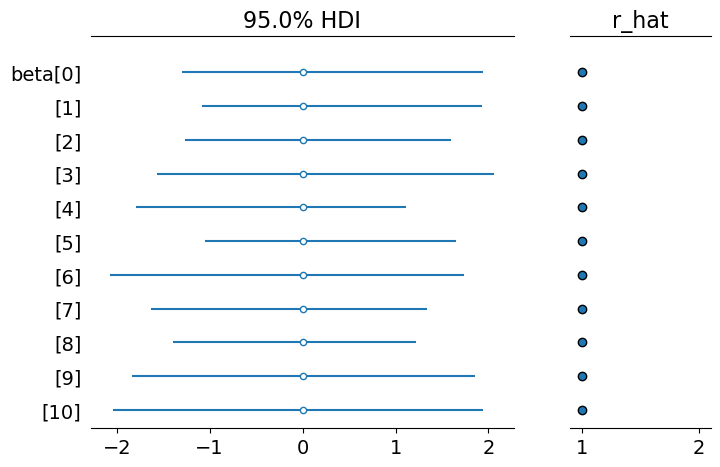

In [161]:
# az.plot_forest(summary_df_tpe, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

az.plot_forest(inference_results_auto, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

#### Reformat saved inference csv data for subsequent rhat, hdi inspection.
Only useful if not using in-memory results and are instead using the saved csv results. It is necessary to restructure the saved csv data in order to run subsequent analysis.

In [46]:
restructure_mcmc_samples_custom(inf_data_csv, inf_data_csv_reformat)

KeyboardInterrupt: 

In [44]:
# import pandas as pd
# import arviz as az
# import xarray as xr
# import numpy as np

# def analyze_posterior_from_csv(csv_file):
#     try:
#         df = pd.read_csv(csv_file)

#         n_chains = df['chain'].nunique()
#         n_draws = df['draw'].nunique()
#         variables = df['variable'].unique()

#         posterior_data = {}

#         for variable in variables:
#             var_df = df[df['variable'] == variable]
#             values = np.empty((n_chains, n_draws))

#             for chain in range(n_chains):
#                 for draw in range(n_draws):
#                     val = var_df[(var_df['chain'] == chain) & (var_df['draw'] == draw)]['value'].iloc[0]
#                     values[chain, draw] = val

#             posterior_data[variable] = (("chain", "draw"), values) #store as tuple for xr.Dataset

#         coords = {"chain": range(n_chains), "draw": range(n_draws)}
#         posterior_ds = xr.Dataset(posterior_data, coords=coords)  # Create ONE dataset

#         inference_data = az.InferenceData(posterior=posterior_ds)  # Pass the SINGLE dataset

#         hdi_data = az.hdi(inference_data, hdi_prob=0.95)
#         rhat_data = az.rhat(inference_data)

#         return inference_data, hdi_data, rhat_data

#     except FileNotFoundError:
#         print(f"Error: CSV file '{csv_file}' not found.")
#         return None, None, None
#     except ValueError as e:
#         print(f"Error: {e}")
#         return None, None, None
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return None, None, None


# inference_data, hdi_data, rhat_data = analyze_posterior_from_csv(data_csv_out)

Analyze the hdi, rhat, inference data values for any given BVS variable output. For example, beta (feature importance), or mu, etc.

In [ ]:
# Match "beta" followed by anything in square brackets (e.g., beta[0], beta[1], beta[a], beta[xyz])
variable_pattern = r"beta\[.*\]"
inference_data,  hdi_data, rhat_data = analyze_posterior_from_csv(
    inf_data_csv_reformat,
    variable_pattern
)

# # Match "mu" followed by one or more digits OR "mu" followed by anything in square brackets
# variable_pattern = r"mu\d+|mu\[.*\]"
# inference_data, _, _ = analyze_posterior_from_csv(data_csv_out, variable_pattern)


#### Inspect hdi information

In [50]:
# 1. Accessing and Displaying HDI Values:
# Convert to DataFrame and reshape (as explained in previous responses)
hdi_df = hdi_data.to_dataframe().stack(level=0).reset_index()
hdi_df = hdi_df.rename(columns={'level_0': 'parameter', 'lower': 'hdi_lower', 'higher': 'hdi_higher'})
print("HDI DataFrame:")
print(hdi_df)

HDI DataFrame:
       hdi   level_1         0
0    lower   beta[0] -1.298232
1    lower  beta[10] -2.044775
2    lower   beta[1] -1.086796
3    lower   beta[2] -1.268283
4    lower   beta[3] -1.568938
5    lower   beta[4] -1.794899
6    lower   beta[5] -1.053159
7    lower   beta[6] -2.070831
8    lower   beta[7] -1.628150
9    lower   beta[8] -1.398975
10   lower   beta[9] -1.835308
11  higher   beta[0]  1.944963
12  higher  beta[10]  1.937557
13  higher   beta[1]  1.931556
14  higher   beta[2]  1.599026
15  higher   beta[3]  2.064440
16  higher   beta[4]  1.113567
17  higher   beta[5]  1.654676
18  higher   beta[6]  1.736429
19  higher   beta[7]  1.342289
20  higher   beta[8]  1.216027
21  higher   beta[9]  1.853640


#### Inspect rhat information

In [51]:
# Select the beta values for inspection
var_names=[
    "beta[0]",
    "beta[1]", 
    "beta[2]", 
    "beta[3]", 
    "beta[4]", 
    "beta[5]", 
    "beta[6]", 
    "beta[7]", 
    "beta[8]",
    "beta[9]"
]

rhat_data = az.rhat(inference_data, var_names=var_names)
rhat_values = rhat_data.to_array().values.flatten()  # Extract the R-hat values
rhat_df = pd.DataFrame({'variable': var_names, 'r_hat': rhat_values})
rhat_df

variable     r_hat
0  beta[0]  1.000551
1  beta[1]  1.000814
2  beta[2]  1.000097
3  beta[3]  1.000498
4  beta[4]  1.000242
5  beta[5]  1.000359
6  beta[6]  1.000261
7  beta[7]  1.000092
8  beta[8]  1.000355
9  beta[9]  1.000112

## Diagnostics: Effective Sample Size

Interpretation: 
- Low ESS:
    - A low ESS suggests that the samples might be correlated or that the sampler is struggling to explore the parameter space efficiently.
    - This can lead to less reliable inference results.
- High ESS:
    - A high ESS indicates that the samples are more independent, providing a more accurate representation of the posterior distribution.
    - This means that the information in your posterior distribution is well-represented by the samples.
    
Factors Affecting ESS:
- Model Complexity:
    - More complex models can lead to lower ESS.
- Sampling Algorithm:
    - The choice of MCMC algorithm can affect ESS.
    - Some algorithms might be more efficient in certain situations.
- Number of Samples:
    - Increasing the number of samples can generally improve ESS, but there's a trade-off with computational cost.
    
Typical Range:
- While there's no strict threshold for a "good" ESS, values significantly lower than the number of samples can be a cause for concern.
- A general rule of thumb is that the ESS should be at least 100 for reliable inference.
- However, this can vary depending on the specific context and the complexity of the model.

Bulk vs Tail ESS: 
- ESS Bulk:
    - This refers to the effective sample size (ESS) of the bulk of the posterior distribution.
    - It's a measure of how many independent draws the MCMC sampler has effectively produced.
- ESS Tail:
    - This refers to the ESS of the tails of the posterior distribution.
    - It's a measure of how well the sampler has explored the extreme values of the distribution.
    
- Values: 
    - Ideally, the ESS bulk and tail should be similar in magnitude.
    - A large difference between the two can indicate potential convergence issues or an insufficient number of samples.
    - If the ESS tail is significantly smaller than the ESS bulk, it suggests that the sampler may not have adequately explored the tails of the distribution.
- Shape:
    - Symmetrical:
        - If the posterior is roughly symmetrical, it suggests that the data is providing strong evidence for a particular range of parameter values.
    - Skewed:
        - A skewed posterior indicates that the data favors one tail of the distribution over the other.
        - This could be due to factors like outliers or non-linear relationships.
    - Multimodal:
        - A multimodal posterior suggests that the data supports multiple plausible parameter values.
        - This could be due to model misspecification or the presence of multiple local optima.  

Improving ESS:

- Increase the Number of Samples:
    - Run the MCMC sampler for longer.
- Consider a Different Sampler:
    - Experiment with different MCMC algorithms.
- Reparameterize the Model:
    - If possible, reparameterize the model to improve mixing.

In [58]:
# Arviz method
az.plot_ess(inference_results)
# plot_ess(summary_df_tpe, inference_variables_tpe, inference_states_tpe)
plot_ess(summary_df_auto, inference_variables, inference_states)

### Trace Plots


- Density Plot:
    - Shape:
        - A symmetric, unimodal distribution indicates a well-defined posterior.
        - A skewed or multimodal distribution might suggest issues with the model or data.
    - Location:
        - The location of the peak indicates the most probable value of the parameter.
    - Spread:
        - The width of the distribution indicates the uncertainty around the parameter.
- Trace Plot:
    - Mixing:
        - The trace plot should show a well-mixed chain, meaning the sampler is exploring the parameter space effectively.
        - If the trace is stuck in a particular region, it might indicate convergence issues.
    - Stationarity:
        - The trace should appear stationary, meaning there are no clear trends or patterns over time.
        - A non-stationary trace might suggest that the sampler hasn't converged yet.
        
- Interpretation the Variables:
    - Beta:
        - The posterior distribution of beta indicates the importance of the corresponding features in the model.
        - A wider distribution suggests more uncertainty about the feature's importance.
        - Negative values indicate inverse relationships.
    - Beta_raw:
        - This represents the raw coefficients before feature selection.
        - A wider distribution might indicate that the feature is not strongly associated with the target variable.
    - Sigma:
        - The posterior distribution of sigma represents the uncertainty in the model's noise term.
        - A wider distribution indicates greater uncertainty.
        - Standard deviation of the noise term. A smaller value indicates less noise.
    - Ind:
        - The posterior distribution of ind represents the probability of each feature being included in the model.
        - A higher probability indicates a more important feature.
        - Indicator variables indicate whether a feature is included (1) or excluded (0) in the model.
    - Mu:
        - The posterior distribution of mu represents the uncertainty in the model's predictions.
        - Predicted mean values for the target variable.
    - Divergence:
        - Look for signs of divergence, such as sudden jumps in the trace plots or high R-hat values.

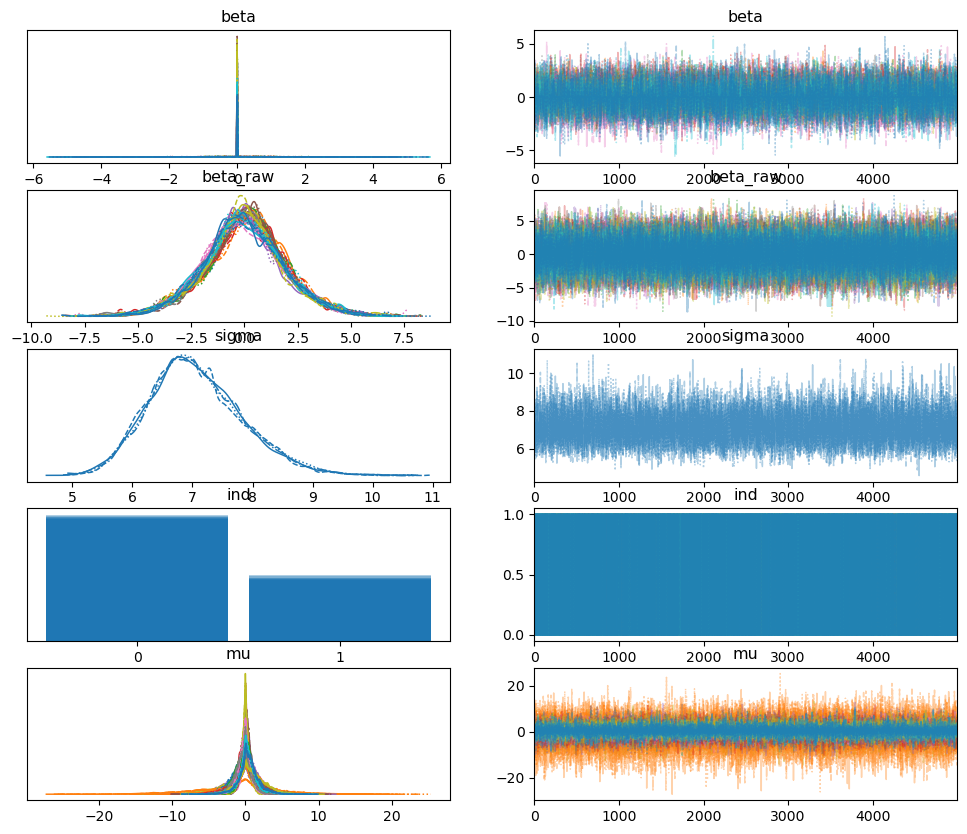

In [163]:
# Arviz method
# Left column are density plots which show the distribution of the parameter values.
# Right is the Trace Plot which plots the parameter values across MCMC iterations.

# az.plot_trace(inference_results_tpe, var_names=["beta", "beta_raw", "sigma", "ind", "mu"]);

az.plot_trace(inference_results_auto, var_names=["beta", "beta_raw", "sigma", "ind", "mu"]);

### Posterior Distrubitions
Plot the posterior distributions

C:\Users\ashle\anaconda3\Lib\site-packages\arviz\plots\plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (85) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>],
       [<Axes: title={'center': 'beta\n8'}>,
        <Axes: title={'center': 'beta\n9'}>,
        <Axes: title={'center': 'beta\n10'}>,
        <Axes: title={'center': 'beta_raw\n0'}>],
       [<Axes: title={'center': 'beta_raw\n1'}>,
        <Axes: title={'center': 'beta_raw\n2'}>,
        <Axes: title={'center': 'beta_raw\n3'}>,
        <Axes: title={'center': 'beta_raw\n4'}>],
       [<Axes: title={'center': 'beta_raw\n5'}>,
        <Axes: title={'center': 'beta_raw\n6'}>,
        <Axes: title={'center': 'beta_raw\n7'}>,
        <Axes: title={'center': 'beta_raw\n8'}>],
       [<Axes: title={'center': 'beta_raw\n9'}>,
        <

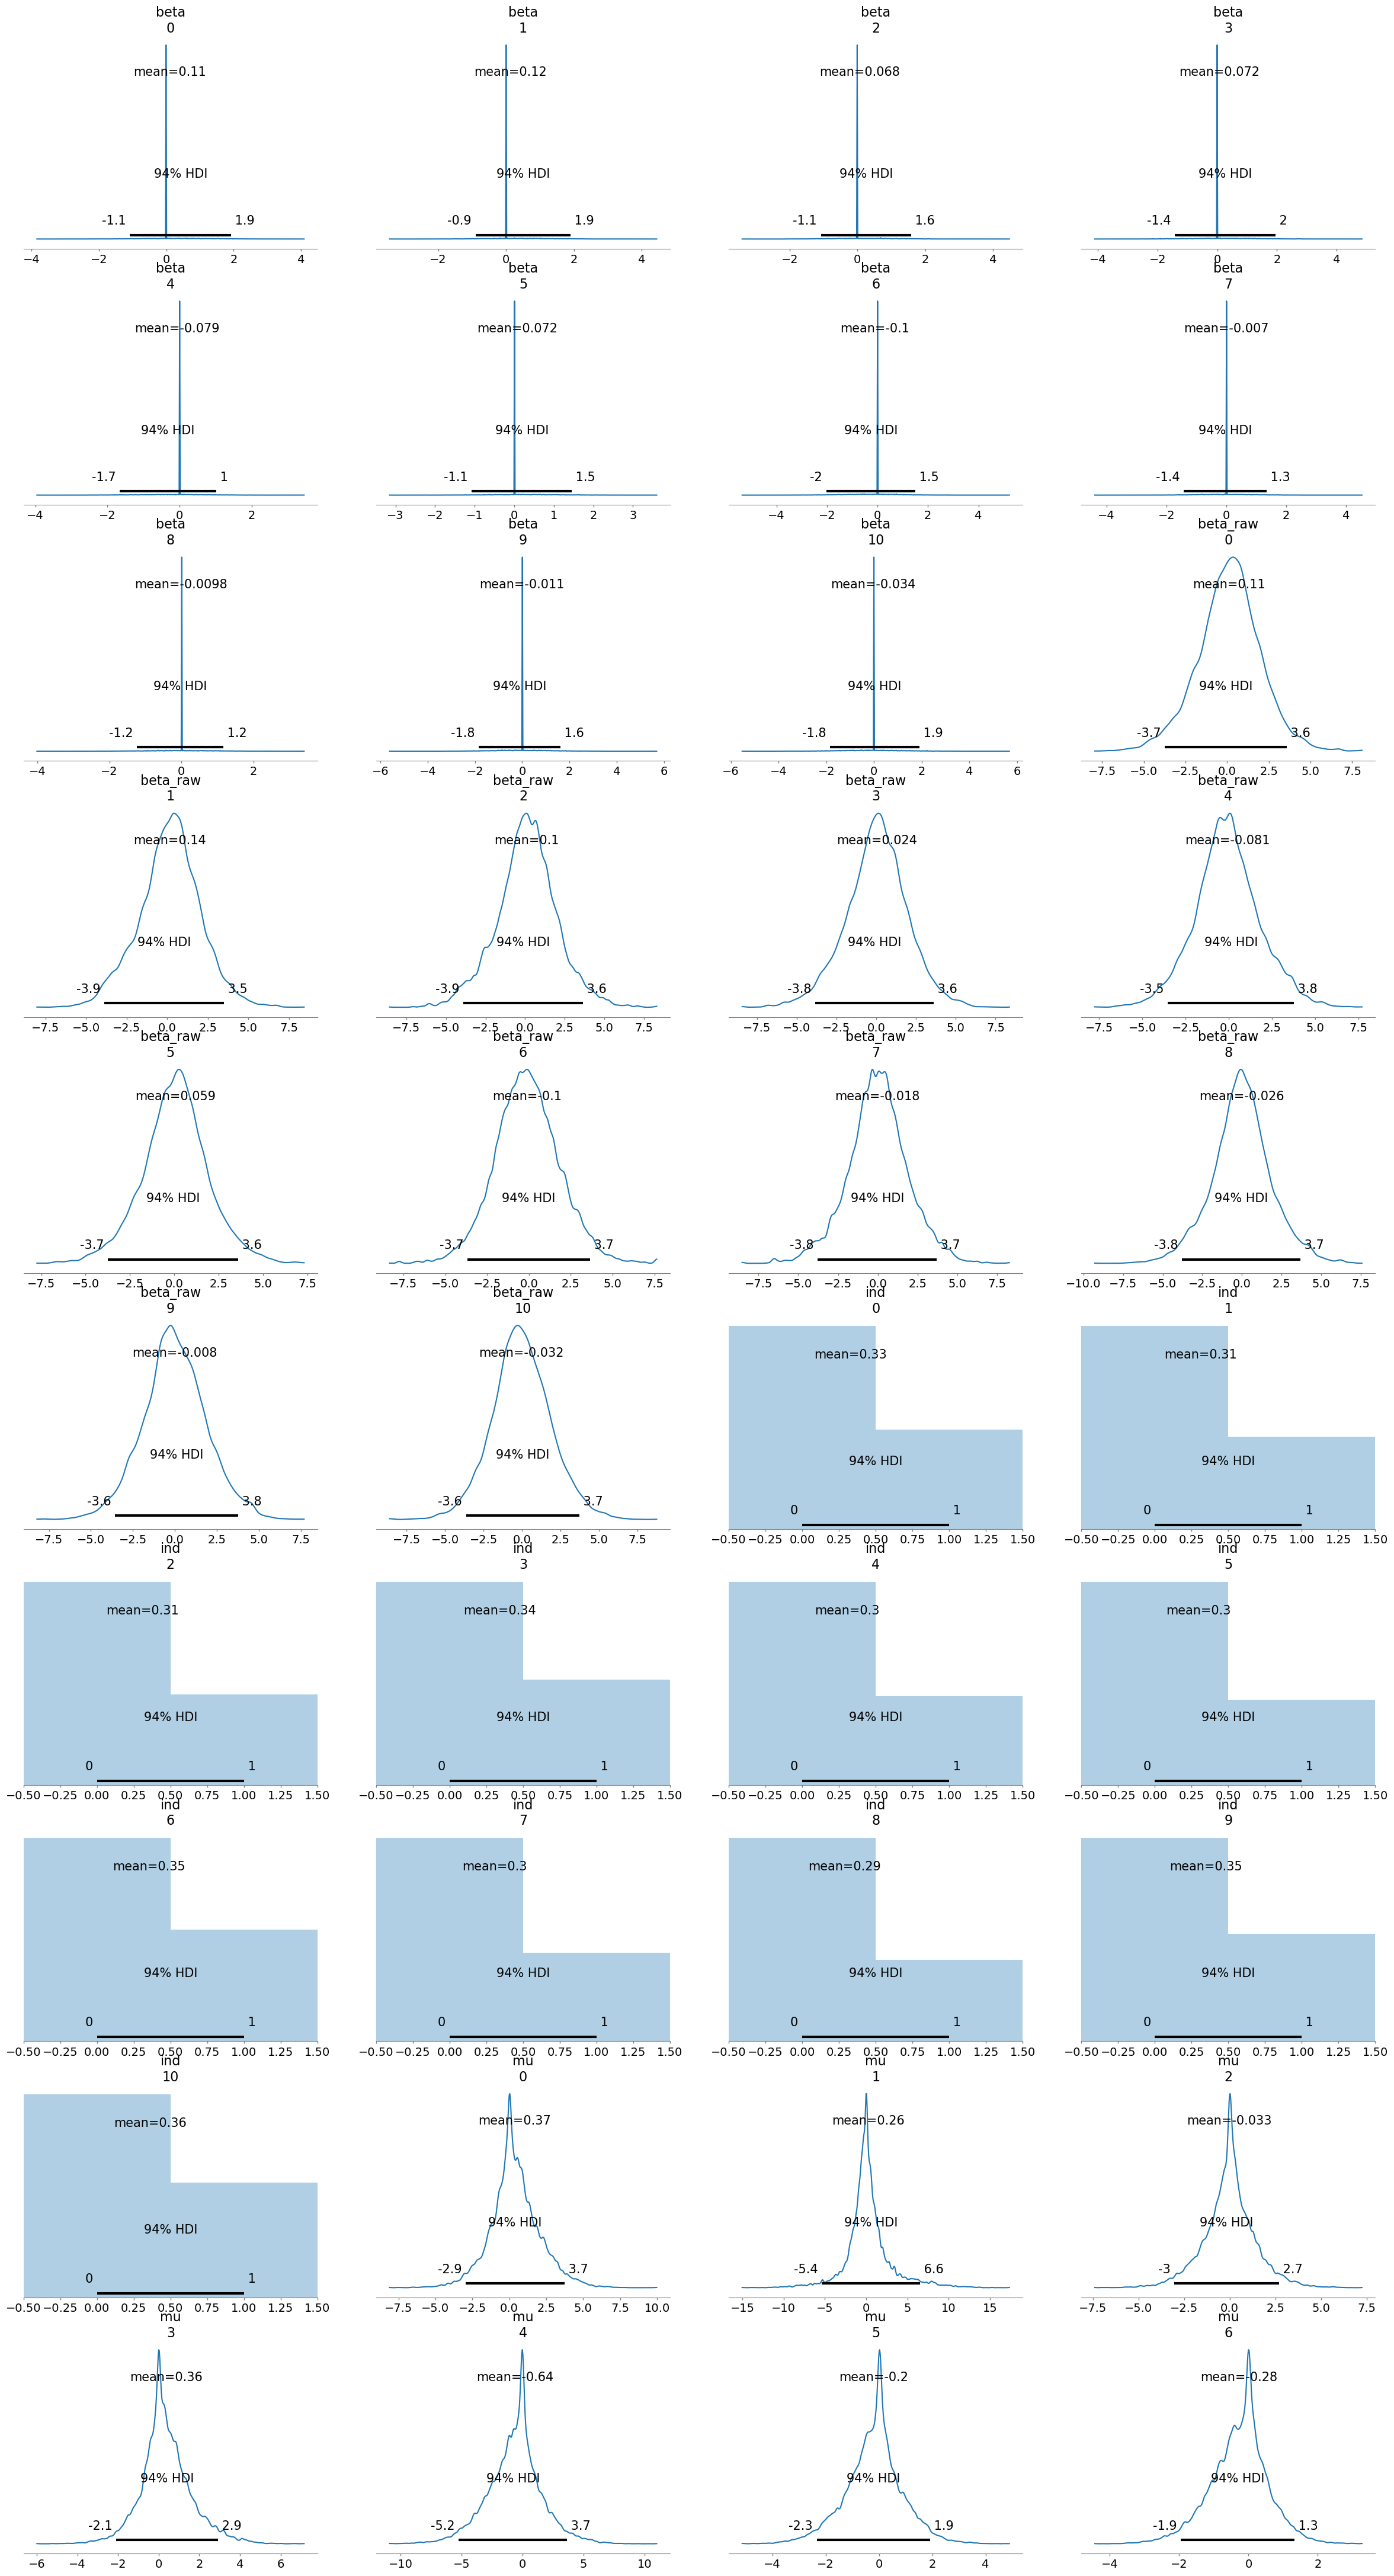

In [162]:
az.plot_posterior(inference_results_auto)

## Model Fit

### waic_score breakdown:

- Computed from n# posterior samples and m# observations:
    - This indicates that the WAIC is calculated based on n# samples drawn from the posterior distribution of the model parameters, and the model was fit to m# data points.

- log-likelihood matrix:
    - This suggests that the WAIC calculation utilizes the log-likelihood values for each data point and each posterior sample.

- elpd_waic:
    - This is the estimated expected log predictive density under the WAIC.
    - It's a measure of model fit, with higher values generally indicating a better fit.

- p_waic:
    - This is the effective number of parameters, a measure of model complexity.
    - Higher values indicate a more complex model.

- waic_score = az.waic(inference_results_auto):
    - This line calls the waic function from the arviz library to calculate the WAIC score using the inference_results_auto object, which likely contains the posterior samples and other relevant information.

- Provides a quantitative assessment of the model's fit to the data while considering both model fit and complexity.

- Key Points:
    - WAIC: A widely used information criterion for model comparison in Bayesian statistics.
    - elpd_waic: Measures how well the model predicts new, unseen data.
    - p_waic: Accounts for model complexity by estimating the effective number of parameters.

Interpretation:

Model Fit: The elpd_waic value of -171.06 provides a measure of the model's predictive performance.
However, the primary focus should be on comparing elpd_waic values across different models to determine
which model provides the best predictive performance. Data-Specific: The interpretation of elpd_waic
depends heavily on the specific characteristics of your data and the research question.

Model Complexity: The p_waic value of 2.97 indicates that the model has a moderate level of complexity.

Warning: The warning message emphasizes the need for careful interpretation of the WAIC results.
It's crucial to consider the potential impact of any issues that might have arisen during the calculation.

In [168]:
# # Log liklihood not in inference results. Need to add
waic_score = az.waic(inference_results_auto)  
print(waic_score)


Computed from 20000 posterior samples and 51 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -171.06     0.92
p_waic        2.97        -

There has been a warning during the calculation. Please check the results.


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


### loo_score breakdown:

-  Computed from n# posterior samples and m# observations log-likelihood matrix:
    - This indicates that the LOO estimate was calculated using n# samples from the posterior distribution of the model parameters, and the model was fit to m# data points.
    - The log-likelihood matrix contains the log-likelihood values for each data point and each posterior sample.

- elpd_loo:
    - This is the estimated expected log predictive density under the LOO.
    - It's a measure of model fit, with higher values generally indicating a better fit.

- SE:
    - This is the standard error of the elpd_loo estimate.
    - It provides an indication of the uncertainty associated with the elpd_loo value.
    - A higher standard error suggests greater uncertainty in the estimate. 

- p_loo:
    - This is the effective number of parameters estimated by LOO.
    - It's a measure of model complexity
    - Higher values indicate a more complex model. 

- Key Points:
    - LOO: A widely used method for estimating out-of-sample predictive performance in Bayesian models.
    - elpd_loo: Measures how well the model predicts new, unseen data.
    - p_loo: Accounts for model complexity by estimating the effective number of parameters.

In [175]:
ploo_score = az.loo(inference_results_auto)  
print(ploo_score)

Computed from 20000 posterior samples and 51 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -172.00     1.64
p_loo        3.90        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       50   98.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    2.0%



C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Interpretation: 

Model Fit: The elpd_loo value of -172.00 provides a measure of the model's predictive performance.
However, the primary focus should be on comparing elpd_loo values across different models to select
the best-performing one.

Model Complexity: The p_loo value of 3.90 indicates that the model has a moderate level of complexity.

Warning and Pareto k Diagnostic: The warning message and the Pareto k diagnostic suggest that the
LOO estimates are generally reliable, but it's important to be cautious and potentially investigate
any data points that fall within the "bad" range.

### Importance: np.abs(beta_means) * ind_means

- What is it? 
    - The importance variable typically represents a measure of the relative influence of different variables on a target variable in a Bayesian model.
    - It is often calculated by combining the posterior means of the coefficients (beta) with the inclusion probabilities (ind).
    - A higher importance value suggests that a variable is more likely to be influential in predicting the target variable.
    - The specific parameters that go into calculating importance can vary depending on the exact implementation, but generally include:
        - Posterior means of coefficients (beta): These represent the estimated effects of each variable on the target variable.
        - Inclusion probabilities (ind): These represent the probability that each variable is included in the model based on the posterior distribution.
- Notes: 
    - The importance metric is a relative measure and doesn't provide absolute values of effect size.
    - The typical range of values for the importance metric in Bayesian variable selection can vary widely depending on the specific problem, model complexity, and scale of the data.
    - Factors affecting the range:
        - Model complexity: More complex models with many variables and interactions might result in a wider range of importance values.
        - Data scale: The scale of the variables in the data can affect the scale of the coefficients and inclusion probabilities, which in turn affects the importance values.
        - Prior distributions: The choice of prior distributions for the coefficients and inclusion probabilities can influence the range of possible values.
- Higher values:
    - Variables with higher importance values are generally considered more influential in predicting the target variable.
    - This suggests that they have a stronger relationship with the outcome.
    - Variables with high importance might still have some degree of uncertainty associated with their effects, which can be assessed by examining the posterior distributions of their coefficients.
- Lower values:
    - Variables with lower importance values are less influential.
    - They might have weaker relationships or be less informative for predicting the target.
- Zero values:
    - Variables with an importance of zero are effectively excluded from the model, indicating that they have no significant impact on the target variable.

#### Calculate feature importance based on coefficient magnitude and inclusion probability

In [151]:
# az.summary(inference_results_tpe, group="posterior")
az.summary(inference_results_auto, group="posterior")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]       0.106  0.669  -1.080    1.930      0.006    0.004   12297.0   
beta[1]       0.123  0.633  -0.901    1.899      0.006    0.004   10240.0   
beta[2]       0.068  0.584  -1.079    1.591      0.006    0.004    9730.0   
beta[3]       0.072  0.733  -1.415    1.961      0.007    0.005    9558.0   
beta[4]      -0.079  0.593  -1.666    1.020      0.006    0.004    8965.0   
beta[5]       0.072  0.546  -1.072    1.454      0.005    0.003   10849.0   
beta[6]      -0.102  0.799  -2.028    1.502      0.008    0.005   10301.0   
beta[7]      -0.007  0.595  -1.416    1.346      0.005    0.004   10948.0   
beta[8]      -0.010  0.518  -1.240    1.163      0.004    0.003   11929.0   
beta[9]      -0.011  0.758  -1.840    1.619      0.007    0.005   10823.0   
beta[10]     -0.034  0.824  -1.840    1.892      0.007    0.005   11558.0   
beta_raw[0]   0.107  1.890  -3.730    3.587      0.020    0.017    8884.0   
beta_raw[1]   0.137  1.899  -3.873    3.480      0.020    0.015    9847.0   
beta_raw[2]   0.100  1.916  -3.885    3.650      0.020    0.015    9222.0   
beta_raw[3]   0.024  1.941  -3.817    3.628      0.021    0.018    8689.0   
beta_raw[4]  -0.081  1.888  -3.532    3.773      0.020    0.014    8894.0   
beta_raw[5]   0.059  1.867  -3.730    3.594      0.019    0.014    9435.0   
beta_raw[6]  -0.104  1.939  -3.679    3.661      0.021    0.018    8525.0   
beta_raw[7]  -0.018  1.905  -3.777    3.705      0.021    0.017    8539.0   
beta_raw[8]  -0.026  1.900  -3.789    3.688      0.020    0.015    8880.0   
beta_raw[9]  -0.008  1.897  -3.567    3.770      0.020    0.015    9225.0   
beta_raw[10] -0.032  1.915  -3.639    3.710      0.019    0.015   10323.0   
ind[0]        0.329  0.470   0.000    1.000      0.005    0.004    8601.0   
ind[1]        0.313  0.464   0.000    1.000      0.005    0.003    8873.0   
ind[2]        0.308  0.462   0.000    1.000      0.005    0.003    8977.0   
ind[3]        0.342  0.474   0.000    1.000      0.005    0.003   10030.0   
ind[4]        0.305  0.460   0.000    1.000      0.005    0.003    9042.0   
ind[5]        0.296  0.456   0.000    1.000      0.005    0.004    7704.0   
ind[6]        0.355  0.479   0.000    1.000      0.005    0.004    9296.0   
ind[7]        0.304  0.460   0.000    1.000      0.005    0.003    9665.0   
ind[8]        0.287  0.452   0.000    1.000      0.005    0.003    8748.0   
ind[9]        0.346  0.476   0.000    1.000      0.004    0.003   11294.0   
ind[10]       0.361  0.480   0.000    1.000      0.005    0.004    8802.0   
mu[0]         0.371  1.695  -2.942    3.736      0.015    0.011   11896.0   
mu[1]         0.263  2.804  -5.372    6.559      0.025    0.018   11643.0   
mu[2]        -0.033  1.437  -3.044    2.712      0.012    0.009   12516.0   
mu[3]         0.361  1.267  -2.090    2.929      0.011    0.008   12009.0   
mu[4]        -0.641  2.253  -5.231    3.660      0.020    0.014   12725.0   
mu[5]        -0.199  1.086  -2.337    1.920      0.009    0.006   14426.0   
mu[6]        -0.283  0.845  -1.949    1.333      0.007    0.005   14199.0   
mu[7]        -0.486  1.412  -3.479    2.090      0.013    0.009   11810.0   
mu[8]        -0.955  2.798  -7.050    4.054      0.026    0.018   11407.0   
mu[9]        -0.198  1.662  -3.730    2.887      0.014    0.010   12626.0   
mu[10]       -0.145  1.762  -3.789    3.421      0.015    0.011   12198.0   
mu[11]       -1.308  5.494 -12.907    8.970      0.047    0.033   13120.0   
mu[12]        0.256  1.041  -1.732    2.296      0.009    0.006   12724.0   
mu[13]       -0.301  0.896  -2.093    1.368      0.008    0.005   13204.0   
mu[14]        0.162  0.693  -1.202    1.515      0.006    0.004   12071.0   
mu[15]        0.262  0.973  -1.491    2.286      0.009    0.006   12072.0   
mu[16]        0.156  1.265  -2.533    3.055      0.011    0.007   11890.0   
mu[17]        0.445  1.388  -2.048    3.303      0.013    0.010   12013.0   
mu[18]     

Extract the means and std of the BVS results

In [152]:
# posterior_means = az.summary(inference_results)['mean']
posterior_means_auto = summary_df_auto['mean']
posterior_std_auto = summary_df_auto['sd']

In [153]:
# posterior_means = az.summary(inference_results)['mean']
# posterior_means_tpe = summary_df_tpe['mean']
# posterior_std_tpe = summary_df_tpe['sd']

#### Calculate feature importance based on coefficient variance

---
# FINAL RESULTS OF BVS
---

Extract the predictor variable labels for plotting purposes

In [81]:
x_labels = list(df_variables_final.columns)

Extract the beta means for plotting purposes

In [157]:
# beta_raw_tpe = posterior_means_tpe.loc[
#     posterior_means_tpe.index.str.startswith('beta_raw')
# ]

# beta_means_tpe = posterior_means_tpe.loc[
#     posterior_means_tpe.index.str.startswith('beta') & ~posterior_means_tpe.index.str.startswith('beta_raw')
# ]

# beta_raw_auto = posterior_means_auto.loc[
#     posterior_means_auto.index.str.startswith('beta_raw')
# ]

beta_means_auto  = posterior_means_auto.loc[
    # Get beta and not beta raw
    posterior_means_auto.index.str.startswith('beta') & ~posterior_means_auto.index.str.startswith('beta_raw')
]

Plot BVS results using beta means

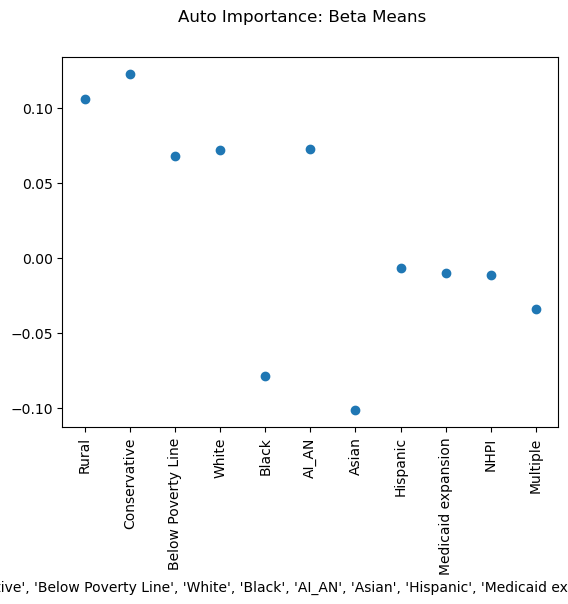

In [159]:
plot_importance(beta_means_auto, x_labels, importance_type="Auto Importance: Beta Means")

---
# Clean up the results csvs for paper writing and knowledge share
---

In [374]:
# Path to where the data sits
path = "D:\ScrippsResearch\HouseholdPulse\BVS_BVS_v11_optuna_AUTO_trial78_5000draws_summary_df_01-28-2025_12-15-47.csv"
# Read in the data
sample_stats = read_results(path)
# Clean up the data
beta_means_results = clean_up_data(sample_stats, df_variables_final)
print(beta_means_results)

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Rural               0.106  0.669  -1.080    1.930      0.006    0.004   
Conservative        0.123  0.633  -0.901    1.899      0.006    0.004   
Below Poverty Line  0.068  0.584  -1.079    1.591      0.006    0.004   
White               0.072  0.733  -1.415    1.961      0.007    0.005   
Black              -0.079  0.593  -1.666    1.020      0.006    0.004   
AI_AN               0.072  0.546  -1.072    1.454      0.005    0.003   
Asian              -0.102  0.799  -2.028    1.502      0.008    0.005   
Hispanic           -0.007  0.595  -1.416    1.346      0.005    0.004   
Medicaid expansion -0.010  0.518  -1.240    1.163      0.004    0.003   
NHPI               -0.011  0.758  -1.840    1.619      0.007    0.005   
Multiple           -0.034  0.824  -1.840    1.892      0.007    0.005   

                    ess_bulk  ess_tail  r_hat  
Rural                  12297     12895      1  
Conservative           1024

### Plot the results using error bars and sorting - make the plot prettier

C:\Users\ashle\AppData\Local\Temp\ipykernel_6552\294825627.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


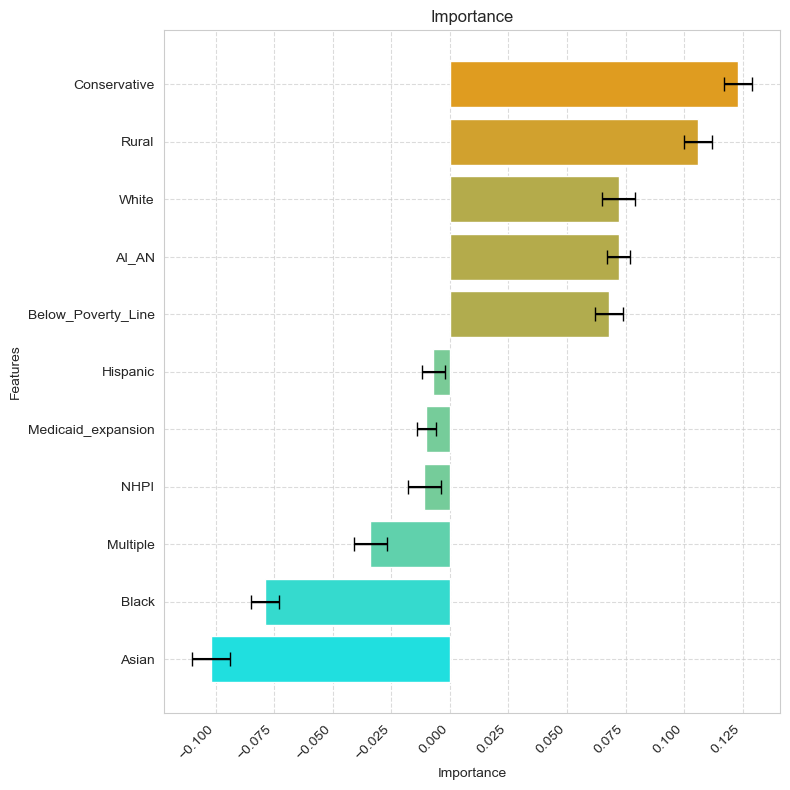

In [375]:
plot_importance_with_errors(beta_means_results, title="Importance")

---
# Null Hypothesis and P-Values
---
Standard Interpretation of P-values
- p-values tell you about the statistical significance of the relationships between each predictor variable and the target variable. 
    - A small p-value (typically < 0.05) suggests a statistically significant relationship
    - A large p-value suggests no significant relationship.  

- The most common way to interpret p-values is to compare them to a predetermined significance level (alpha), often 0.05.
    - p-value < alpha:
        - You reject the null hypothesis. This is often called "statistically significant."
        - It suggests that there is evidence that the predictor has some effect.
    - p-value >= alpha:
        - You fail to reject the null hypothesis.
        - This does not mean the predictor has no effect.
        - It just means that the data doesn't provide strong enough evidence to conclude that it does.
        
        
- P-values are probabilities, so they range from 0 to 1.

    - Minimum p-value (close to 0):
        - Strong evidence against the null hypothesis.
        - Very unlikely to see the data you saw if the predictor had no effect.
    - Maximum p-value (close to 1):
        - Little to no evidence against the null hypothesis.
        - The data is consistent with the predictor having no effect.
        
        
        
----

### *** IMPORTANT ***

- BVS is concerned with model selection
    - which combination of variables is most likely to explain the target. 
    - It's not directly testing the null hypothesis for each individual variable in isolation.
    
----    
    

### Finding the right p-value model and data transformations
- Which p-value method is correct? Which data transformation?
- Run multiple and compare the results

In [64]:
df_p_values = evaluate_and_compare_models(
    df_variables_final, lc_rates['Avg']
)

df_p_values

Variable Pearson_p_value Spearman_p_value Kendall_p_value  \
0                Rural        0.000001         0.000000        0.000000   
1         Conservative        0.000000         0.000000        0.000001   
2   Below Poverty Line        0.006358         0.014378        0.018456   
3                White        0.000074         0.000679        0.000868   
4                Black        0.017727         0.013766        0.008911   
5                AI_AN        0.003370         0.000069        0.000103   
6                Asian        0.000040         0.000000        0.000000   
7             Hispanic        0.245928         0.010973        0.010267   
8   Medicaid expansion        0.413082         0.372663        0.379247   
9                 NHPI        0.040850         0.115824        0.135036   
10            Multiple        0.005510         0.008245        0.006350   

   Pearson_Correlation Spearman_Correlation Kendall_Tau  \
0             0.627604             0.661870    0.503727   
1             0.686781             0.644406    0.477472   
2             0.377218             0.340862    0.228438   
3             0.525972             0.460237    0.321695   
4            -0.330835            -0.342904   -0.252648   
5             0.402963             0.527568    0.375049   
6            -0.542224            -0.744949   -0.555512   
7            -0.165453            -0.353356   -0.247940   
8            -0.117119            -0.127485   -0.099150   
9            -0.287416             0.222946    0.144370   
10           -0.383203            -0.366072   -0.263633   

   Pearson_p_value_corrected_fdr_bh Spearman_p_value_corrected_fdr_bh  \
0                          0.000005                          0.000001   
1                          0.000000                          0.000001   
2                          0.009992                          0.017573   
3                          0.000203                          0.001493   
4                          0.024375                          0.017573   
5                          0.007414                          0.000191   
6                          0.000145                          0.000000   
7                          0.270521                          0.017244   
8                          0.413082                          0.372663   
9                          0.049928                          0.127406   
10                         0.009992                          0.015116   

   Kendall_p_value_corrected_fdr_bh  reject_pearson_fdr_bh  \
0                          0.000001                   True   
1                          0.000004                   True   
2                          0.022557                   True   
3                          0.001909                   True   
4                          0.014003                   True   
5                          0.000284                   True   
6                          0.000000                   True   
7                          0.014117                  False   
8                          0.379247                  False   
9                          0.148539                   True   
10                         0.011641                   True   

    reject_spearman_fdr_bh  reject_kendall_fdr_bh  
0                     True                   True  
1                     True                   True  
2                     True                   True  
3                     True                   True  
4                     True                   True  
5                     True                   True  
6                     True                   True  
7                     True                   True  
8                    False                  False  
9                    False                  False  
10                    True                   True

### Plot P-Values with False Discover Rate (FDR) Correction

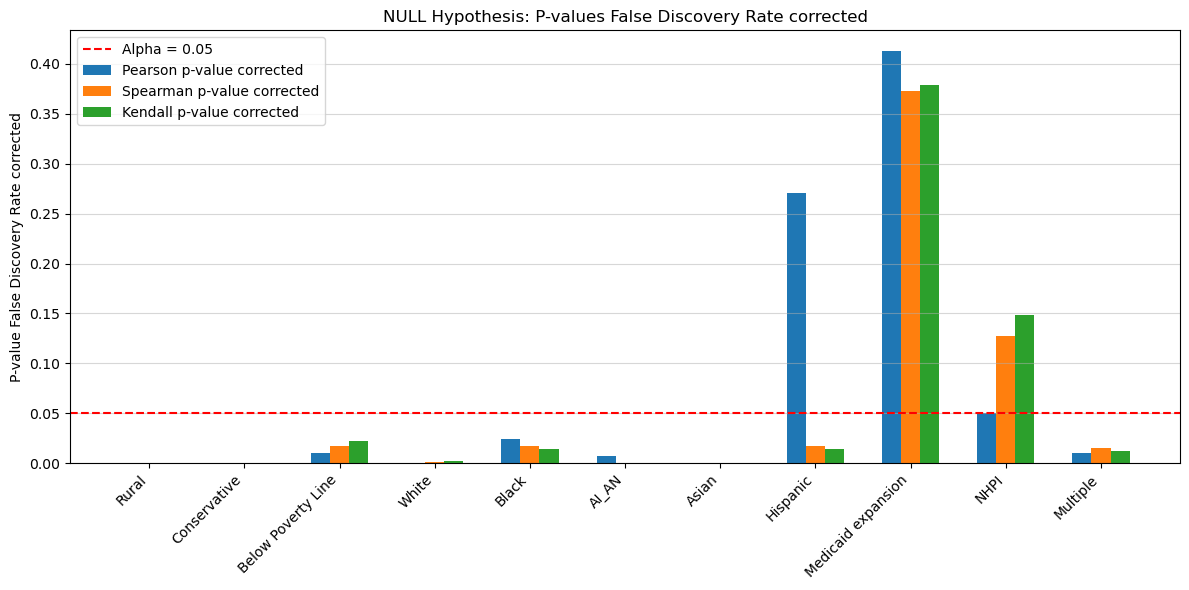

In [66]:
plot_p_values_false_discovery_corrected(df_p_values) 

### Plot p-values without FDR correction

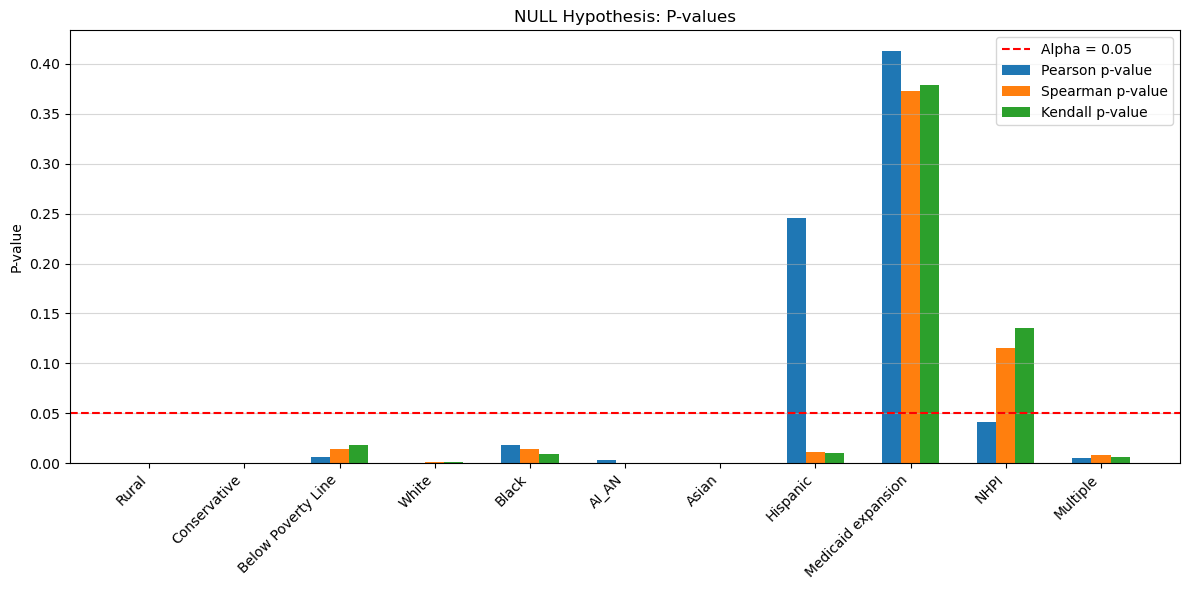

In [67]:
plot_p_values(df_p_values) 

### Plot Null Hypothesis:

For each predictor variable vs target variable, plot the following: 
- Scatter Plot and Regression 
- Histogram of predictor
- Q-Q plot of predictor

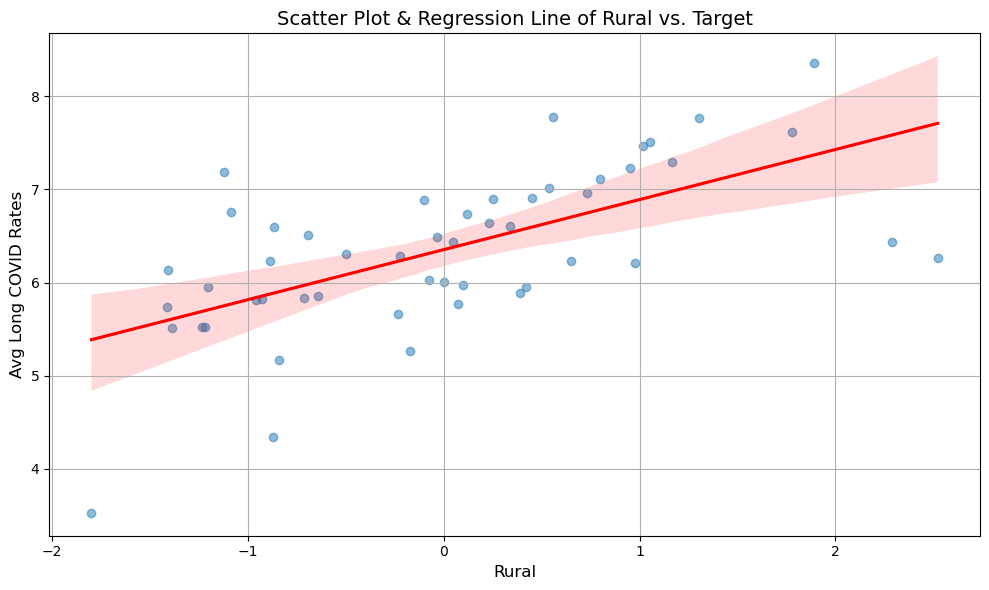

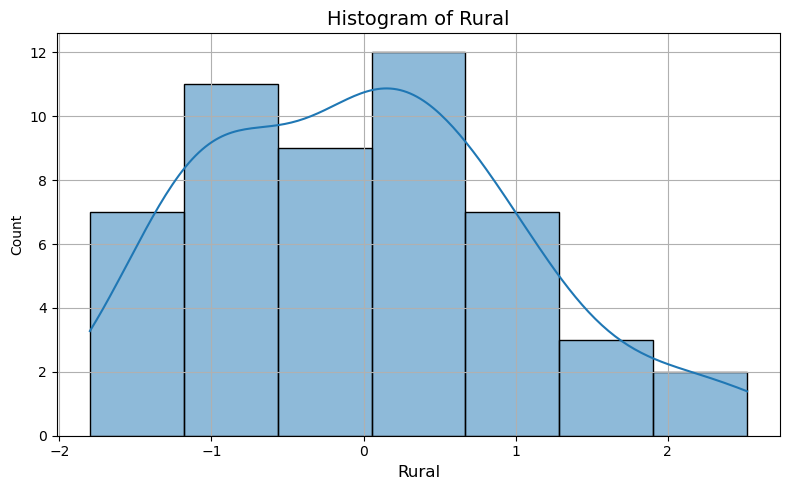

<Figure size 800x500 with 0 Axes>

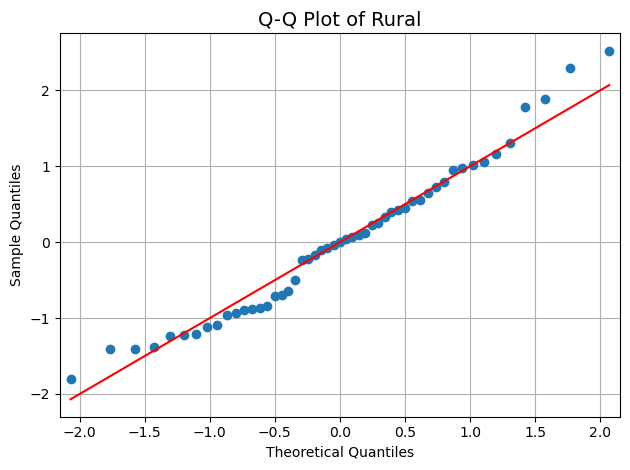

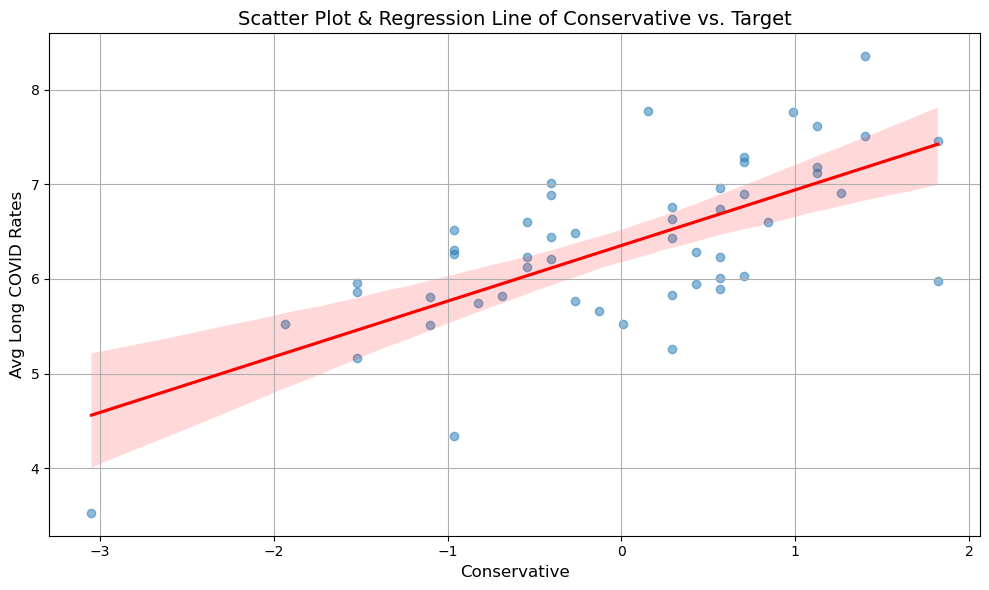

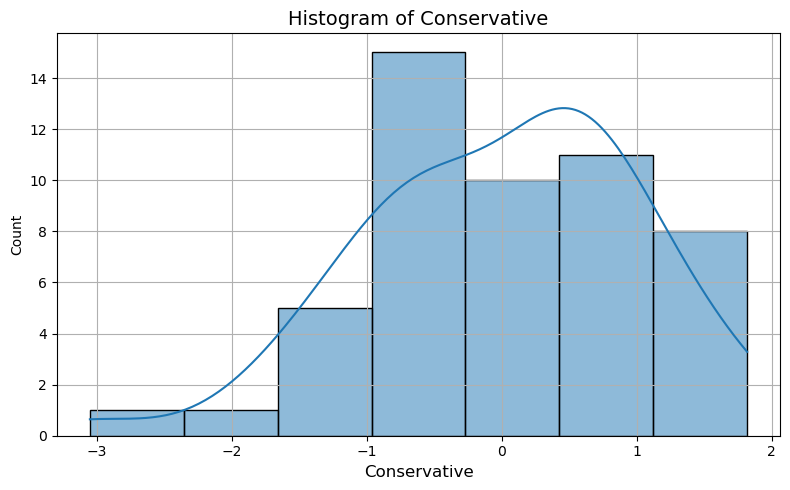

<Figure size 800x500 with 0 Axes>

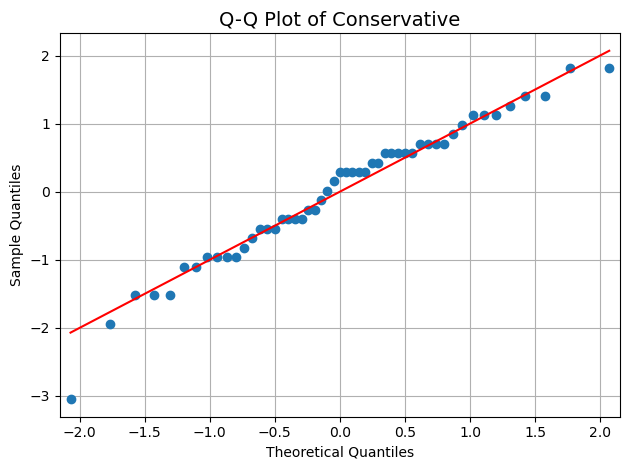

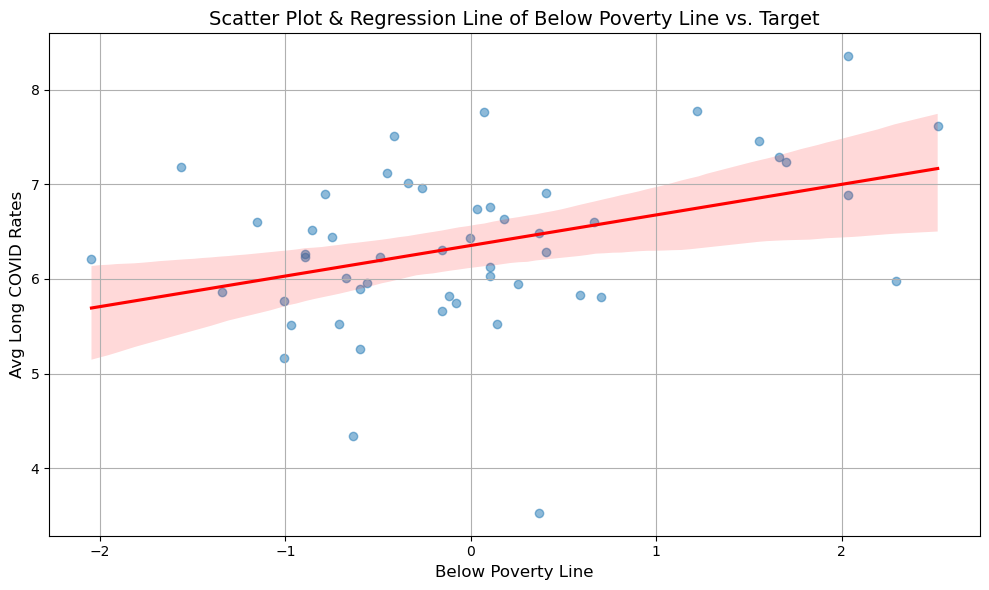

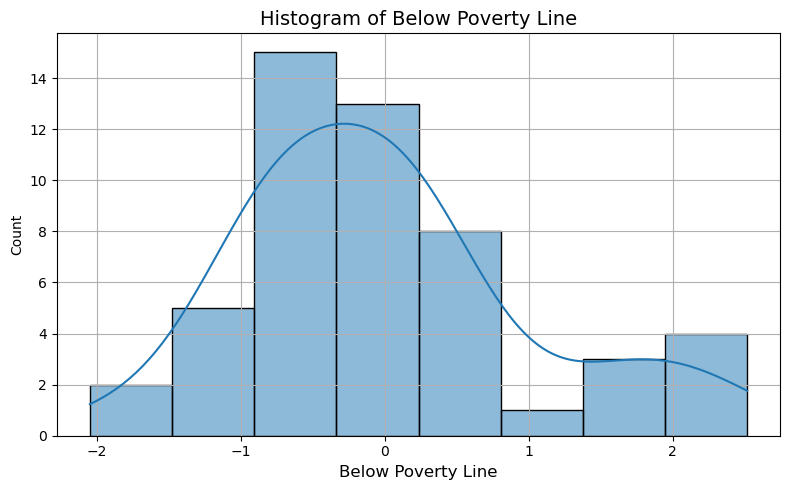

<Figure size 800x500 with 0 Axes>

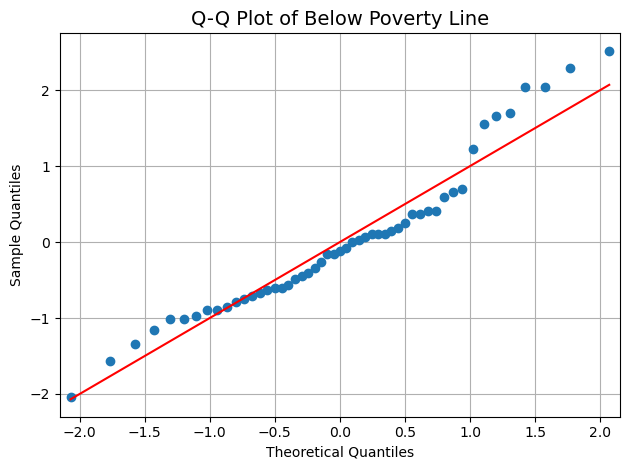

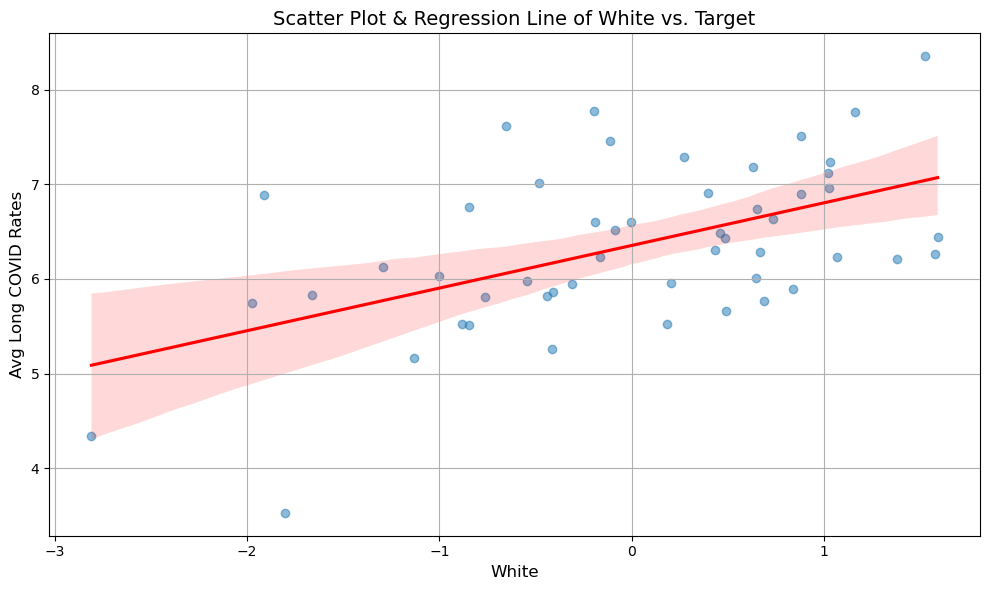

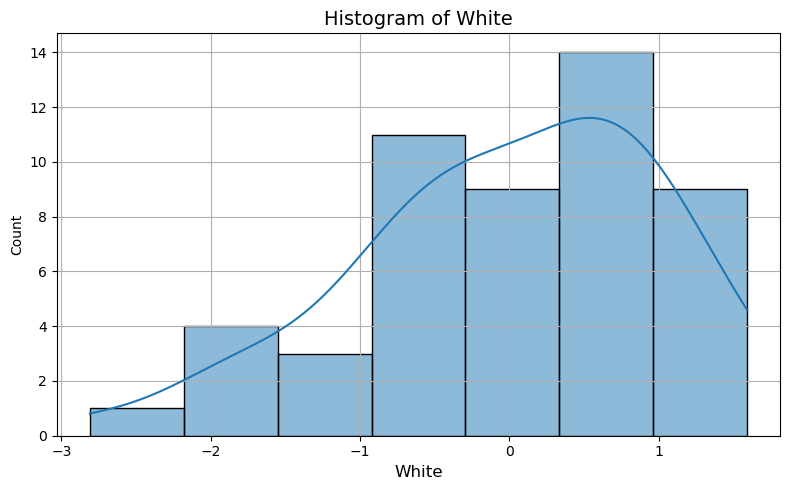

<Figure size 800x500 with 0 Axes>

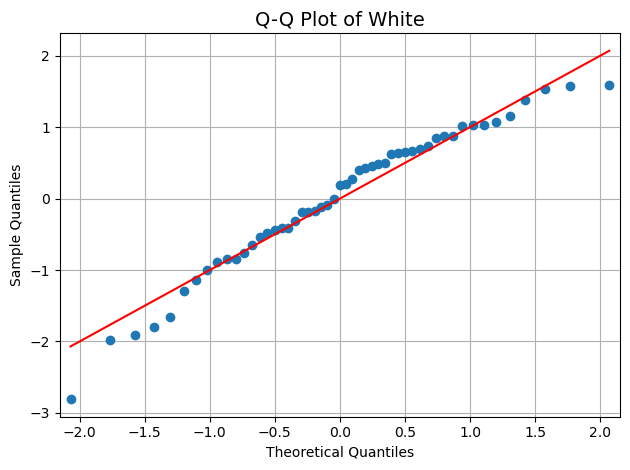

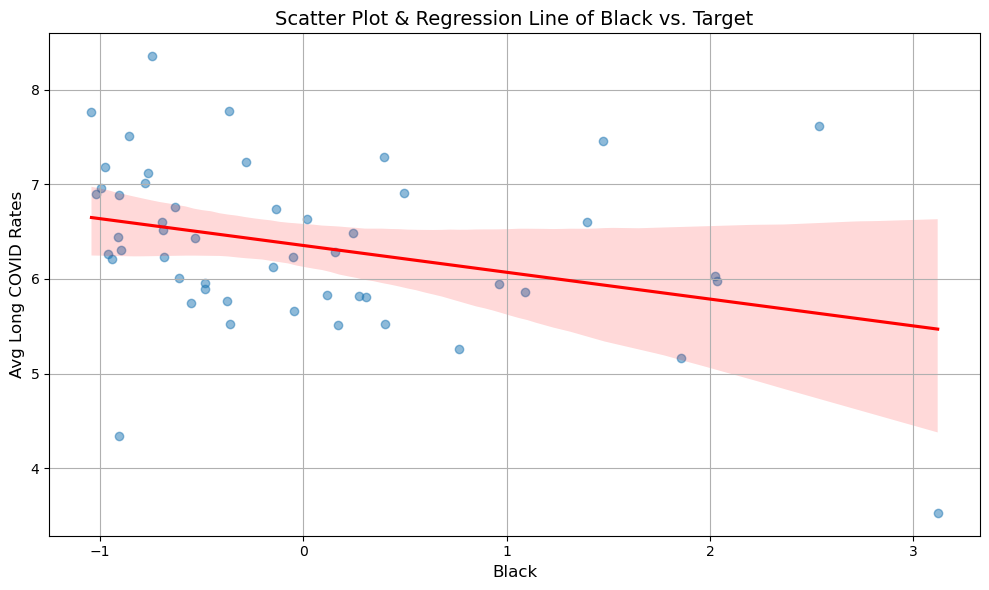

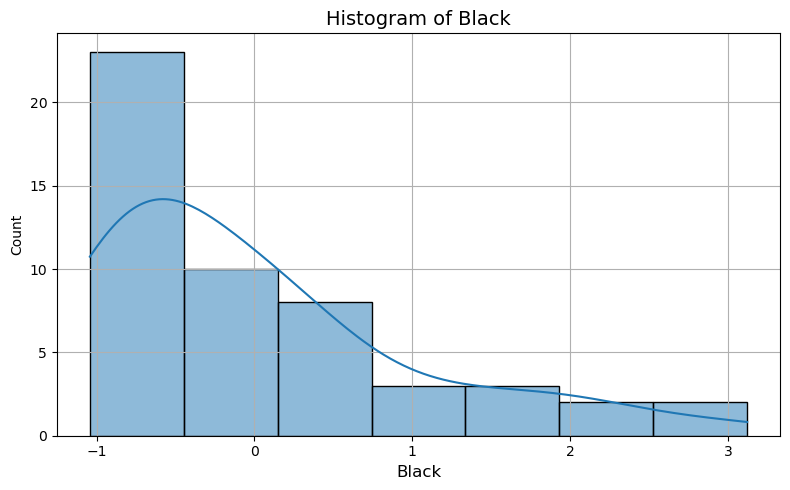

<Figure size 800x500 with 0 Axes>

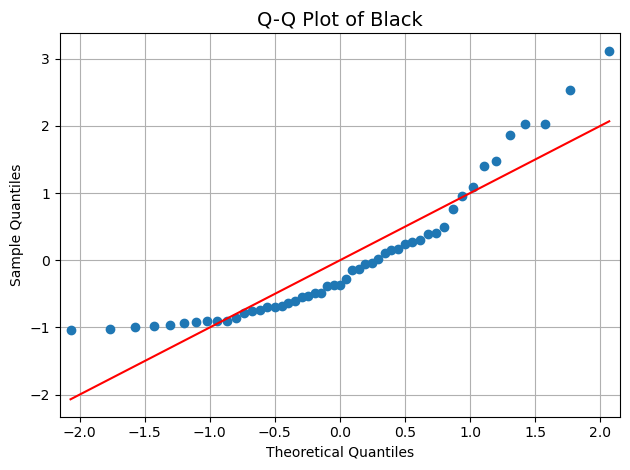

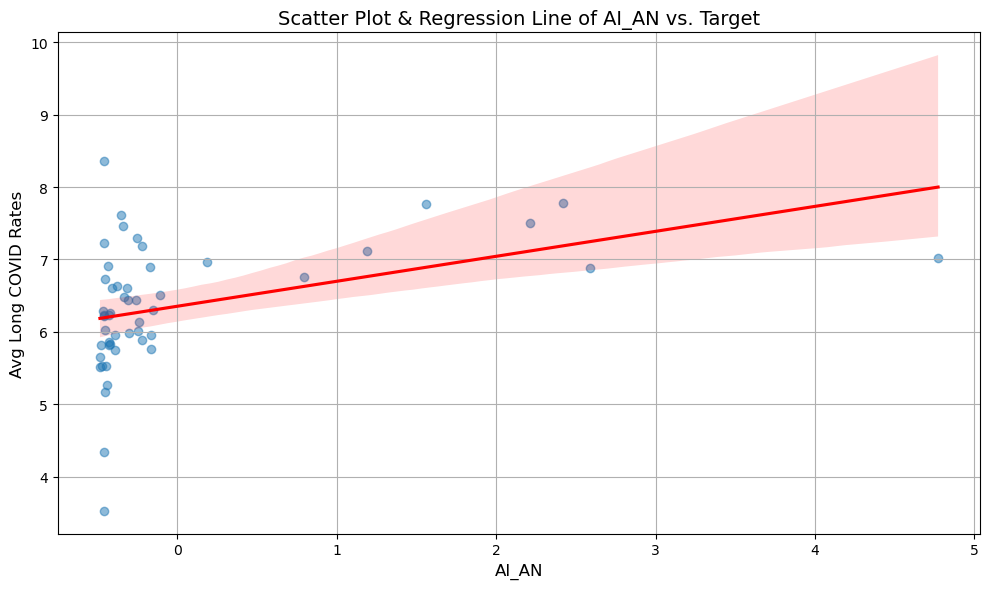

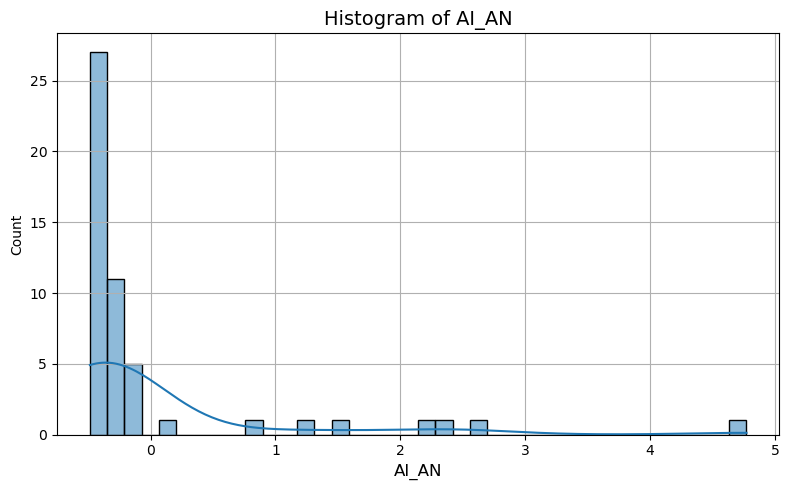

<Figure size 800x500 with 0 Axes>

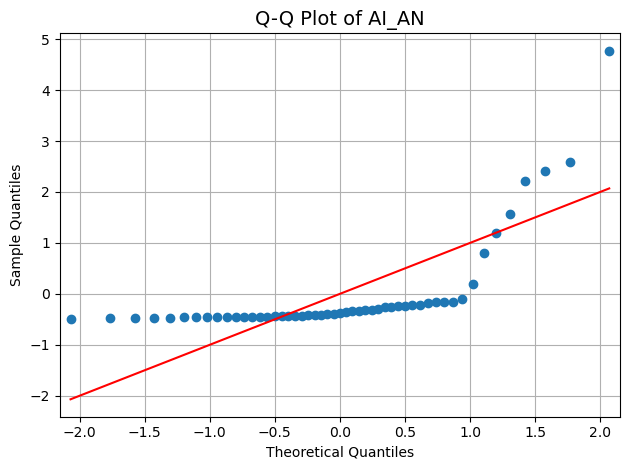

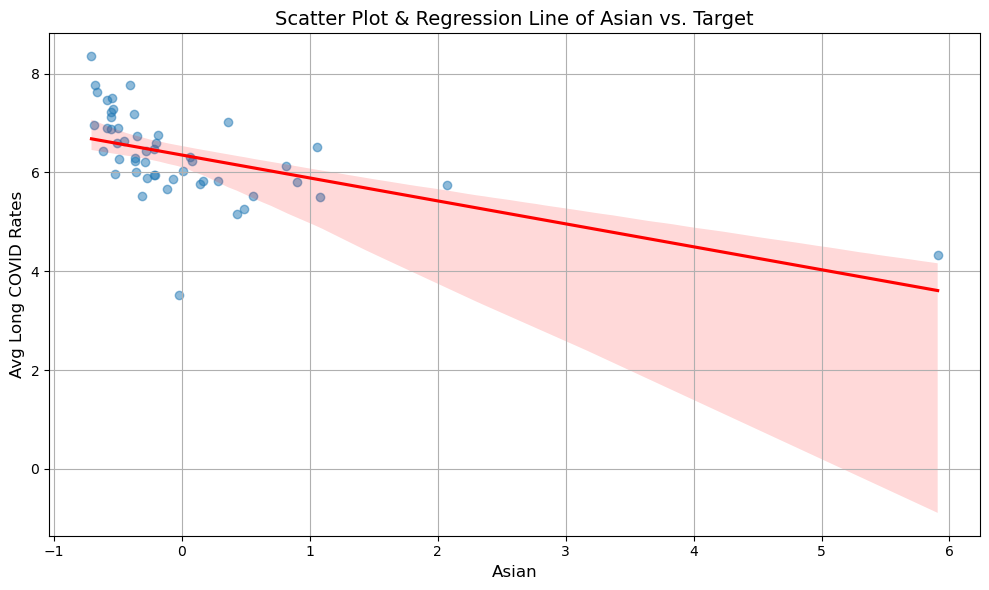

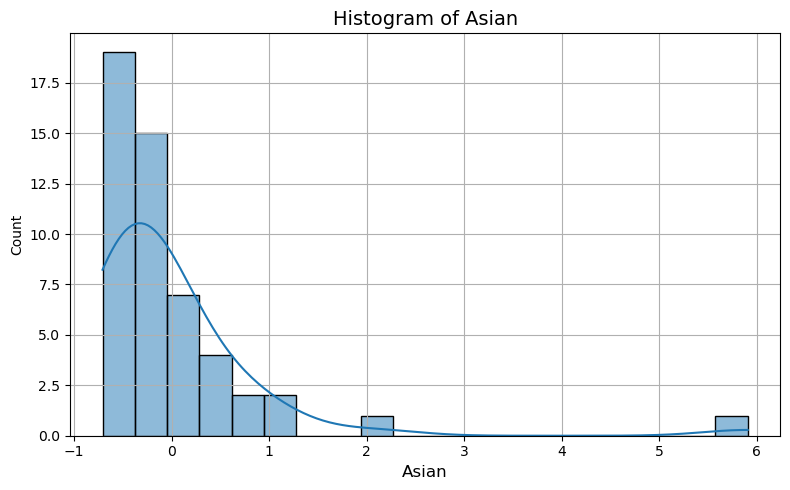

<Figure size 800x500 with 0 Axes>

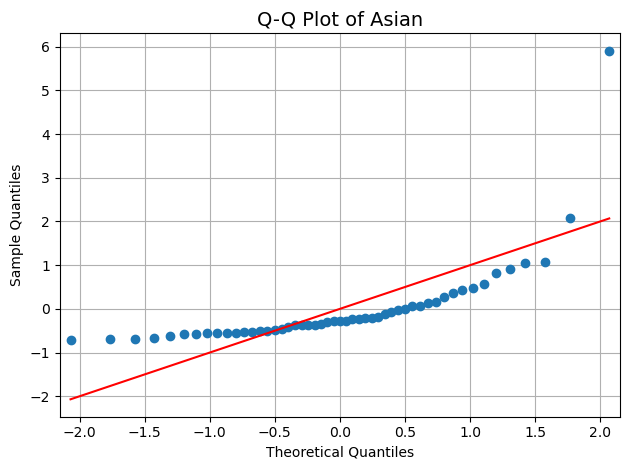

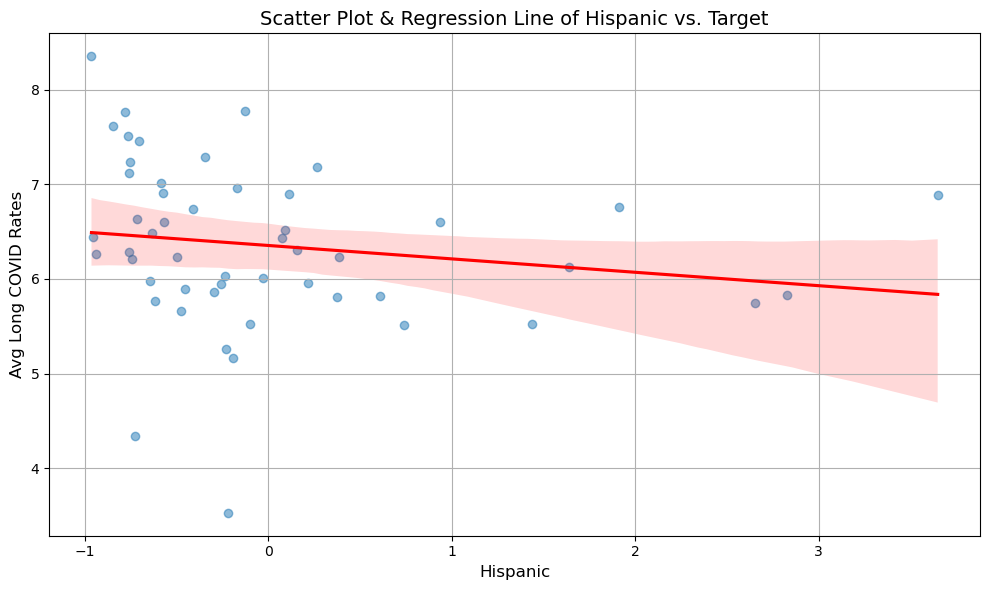

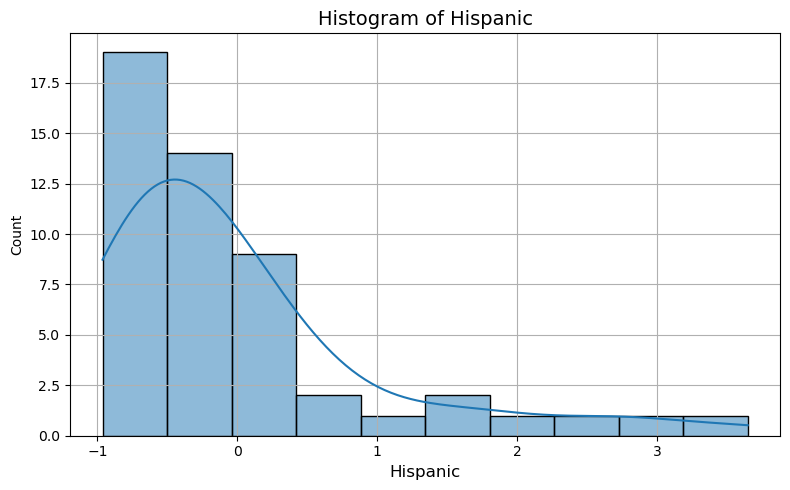

<Figure size 800x500 with 0 Axes>

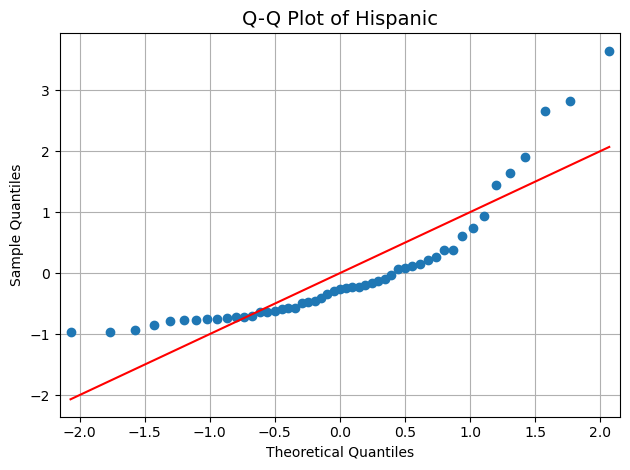

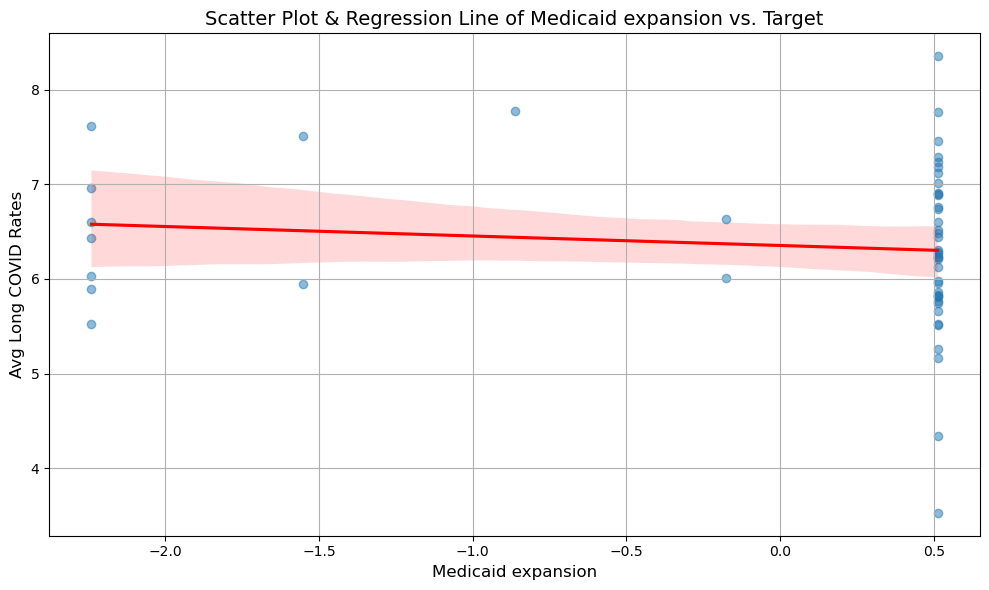

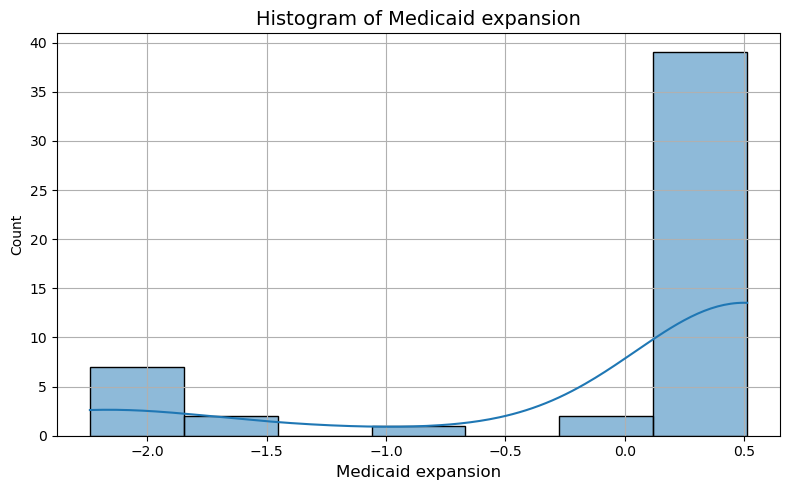

<Figure size 800x500 with 0 Axes>

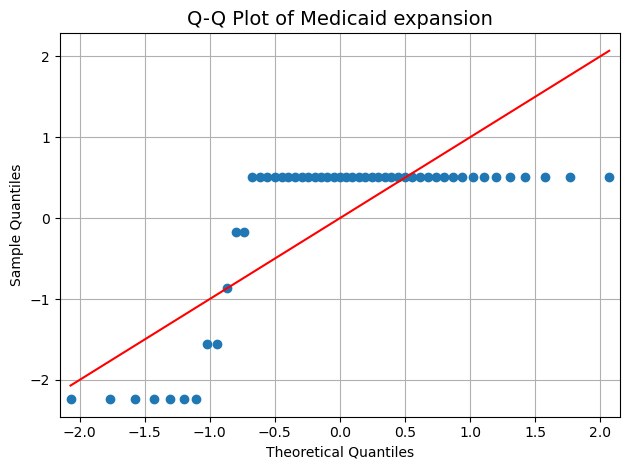

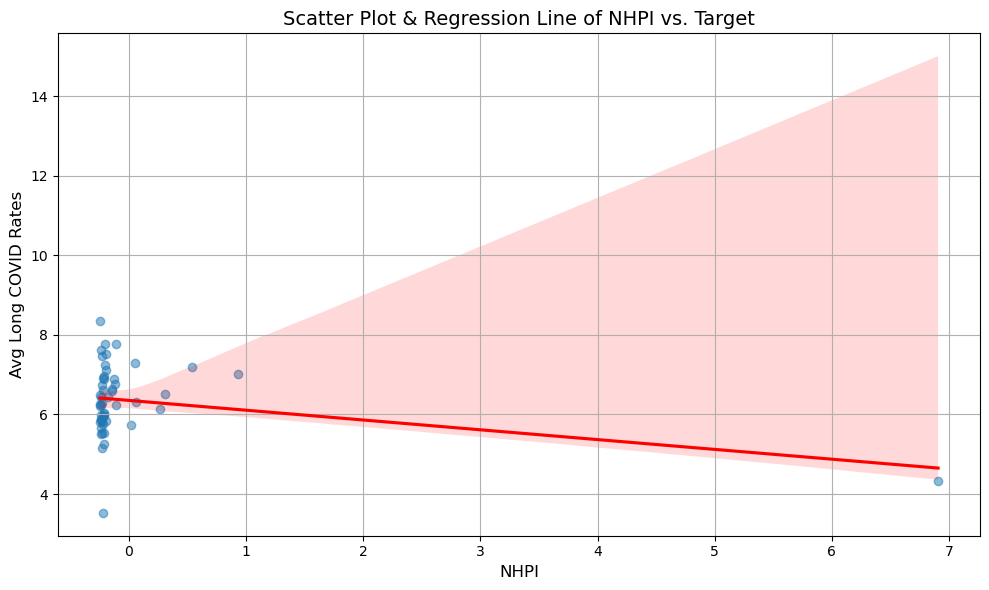

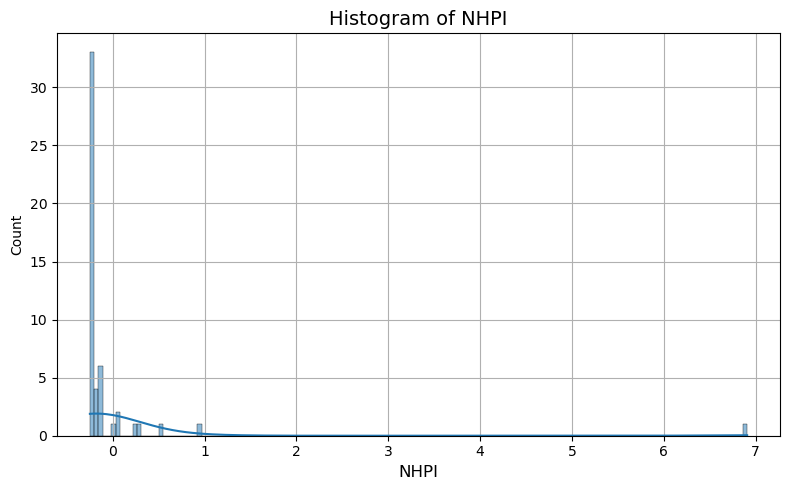

<Figure size 800x500 with 0 Axes>

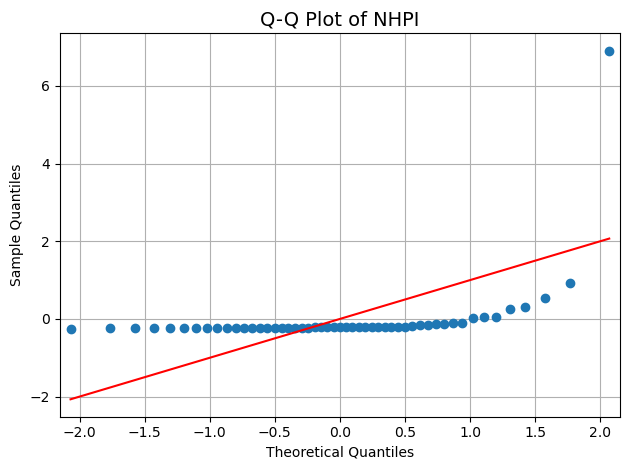

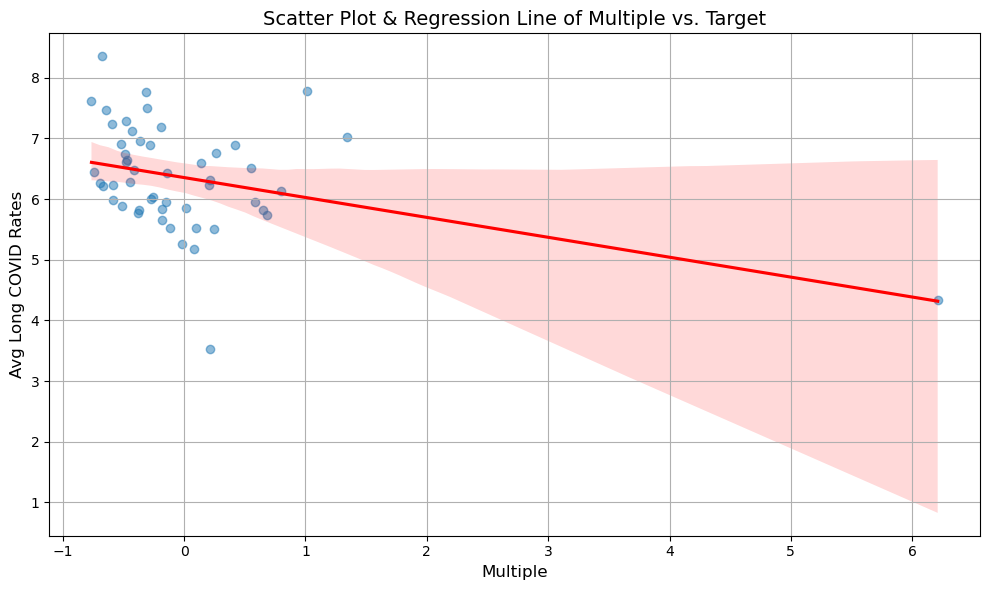

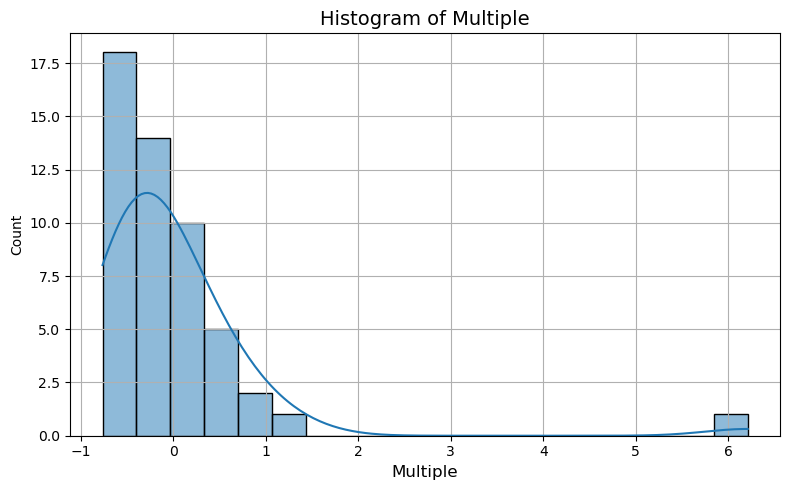

<Figure size 800x500 with 0 Axes>

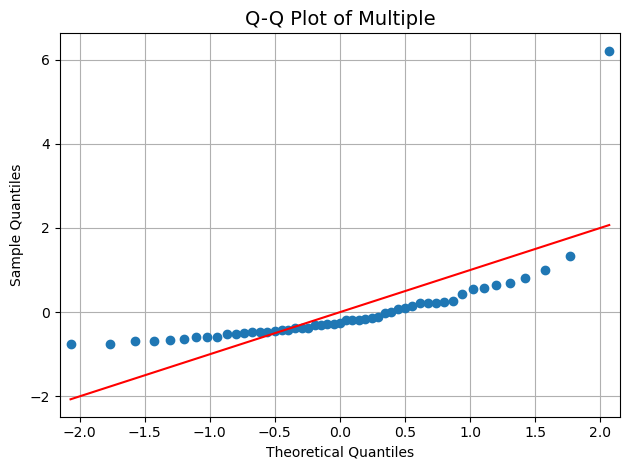

In [60]:
plots_null_hypothesis(df_variables_final, lc_rates['Avg'])

---
### Null Hypothesis Observations
---
The null hypothesis in each case is that there is no relationship between the variable and the target.

Key Metrics and Their Interpretation:

- Pearson:
    - Measures the strength and direction of linear relationships.
- Spearman:
    Measures the strength and direction of monotonic relationships (variables tend to move in the same direction, but not necessarily linearly).
- Kendall:
    - Another measure of monotonic association, often preferred when there are many tied ranks.
- p-value (for each correlation type):
    - The probability of observing a correlation as strong as the one found (or stronger) if there were actually no relationship in the population.
    - A small p-value (typically < 0.05) indicates strong evidence against the null hypothesis.

---
Analysis of Results:

- Rural:
    - Strong positive Pearson correlation (0.627604).
    - Very small p-values for all correlation types, strongly rejecting the null hypothesis.
    - Consistent results across all correlation methods suggest a robust positive relationship.

- Conservative:
    - Strong positive Pearson correlation (0.686781).
    - Very small p-values, strongly rejecting the null hypothesis.
    - Again, consistent results across methods.
    
- Below Poverty Line:
    - Moderate positive Pearson correlation (0.377218).
    - Small p-values, rejecting the null hypothesis.
    - The relationship is statistically significant, but not as strong as "Rural" or "Conservative."
    
- White:
    - Moderate positive Pearson correlation (0.525972).
    - Small p-values, rejecting the null hypothesis.
    
- Black:
    - Moderate negative Pearson correlation (-0.330835).
    - Small p-values, rejecting the null hypothesis.
    - Note the negative correlation, indicating an inverse relationship.
    
- AI_AN:
    - Moderate positive Pearson correlation (0.402963).
    - Small p-values, rejecting the null hypothesis.
    
- Asian:
    - Moderate-to-strong negative Pearson correlation (-0.542224).
    - Very small p-values, strongly rejecting the null hypothesis.
    
- Hispanic:
    - Weak negative Pearson correlation (-0.165453).
    - Relatively large p-value (0.245928) for Pearson, failing to reject the null hypothesis for Pearson.
    - However, the Spearman and Kendall p-values are significant, suggesting that the relationship may be monotonic but not linear.
    
- Medicaid expansion:
    - Very weak negative Pearson correlation (-0.117119).
    - Large p-values, failing to reject the null hypothesis.
    - There is no statistically significant linear or monotonic relationship detected.
    
- NHPI:
    - Weak negative Pearson correlation (-0.287416).
    - Relatively large p-value (0.040850) for Pearson, failing to reject the null hypothesis for Pearson at the conventional 0.05 level.
    - However, the Spearman and Kendall p-values are larger, suggesting no significant monotonic relationship either.
    
- Multiple:
    - Moderate negative Pearson correlation (-0.383203).
    - Small p-values, rejecting the null hypothesis.
    
---
Key Observations:

- Rural, Conservative, Below Pverty Line, White, Black, AI_AN, Asian, and Multiple all are statistically significant across all three p-value calculations - Pearson, Spearman, and Kendall. 
- Hispanic, Medicaid expansion, and NPHI are the three which, depending on the p-value model chosen, may or may not be statistically significant. 
- These results are more-or-less in line with the BVS model results.

Important Reminders:
- Correlation does not equal causation.
- These analyses only show associations, not cause-and-effect relationships.
- Consider potential confounding variables. 
- Other factors could be influencing these relationships.
- Check the assumptions of Pearson correlation (linearity, normality, homoscedasticity) using scatter plots and other diagnostic tools.
- If the assumptions are violated, the p-values might not be reliable.

# Data prep for paper

In [73]:
def read_results(path):
    data = pd.read_csv(path, index_col=0)
    return data

In [74]:
path = "D:\ScrippsResearch\HouseholdPulse\BVS_BVS_v11_optuna_AUTO_trial78_5000draws_summary_df_01-28-2025_12-15-47.csv"
sample_stats = read_results(path)
sample_stats

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]       0.106  0.669  -1.080    1.930      0.006    0.004     12297   
beta[1]       0.123  0.633  -0.901    1.899      0.006    0.004     10240   
beta[2]       0.068  0.584  -1.079    1.591      0.006    0.004      9730   
beta[3]       0.072  0.733  -1.415    1.961      0.007    0.005      9558   
beta[4]      -0.079  0.593  -1.666    1.020      0.006    0.004      8965   
beta[5]       0.072  0.546  -1.072    1.454      0.005    0.003     10849   
beta[6]      -0.102  0.799  -2.028    1.502      0.008    0.005     10301   
beta[7]      -0.007  0.595  -1.416    1.346      0.005    0.004     10948   
beta[8]      -0.010  0.518  -1.240    1.163      0.004    0.003     11929   
beta[9]      -0.011  0.758  -1.840    1.619      0.007    0.005     10823   
beta[10]     -0.034  0.824  -1.840    1.892      0.007    0.005     11558   
beta_raw[0]   0.107  1.890  -3.730    3.587      0.020    0.017      8884   
beta_raw[1]   0.137  1.899  -3.873    3.480      0.020    0.015      9847   
beta_raw[2]   0.100  1.916  -3.885    3.650      0.020    0.015      9222   
beta_raw[3]   0.024  1.941  -3.817    3.628      0.021    0.018      8689   
beta_raw[4]  -0.081  1.888  -3.532    3.773      0.020    0.014      8894   
beta_raw[5]   0.059  1.867  -3.730    3.594      0.019    0.014      9435   
beta_raw[6]  -0.104  1.939  -3.679    3.661      0.021    0.018      8525   
beta_raw[7]  -0.018  1.905  -3.777    3.705      0.021    0.017      8539   
beta_raw[8]  -0.026  1.900  -3.789    3.688      0.020    0.015      8880   
beta_raw[9]  -0.008  1.897  -3.567    3.770      0.020    0.015      9225   
beta_raw[10] -0.032  1.915  -3.639    3.710      0.019    0.015     10323   
ind[0]        0.329  0.470   0.000    1.000      0.005    0.004      8601   
ind[1]        0.313  0.464   0.000    1.000      0.005    0.003      8873   
ind[2]        0.308  0.462   0.000    1.000      0.005    0.003      8977   
ind[3]        0.342  0.474   0.000    1.000      0.005    0.003     10030   
ind[4]        0.305  0.460   0.000    1.000      0.005    0.003      9042   
ind[5]        0.296  0.456   0.000    1.000      0.005    0.004      7704   
ind[6]        0.355  0.479   0.000    1.000      0.005    0.004      9296   
ind[7]        0.304  0.460   0.000    1.000      0.005    0.003      9665   
ind[8]        0.287  0.452   0.000    1.000      0.005    0.003      8748   
ind[9]        0.346  0.476   0.000    1.000      0.004    0.003     11294   
ind[10]       0.361  0.480   0.000    1.000      0.005    0.004      8802   
mu[0]         0.371  1.695  -2.942    3.736      0.015    0.011     11896   
mu[1]         0.263  2.804  -5.372    6.559      0.025    0.018     11643   
mu[2]        -0.033  1.437  -3.044    2.712      0.012    0.009     12516   
mu[3]         0.361  1.267  -2.090    2.929      0.011    0.008     12009   
mu[4]        -0.641  2.253  -5.231    3.660      0.020    0.014     12725   
mu[5]        -0.199  1.086  -2.337    1.920      0.009    0.006     14426   
mu[6]        -0.283  0.845  -1.949    1.333      0.007    0.005     14199   
mu[7]        -0.486  1.412  -3.479    2.090      0.013    0.009     11810   
mu[8]        -0.955  2.798  -7.050    4.054      0.026    0.018     11407   
mu[9]        -0.198  1.662  -3.730    2.887      0.014    0.010     12626   
mu[10]       -0.145  1.762  -3.789    3.421      0.015    0.011     12198   
mu[11]       -1.308  5.494 -12.907    8.970      0.047    0.033     13120   
mu[12]        0.256  1.041  -1.732    2.296      0.009    0.006     12724   
mu[13]       -0.301  0.896  -2.093    1.368      0.008    0.005     13204   
mu[14]        0.162  0.693  -1.202    1.515      0.006    0.004     12071   
mu[15]        0.262  0.973  -1.491    2.286      0.009    0.006     12072   
mu[16]        0.156  1.265  -2.533    3.055      0.011    0.007     11890   
mu[17]        0.445  1.388  -2.048    3.303      0.013    0.010     12013   
mu[18]     

In [75]:
# def clean_up_data(sample_stats, df_variables):
#     """ Extracts beta mean statistics from sample statistics and aligns them with 
#     variable labels from a DataFrame.

#     This function filters rows in `sample_stats` that start with "beta" (but not "beta_raw"),
#     and then uses the column names from `df_variables` as the new index for the filtered data.

#     Args:
#         sample_stats: Pandas DataFrame containing sample statistics, likely including 
#                       beta values. The index of this DataFrame is assumed to contain
#                       strings that identify the statistic.
#         df_variables: Pandas DataFrame containing the variable names.  The *columns* of this
#                       DataFrame are assumed to correspond to the beta values in `sample_stats`.

#     Returns:
#         beta_means_results: A DataFrame containing the extracted beta means, with the 
#                           variable names from `df_variables` as the index.
    
#     """
#     beta_means_results  = sample_stats.loc[
#         sample_stats.index.str.startswith('beta') & ~sample_stats.index.str.startswith('beta_raw')
#     ]   
#     x_labels = list(df_variables.columns)
    
#     beta_means_results.set_index(pd.Index(x_labels), inplace=True)
    
#     return beta_means_results

In [76]:
beta_means_results = clean_up_data(sample_stats, df_variables_final)
beta_means_results

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Rural               0.106  0.669  -1.080    1.930      0.006    0.004   
Conservative        0.123  0.633  -0.901    1.899      0.006    0.004   
Below Poverty Line  0.068  0.584  -1.079    1.591      0.006    0.004   
White               0.072  0.733  -1.415    1.961      0.007    0.005   
Black              -0.079  0.593  -1.666    1.020      0.006    0.004   
AI_AN               0.072  0.546  -1.072    1.454      0.005    0.003   
Asian              -0.102  0.799  -2.028    1.502      0.008    0.005   
Hispanic           -0.007  0.595  -1.416    1.346      0.005    0.004   
Medicaid expansion -0.010  0.518  -1.240    1.163      0.004    0.003   
NHPI               -0.011  0.758  -1.840    1.619      0.007    0.005   
Multiple           -0.034  0.824  -1.840    1.892      0.007    0.005   

                    ess_bulk  ess_tail  r_hat  
Rural                  12297     12895      1  
Conservative           10240      9062      1  
Below Poverty Line      9730     11209      1  
White                   9558      8467      1  
Black                   8965      8977      1  
AI_AN                  10849     10887      1  
Asian                  10301     10414      1  
Hispanic               10948     11061      1  
Medicaid expansion     11929     10223      1  
NHPI                   10823     11704      1  
Multiple               11558     10274      1

In [426]:
def save_cleaned_results(df, save_path):
    df.to_csv(save_path, index=True) 

In [427]:
save_path = "D:\ScrippsResearch\HouseholdPulse\BVS_BVS_v11_optuna_AUTO_trial78_5000draws_summary_df_01-28-2025_12-15-47_BETA_MEANS_RESULTS.csv"
save_cleaned_results(beta_means_results, save_path)